In [1]:
import pandas as pd
import numpy as np
from collections import Counter


In [2]:
from google.colab import drive
!cd ~
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA"
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA
'family msa_gen_vector_iadf+.ipynb'
 msa_gen_vector_iadf+.ipynb
 msa_gen_vector_iadf.ipynb
 msa.ipynb
 RE_df.gsheet
 RE_df.tsv
 res_of_iadf_pca.csv
 res_of_iadf_plus_pca
 res_of_iadf_plus_pca.csv
 res_of_pca_tfidf.csv
'results summerizetion.ipynb'
'submission of PCA msa_gen_vector_iadf+.ipynb'
'submission of PCA msa_gen_vector_iadf.ipynb'
'submission of PCA msa_gen_vector_tf_idf.ipynb'
'submission of TSNE msa_gen_vector_iadf+.ipynb'


# data

In [3]:
df_data = pd.read_csv('RE_df.tsv', sep='\t')
df_data['family_lable'] =  df_data['msa'].str.split('_').str[0]
familys_with_re = list(df_data.query('is_RE==1').family_lable.unique())
familys_with_out_re = list(df_data.query('is_RE==0').family_lable.unique())

df_data = df_data.query('family_lable in @familys_with_re and family_lable in @familys_with_out_re')
family_lables = df_data['family_lable'].to_list()
dataset = df_data['seq'].tolist()
all_true_lables = df_data['is_RE'].tolist()

In [4]:
len(df_data.family_lable.unique())

48

In [5]:
def kmers_extraction(msa, kmer_size=4):
  kmers=[]
  for i,_ in enumerate(msa):
    if i < len(msa)-kmer_size+1:
      kmers.append(msa[i:i+kmer_size])
  return kmers


In [6]:
def preprocess(dataset):
 return [kmers_extraction(i) for i in dataset ]
processed_text = preprocess(dataset)
len(processed_text)

5143

In [7]:

DF = {}
for i in range(len(processed_text)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [8]:
total_vocab = [x for x in DF]
len(set(total_vocab))

325

In [9]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return len(c)

# tf idf

In [10]:
import math 

 # mean df for ne algo

tf_idf = {}

N = len(dataset)


def gen_vector_tf_idf(tokens):

    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

# the run

# PCA

In [11]:
vecs = [ gen_vector_tf_idf(i)  for i in preprocess(dataset)]
# vecs

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns
from numpy import reshape

def pca(vecs):
  x = np.array(vecs)
  # x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])
  pca = PCA(n_components=2)
  z = pca.fit_transform(x)
  df = pd.DataFrame()

  df["y"] = family_lables
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df['color'] = all_true_lables
  # df = df.query('y=="Salmonella"')
  return df, z
  

In [13]:
df , z = pca(vecs)


In [14]:
len(df.query('color==1').y.unique())

48

# families clusters


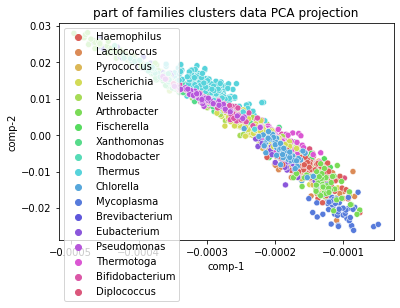

In [15]:
## families clusters
part_of_families = list(set(family_lables))[30:50]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

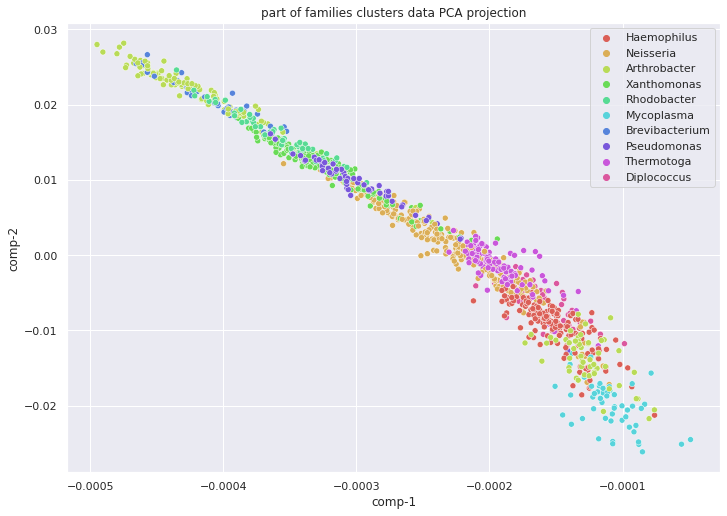

In [16]:
## families clusters
part_of_families = list(set(family_lables))[30:40]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [17]:
# tsne visualizetion by family

<ipython-input-18-93fa05f27660>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


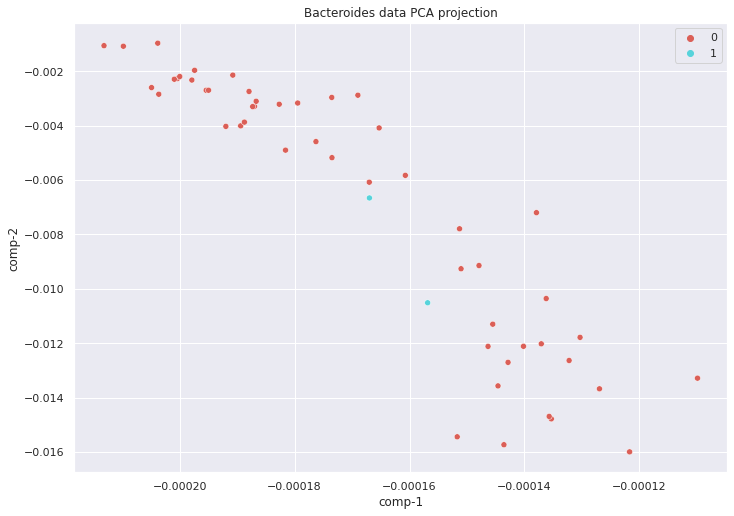

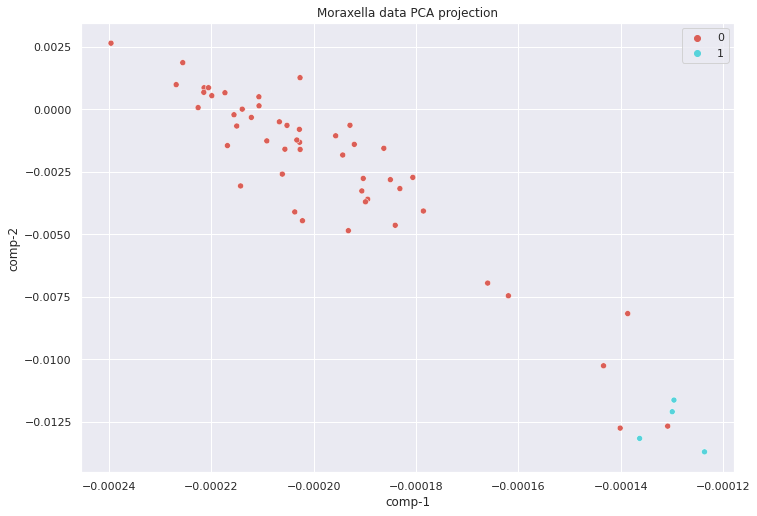

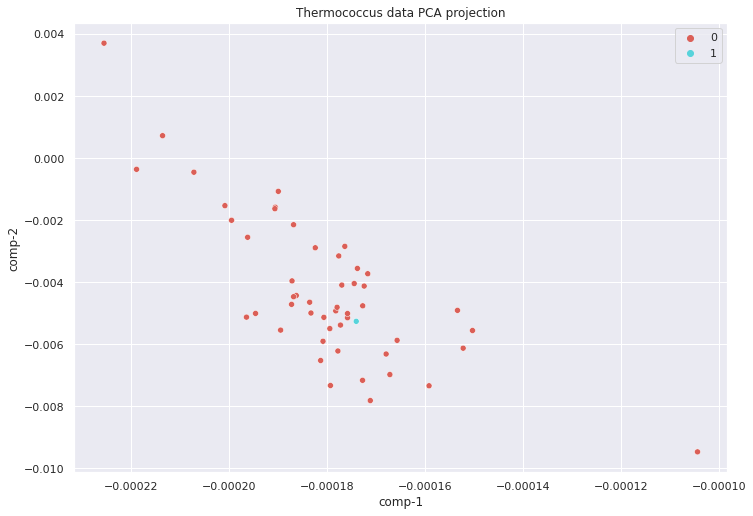

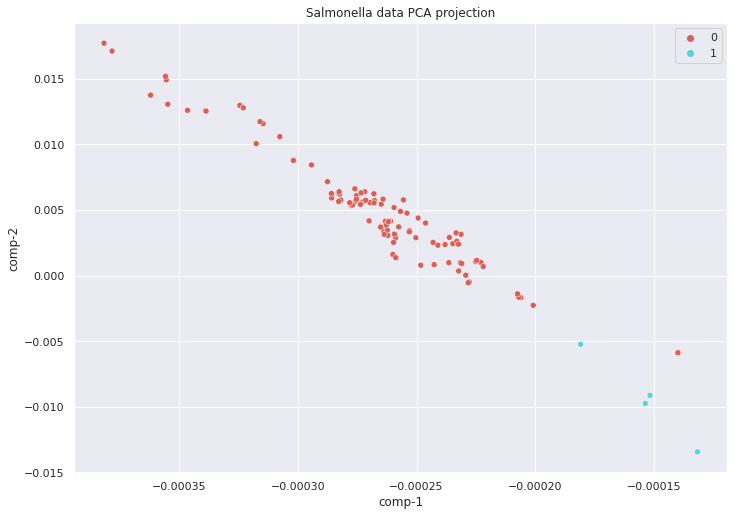

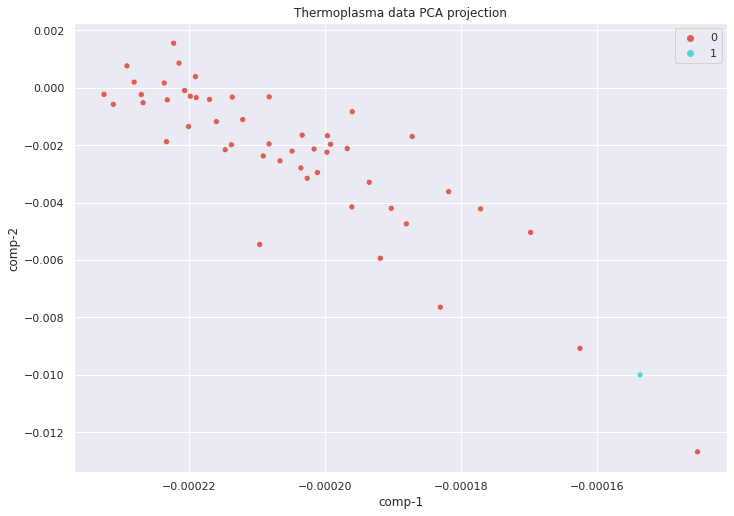

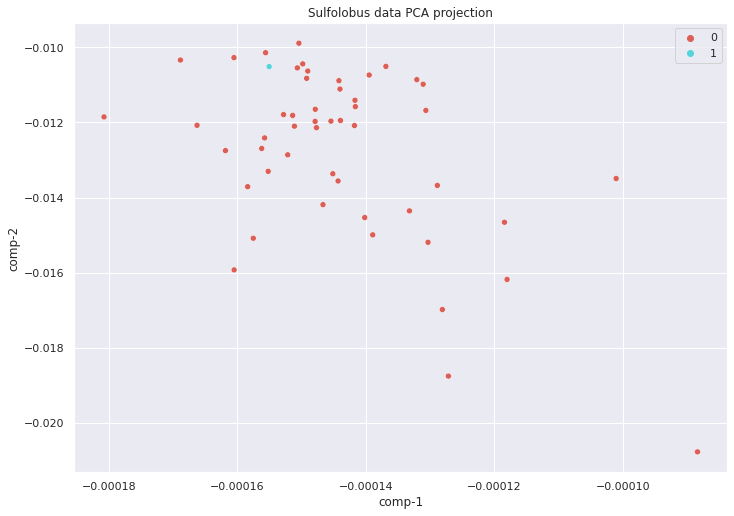

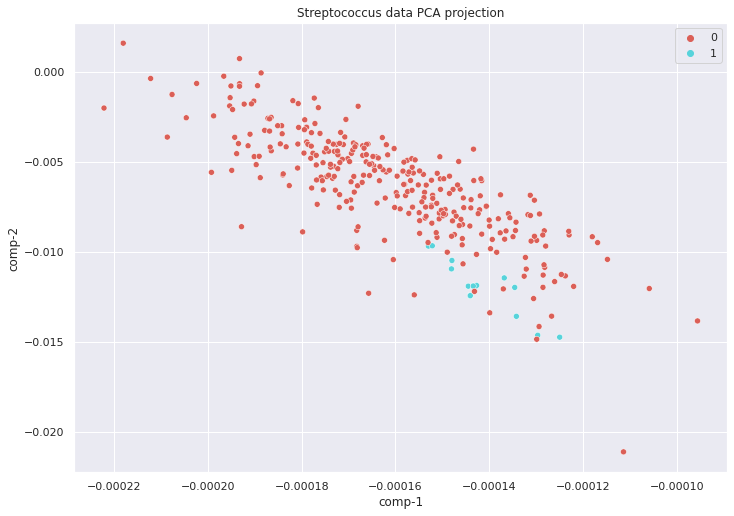

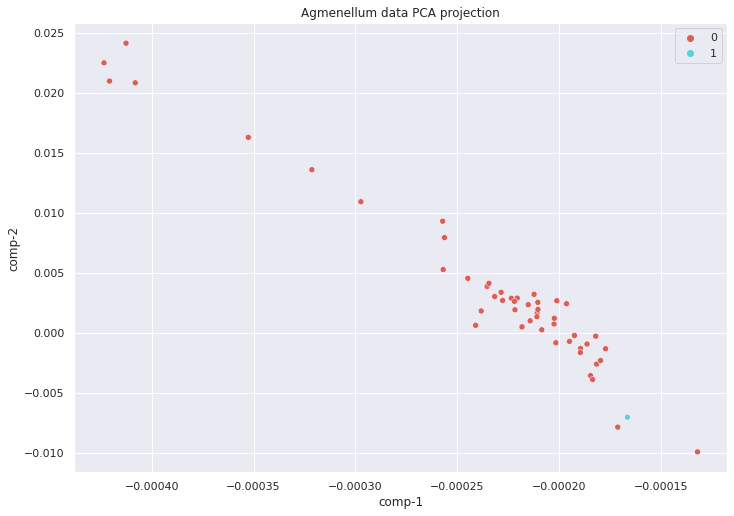

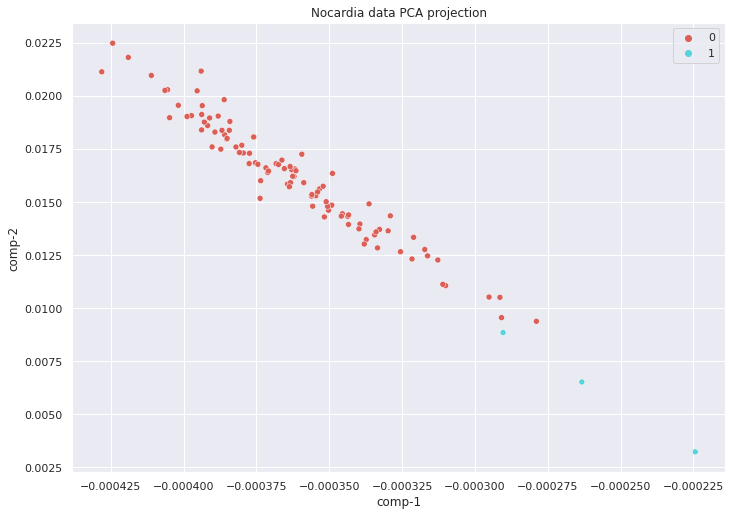

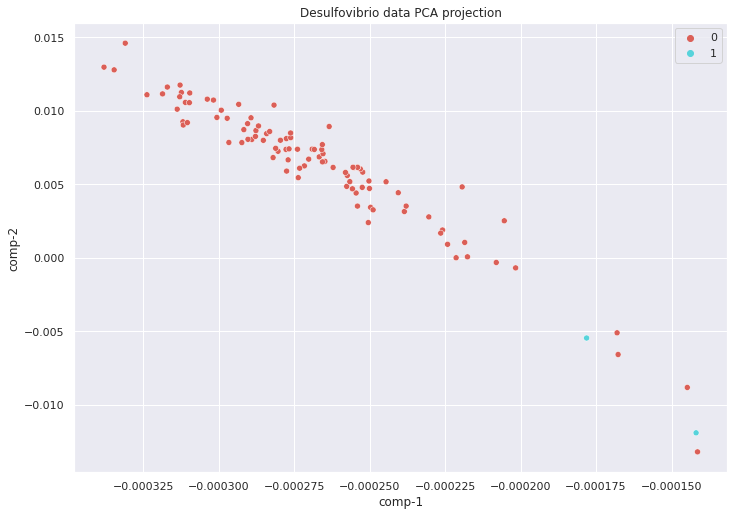

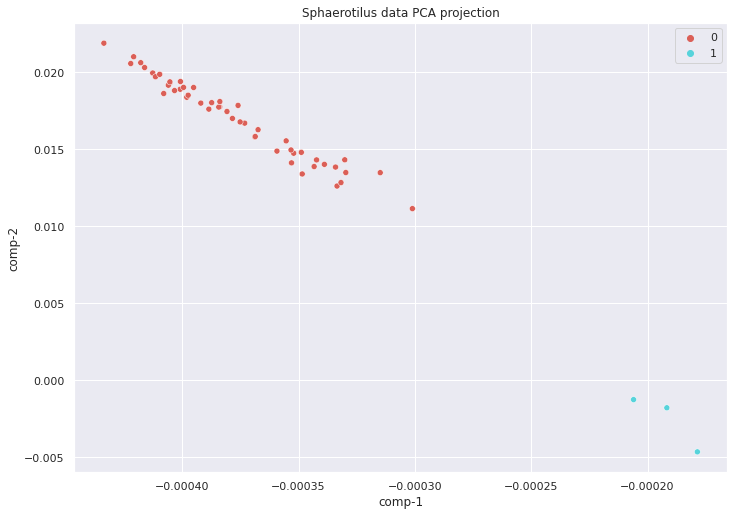

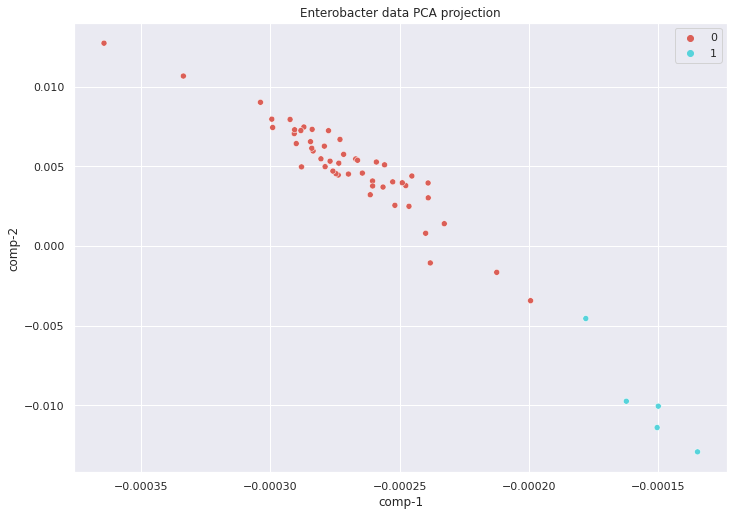

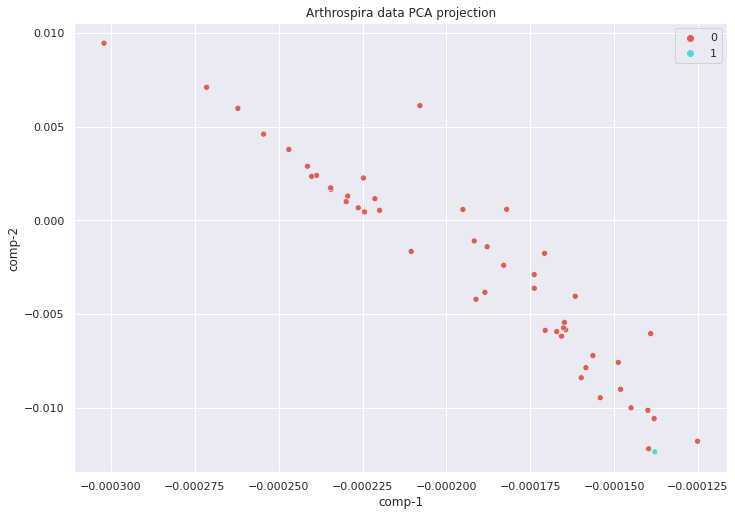

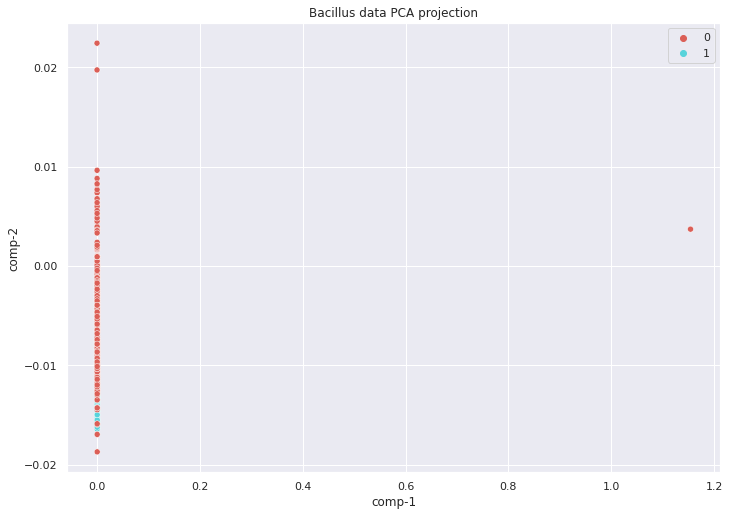

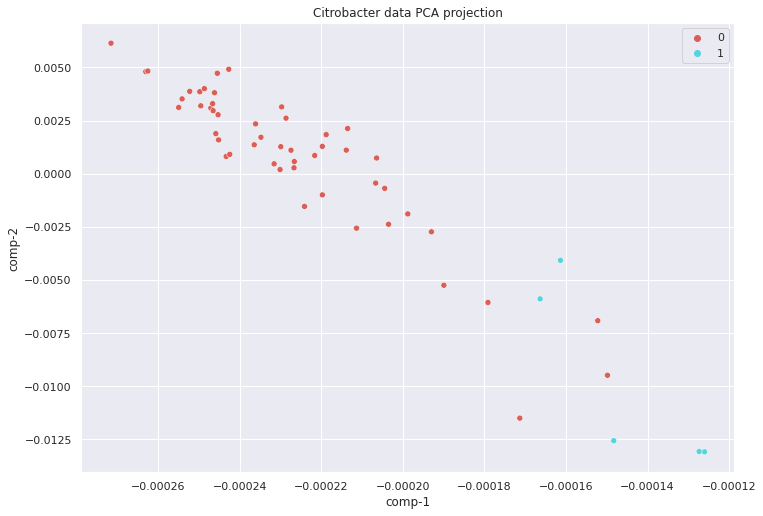

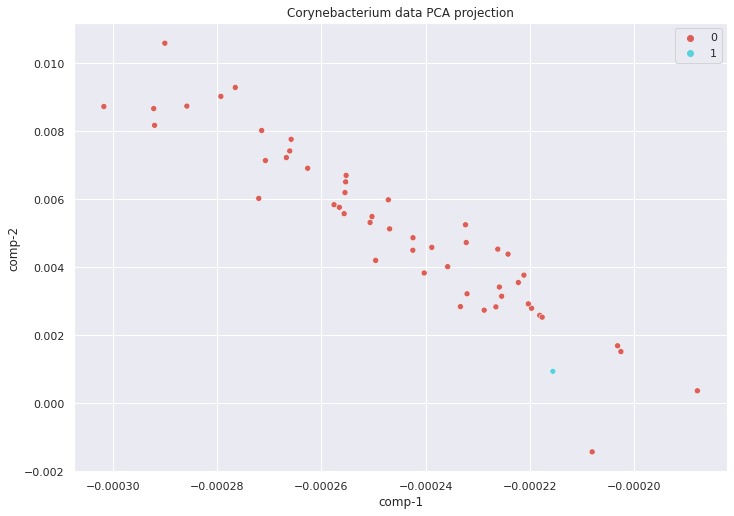

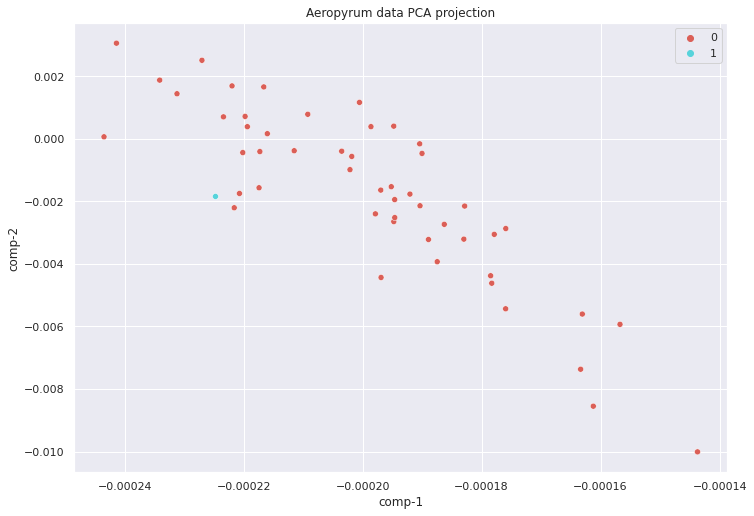

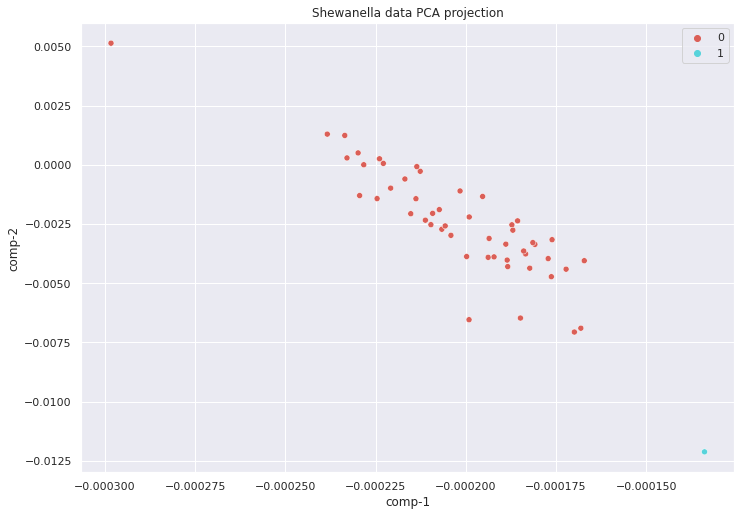

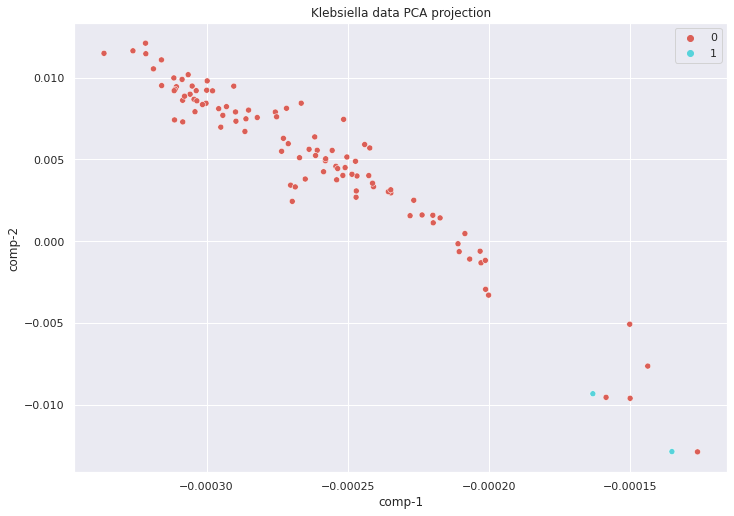

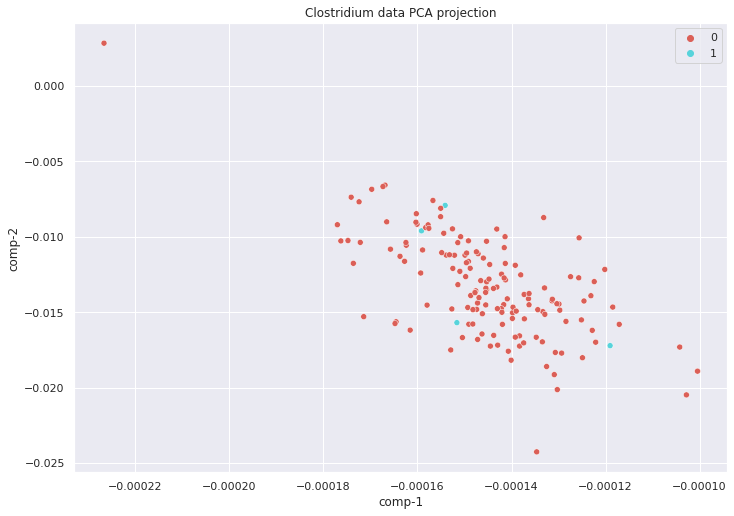

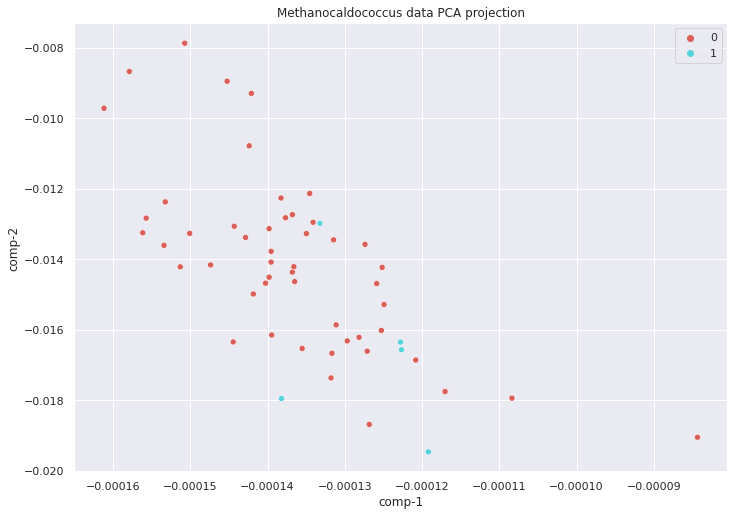

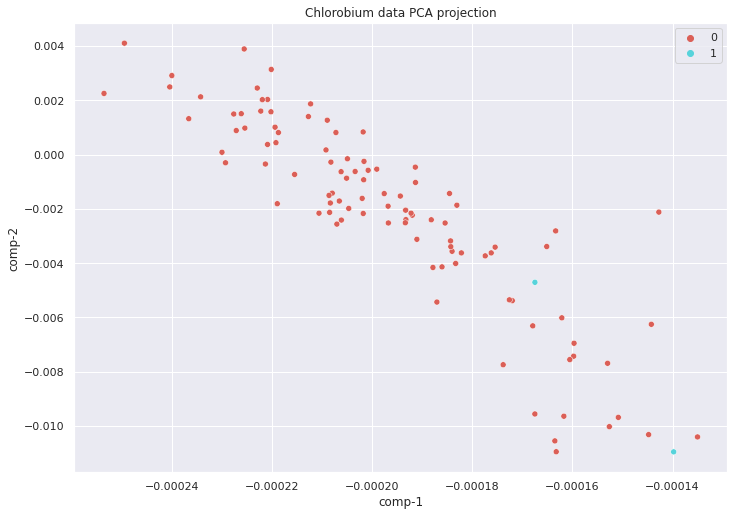

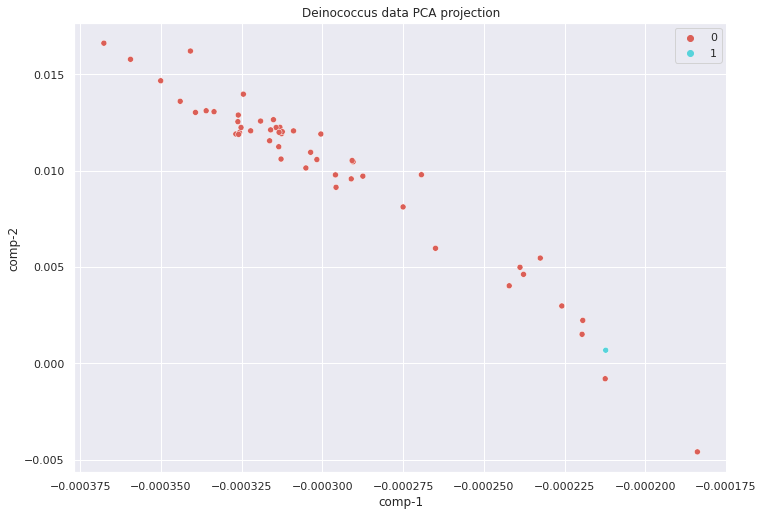

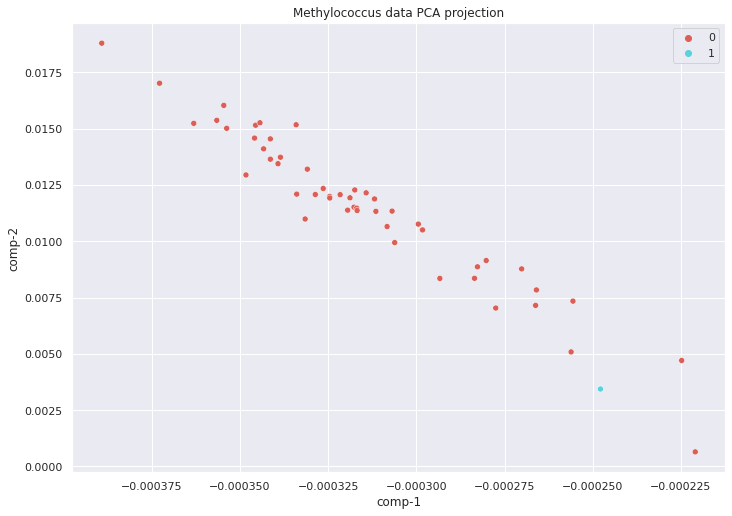

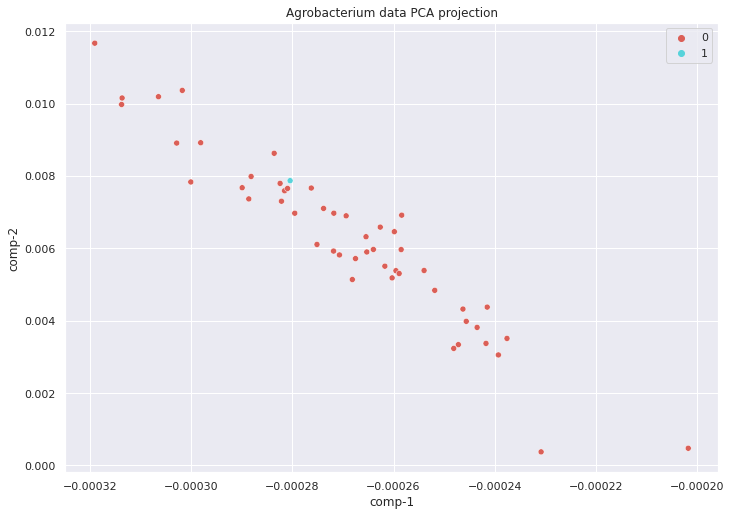

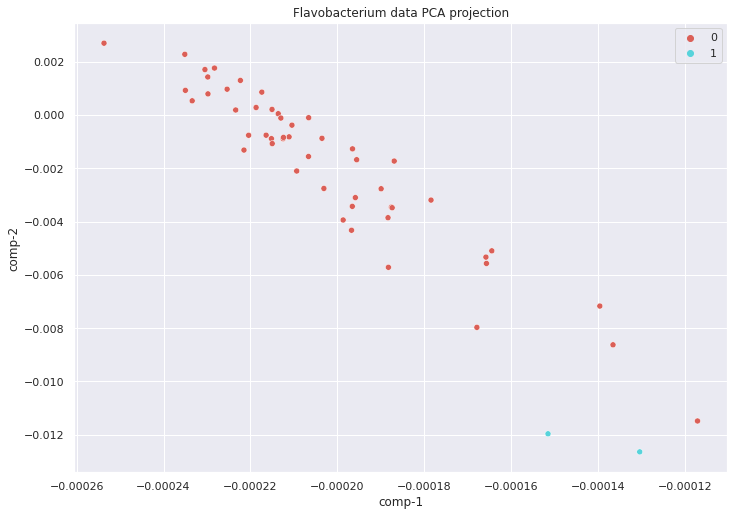

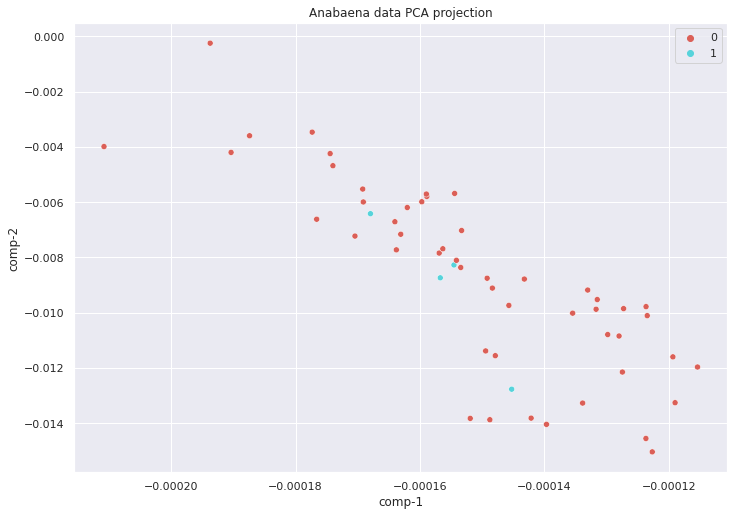

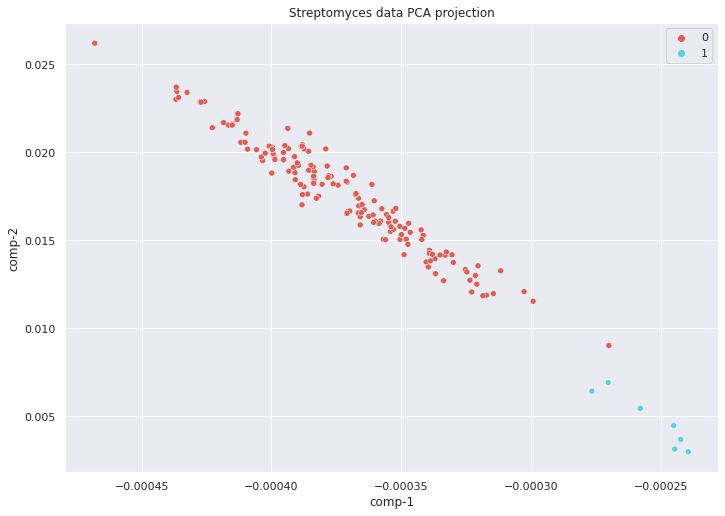

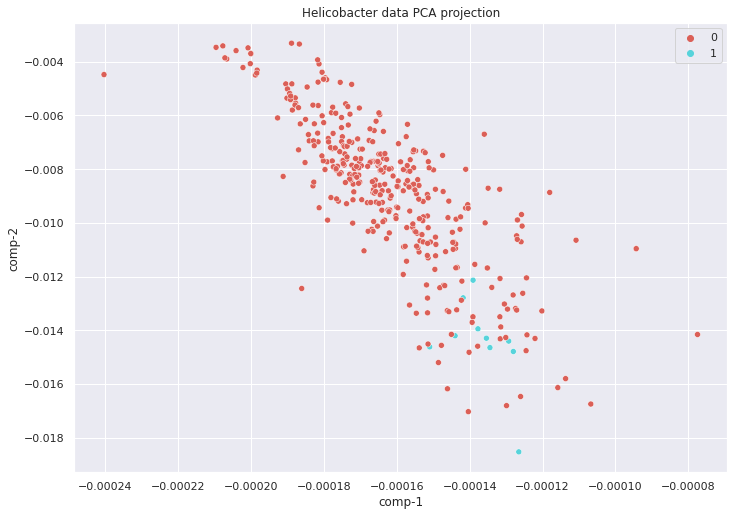

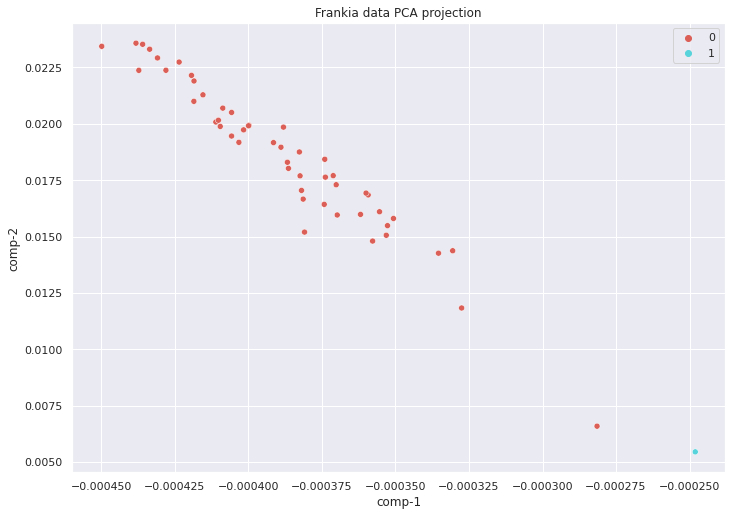

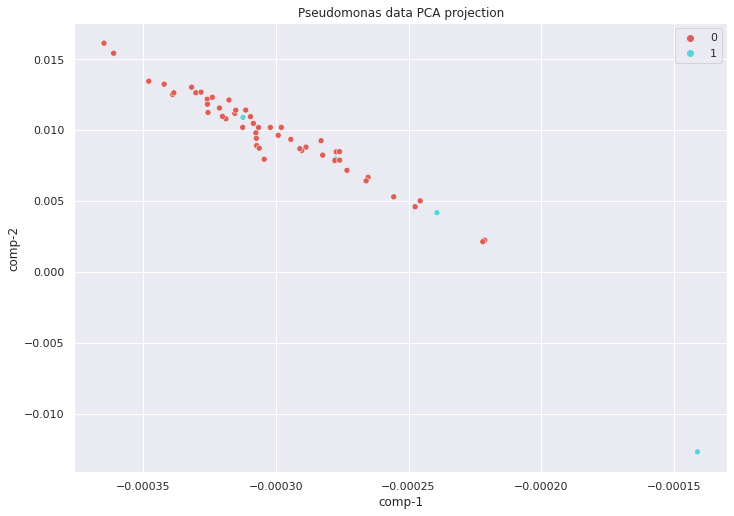

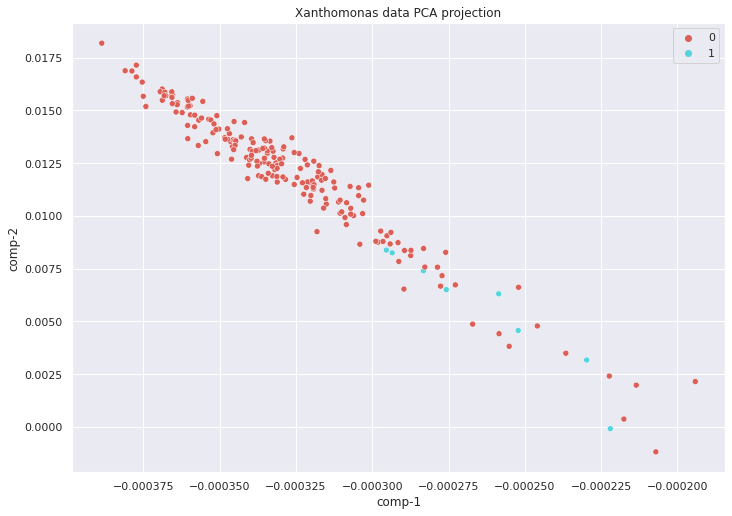

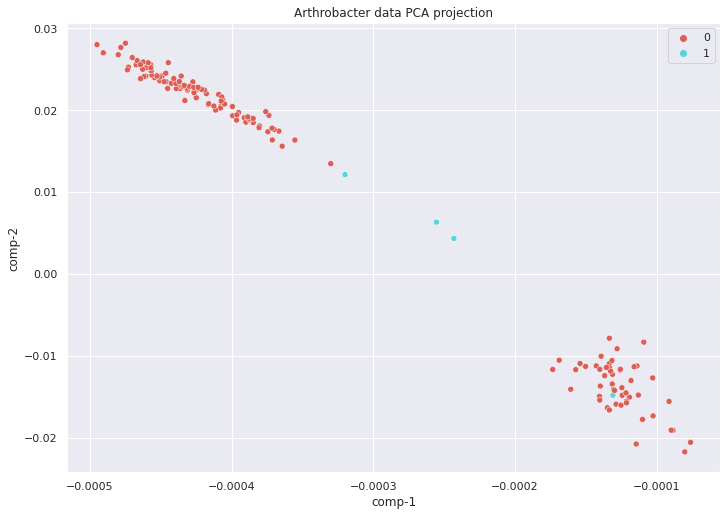

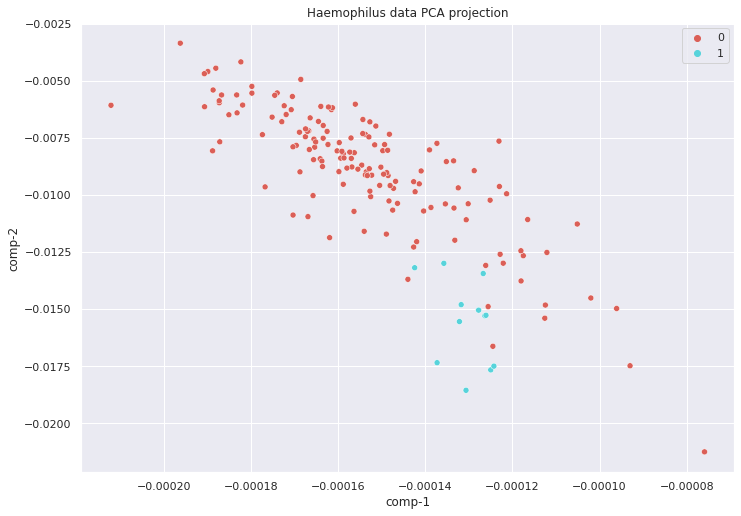

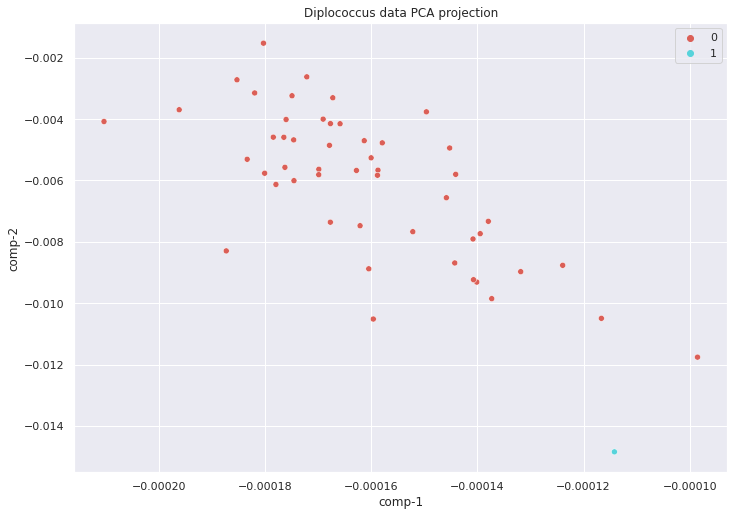

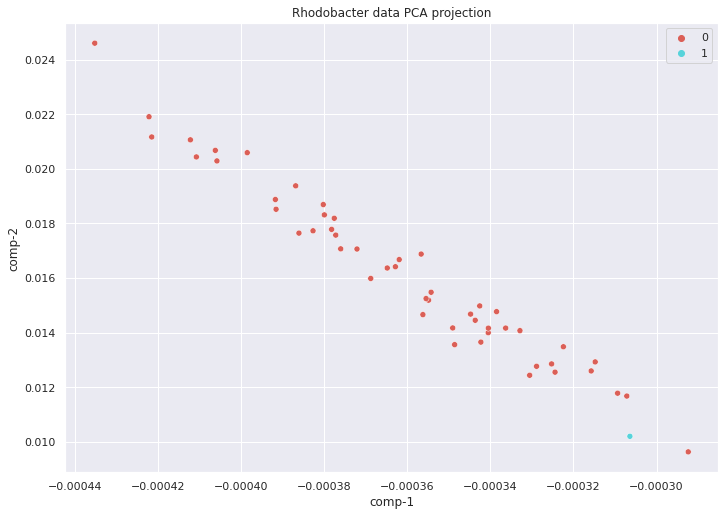

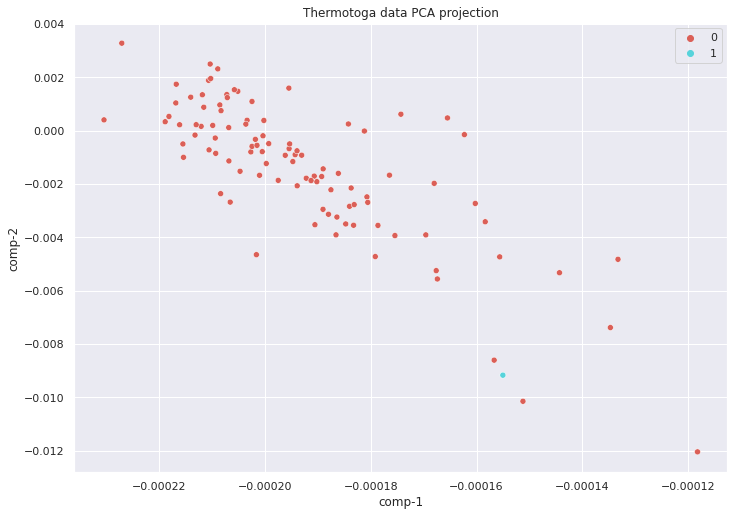

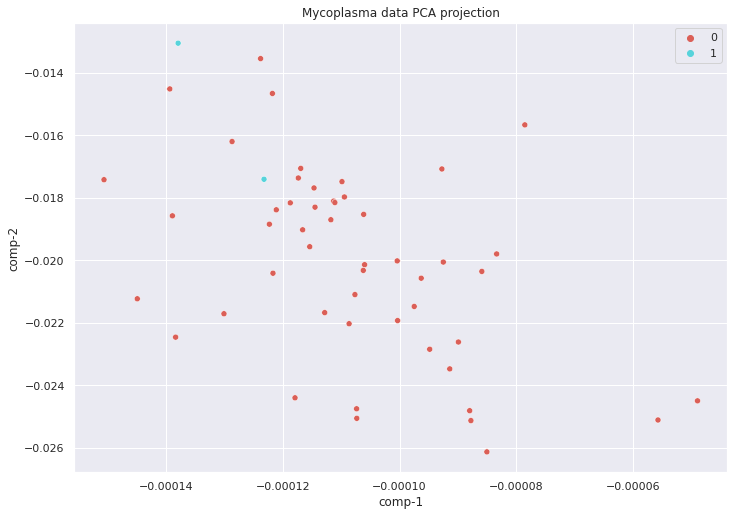

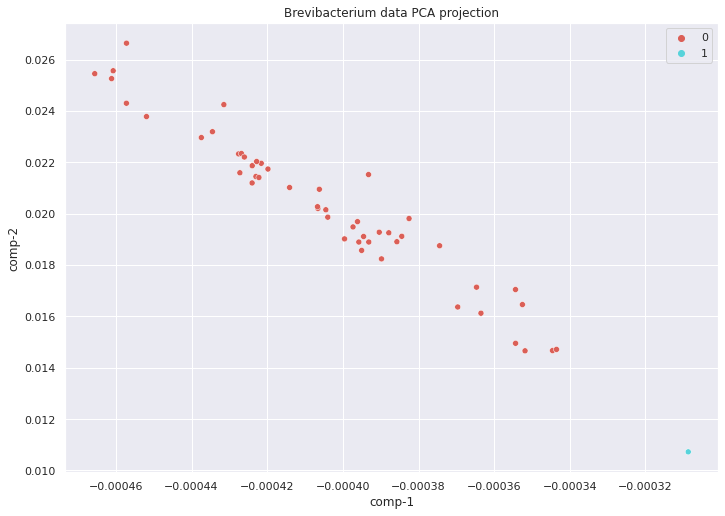

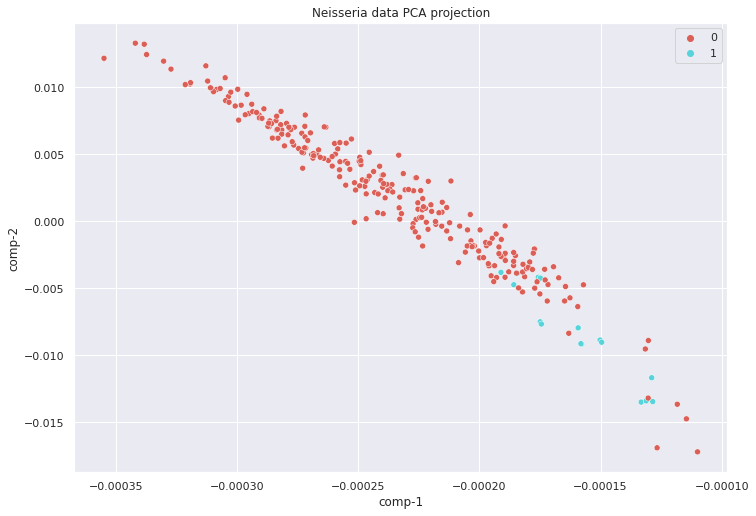

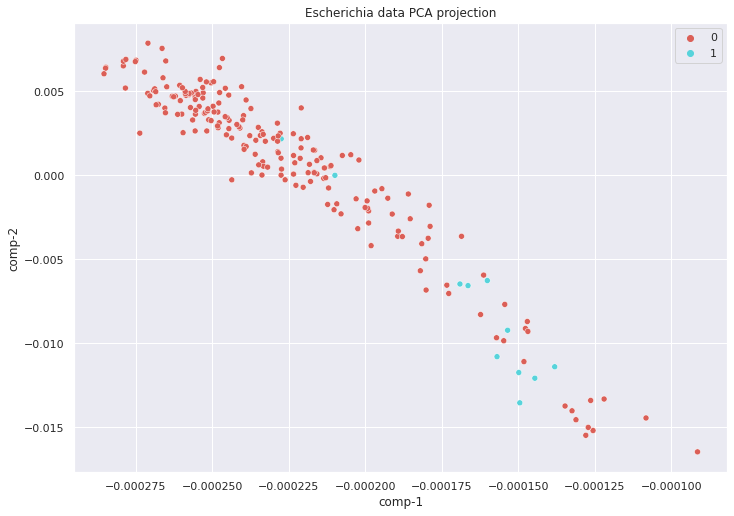

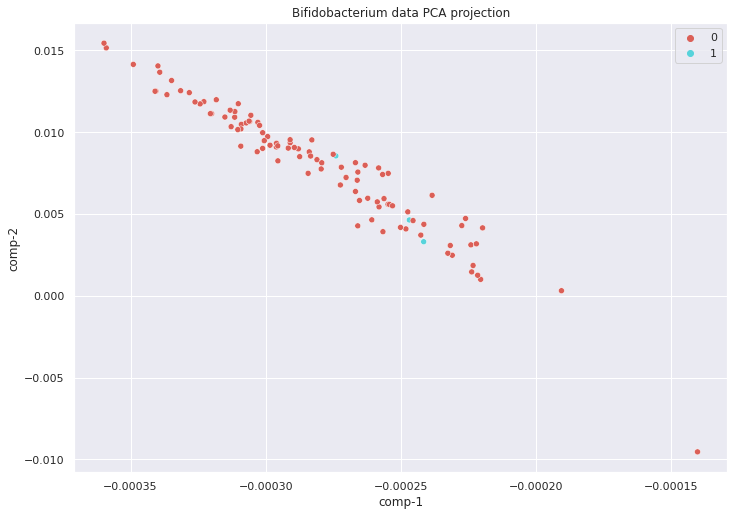

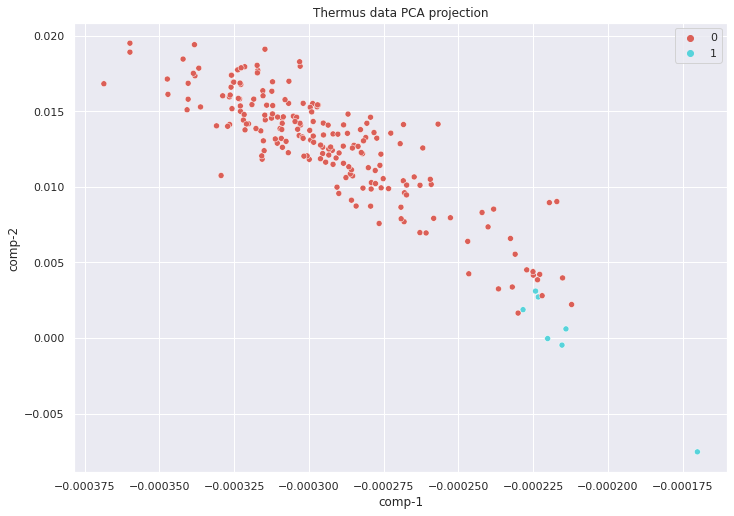

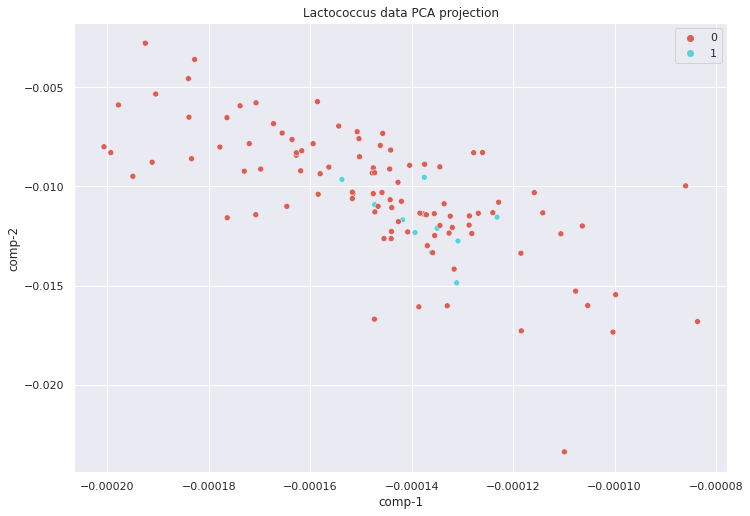

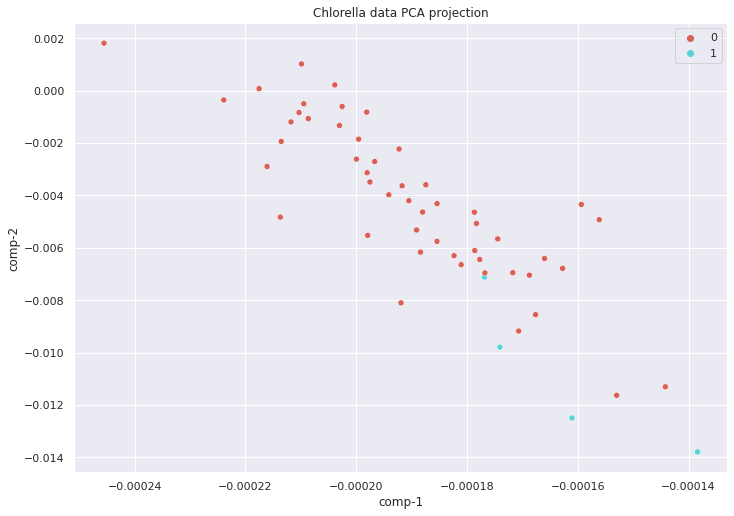

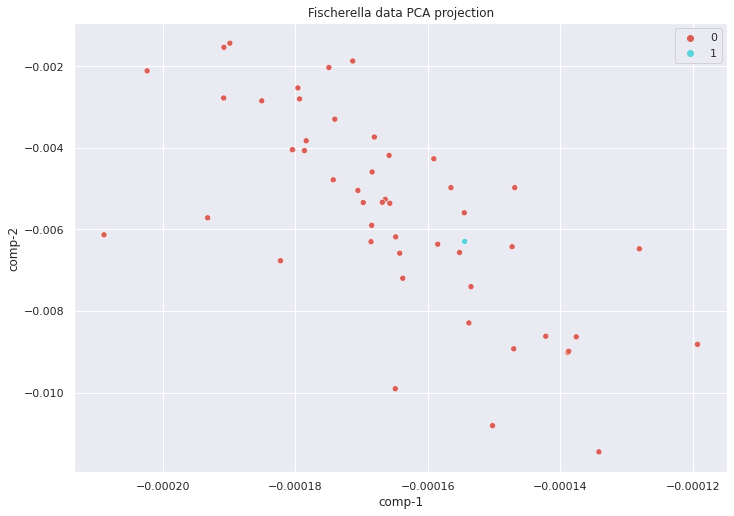

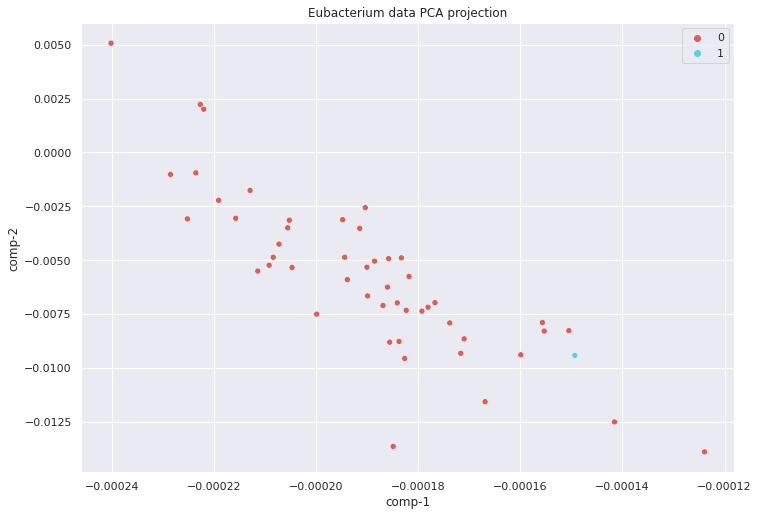

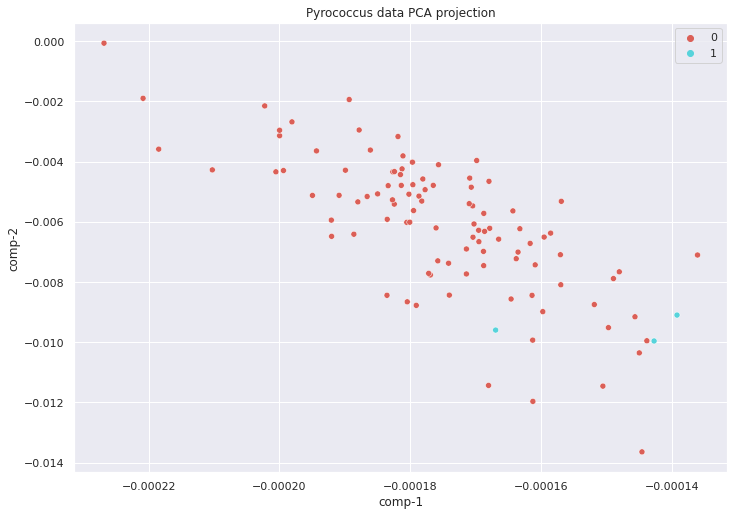

In [18]:
import matplotlib.pyplot as plt

for i in set(family_lables):
  df1= df.query('y==@i') ### very bad example: Thermococcus - maybe good
  if len(df1.color.unique())>1:
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.color.tolist(),
                      palette=sns.color_palette("hls", 2),sizes=[600,800],
                      data=df1).set(title=f"{i} data PCA projection")
      
    sns.set(rc={'figure.figsize':(11.7,8.27)})


# general function

In [19]:
def confusion_matrix_re(true_lables, pred_lables):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  sum = 0
  for true, pred in zip(true_lables, pred_lables):
    if true == 1 and  pred == -1:
      tp +=1
    if true == 1 and  pred != -1:
      fp += 1
    if true == 0 and  pred == -1:
      fn +=1
    if true == 0 and  pred != -1:
      tn +=1
  return tp/len(true_lables) , fp/len(true_lables), fn/len(true_lables),  tn/len(true_lables)



In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics import homogeneity_completeness_v_measure


all_res_table= []


def clustering_function(familyes,df_data, df, algorithem, params):
  familyes =  sorted(familyes)
  num_of_family = 0
  for  i  in familyes:
    d = {}
    d['algo'] = algorithem
    df1= df.query('y==@i')
    df_data1 = df_data.query('family_lable==@i')
   
    true_labels = df_data1.is_RE.tolist()

    if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
      print('-------------------')
      print(i)
      d['family_lable'] = i 
      print (num_of_family ,i)
      if params:
        algo = algorithem(**params[num_of_family])
      else:
        algo = algorithem()
      pred_labels = algo.fit_predict(df1[['comp-1','comp-2']].values)
      if len(set(pred_labels))>1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        print(f"Adjusted Rand Index: {ari}")

        d['ari'] = ari 

        fmi = fowlkes_mallows_score(true_labels, pred_labels)
        print(f"fowlkes_mallows_score: {fmi}")

        d['fmi'] = fmi 

        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, pred_labels)
        print(f"homogeneity_completeness_v_measure: {homogeneity} {completeness} {v_measure}")


        d['homogeneity'] = homogeneity 
        d['completeness'] = completeness 
        d['v_measure'] = v_measure 

        tp, fp, fn, tn = confusion_matrix_re(true_labels, pred_labels)
        d['tp'] = tp
        d['fp'] = fp
        d['fn'] = fn
        d['tn'] = tn

        d['family_size'] = len(true_labels)
        d['re_size'] = np.sum(true_labels)


        all_res_table.append(d)
      else:
        print('caoudnot seperate to clusters')

      num_of_family +=1

      markers = ["." if label == 0 else "d" for label in true_labels]
      if -1 in pred_labels:
        colors = ["red" if label == -1 else "black" for label in pred_labels]
      else:
        colors = ["blue" if label == 1 else  "orange" for label in pred_labels]

    

      for i in range(len(markers)):
        plt.scatter(df1['comp-1'].values[i], df1['comp-2'].values[i], c=colors[i] ,marker=markers[i])
      plt.show()





# dbscan

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
48
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


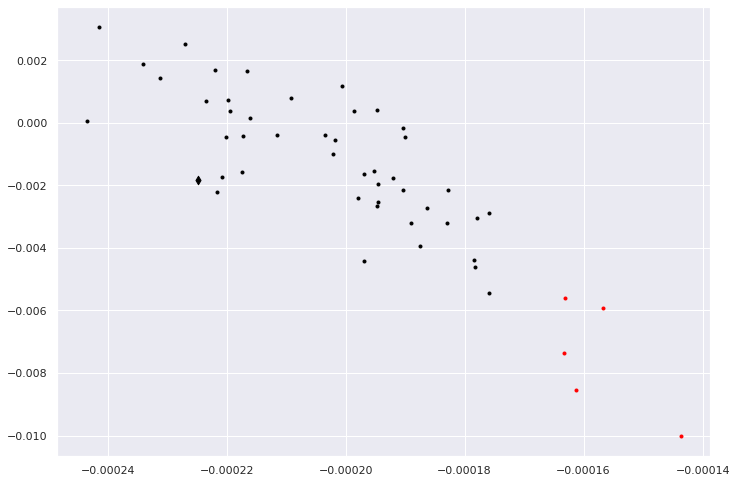

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


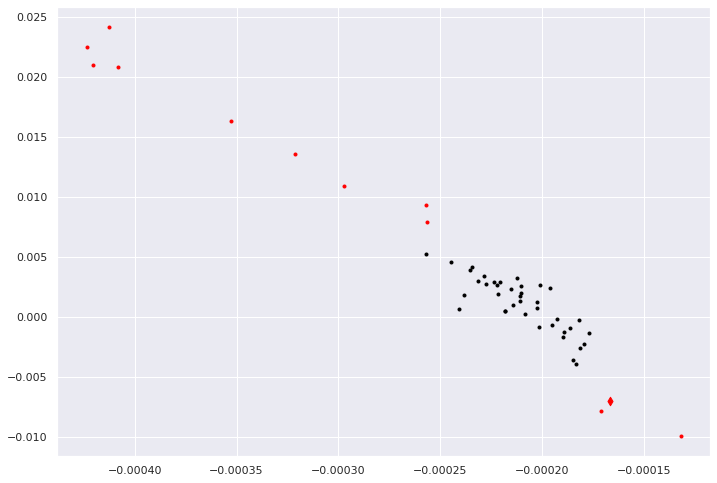

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: 0.015040939836240655
fowlkes_mallows_score: 0.5399709604961477
homogeneity_completeness_v_measure: 0.36214622269949365 0.02740243845036948 0.05094967878089528


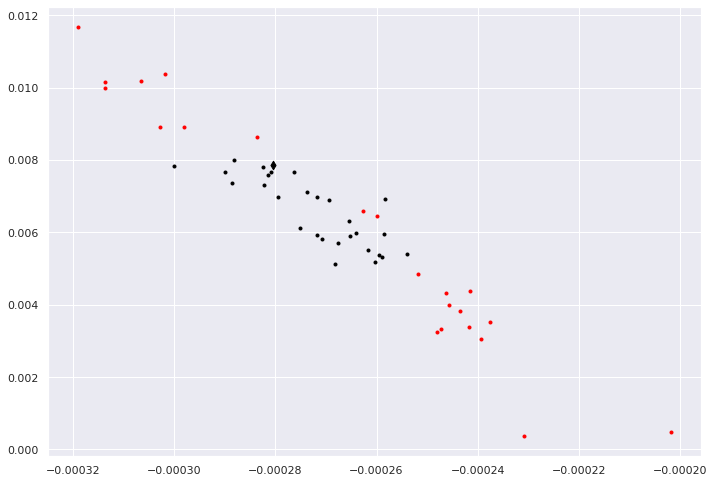

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: 0.003379574982230567
fowlkes_mallows_score: 0.5446447239222474
homogeneity_completeness_v_measure: 0.021735796884723966 0.005387634001915743 0.008634934042400642


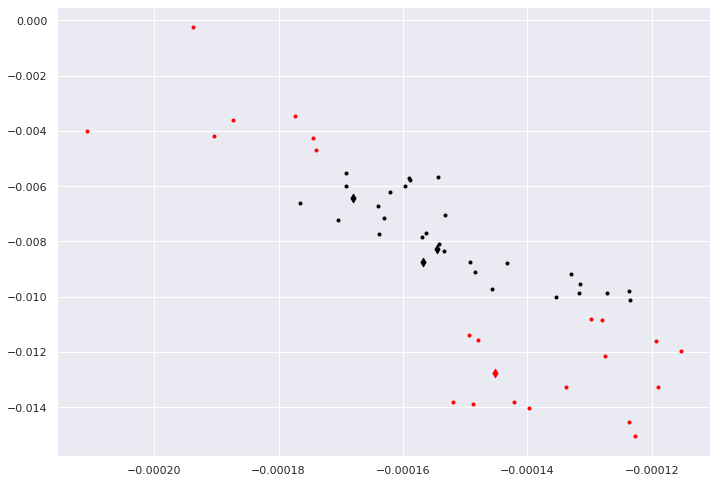

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.04400021868588352
fowlkes_mallows_score: 0.63964820363935
homogeneity_completeness_v_measure: 0.28108082132997536 0.030295957145712052 0.05469651628603632


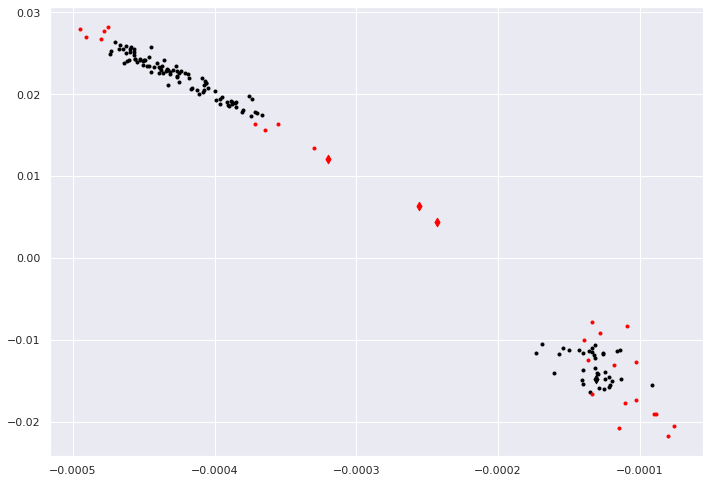

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.011254019292604502
fowlkes_mallows_score: 0.4642070825485276
homogeneity_completeness_v_measure: 0.21533959051027712 0.013924635416146799 0.026157812248302957


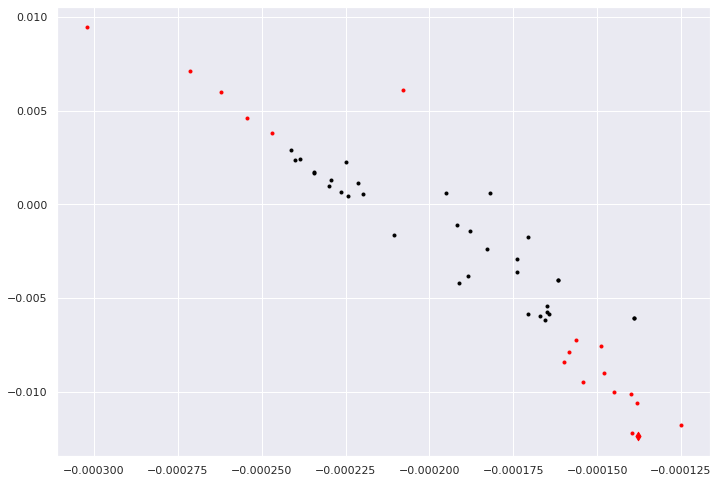

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.004491541518931167
fowlkes_mallows_score: 0.24341449493917153
homogeneity_completeness_v_measure: 0.26663774719598465 0.03199100819170762 0.05712785658361129


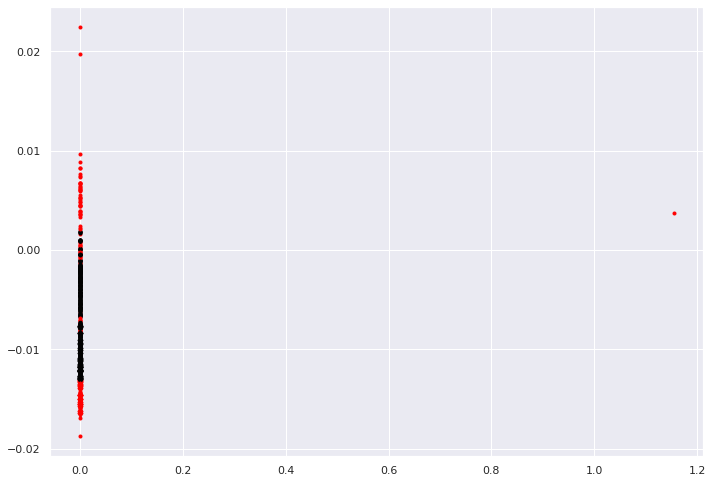

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: -0.024004956691444174
fowlkes_mallows_score: 0.5458667203201772
homogeneity_completeness_v_measure: 0.18793466478313312 0.026087392103360866 0.04581514037696989


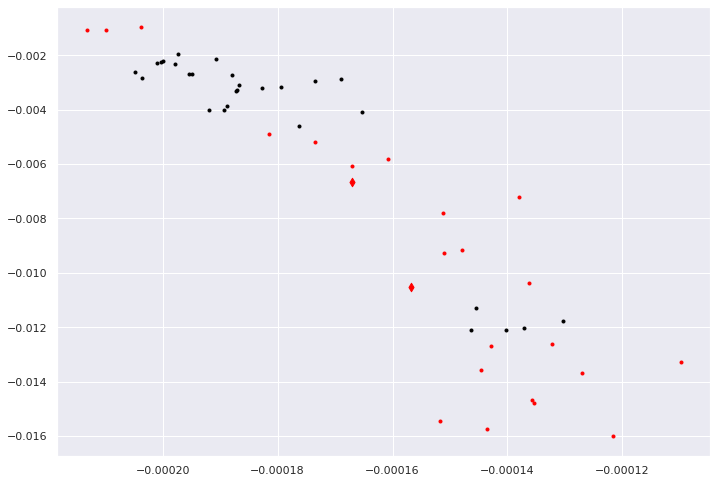

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.002586253615151275
fowlkes_mallows_score: 0.4312250517282548
homogeneity_completeness_v_measure: 0.11507829436107352 0.008722564105639301 0.016216007096622614


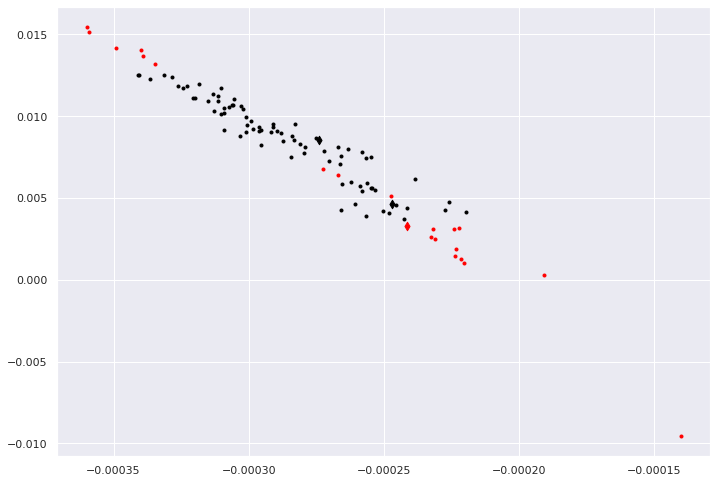

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: -0.00409588084710263
fowlkes_mallows_score: 0.5567989582528712
homogeneity_completeness_v_measure: 0.20404648720117044 0.018061381448367716 0.03318532982147441


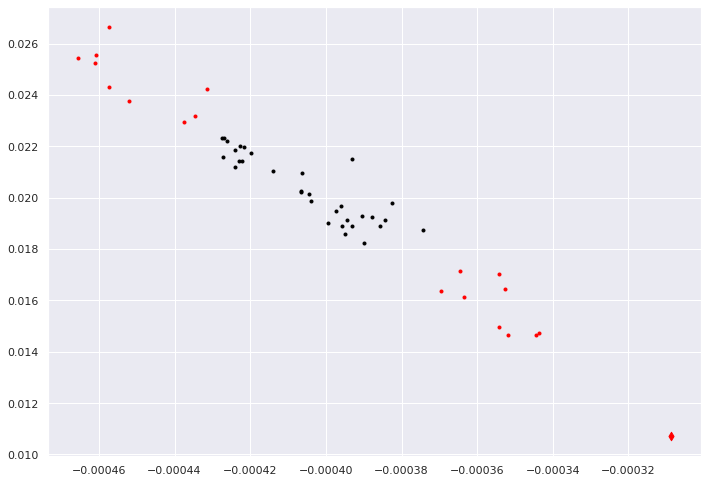

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.2882136678200692
fowlkes_mallows_score: 0.8392935401022902
homogeneity_completeness_v_measure: 0.2368660969111213 0.13052893566227938 0.16830864210506166


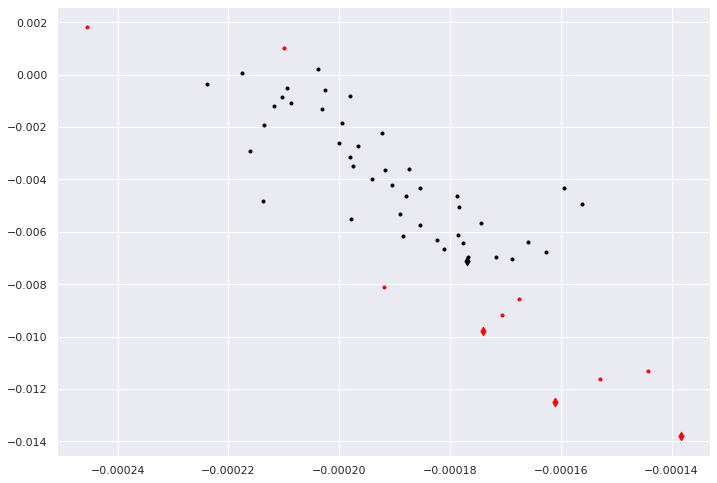

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: -0.01259752670050476
fowlkes_mallows_score: 0.4456180612522319
homogeneity_completeness_v_measure: 0.21533959051027837 0.012289206910581458 0.02325147620867924


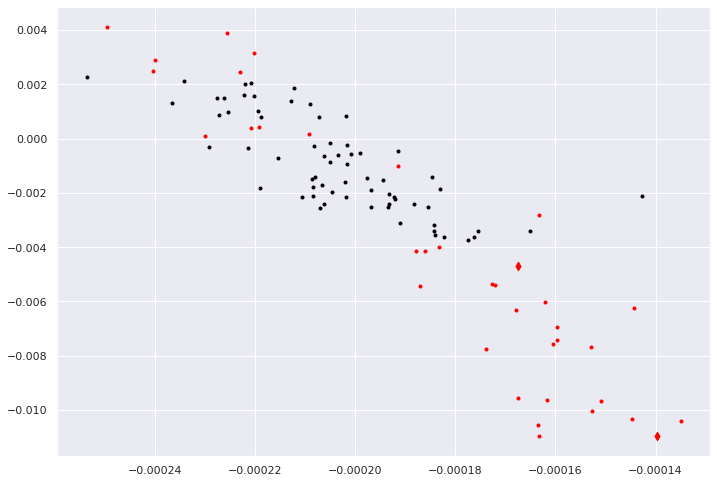

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.48514723050979375
fowlkes_mallows_score: 0.8733105614616175
homogeneity_completeness_v_measure: 0.5476509550430787 0.3334001631612297 0.41447519671480704


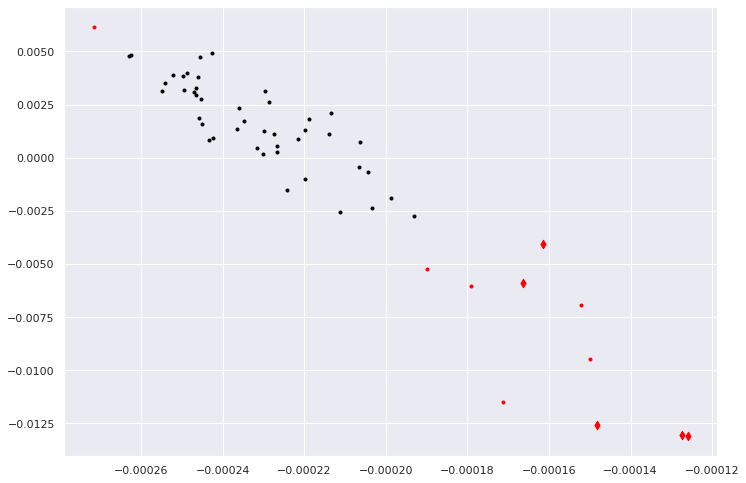

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.003412785348580122
fowlkes_mallows_score: 0.4360098167720465
homogeneity_completeness_v_measure: 0.1194289137611027 0.008108930158149797 0.015186719342152624


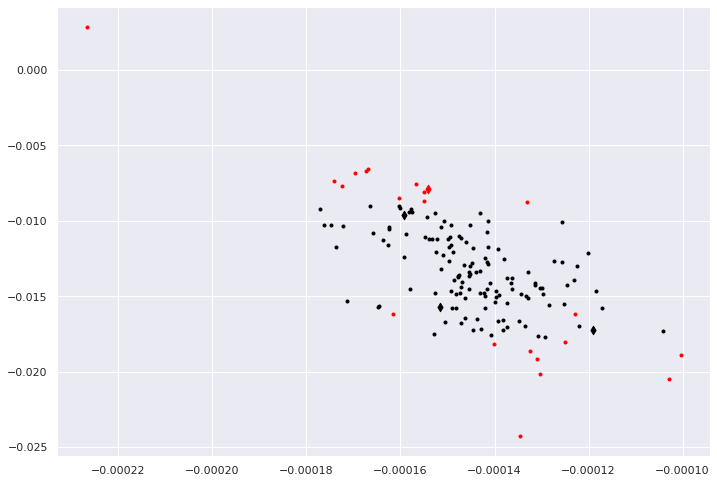

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


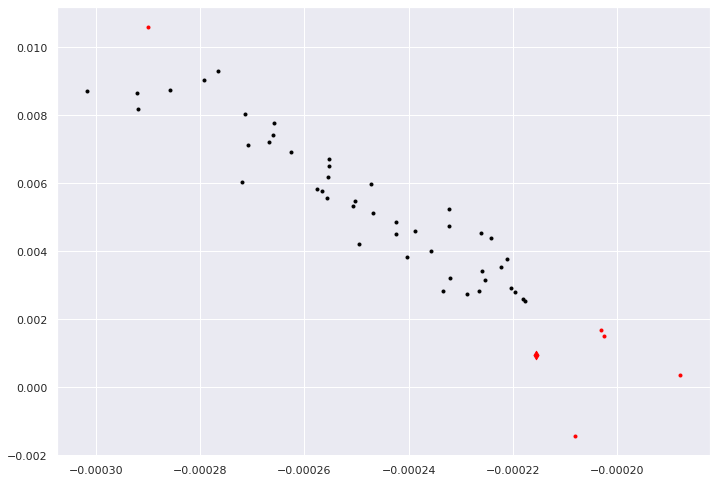

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


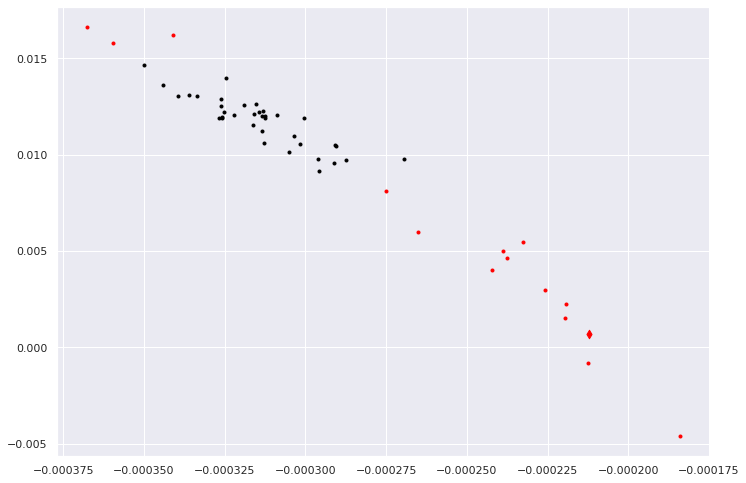

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.03334585304923901
fowlkes_mallows_score: 0.6536865598125899
homogeneity_completeness_v_measure: 0.3395249622165199 0.030874506183115175 0.05660194703068973


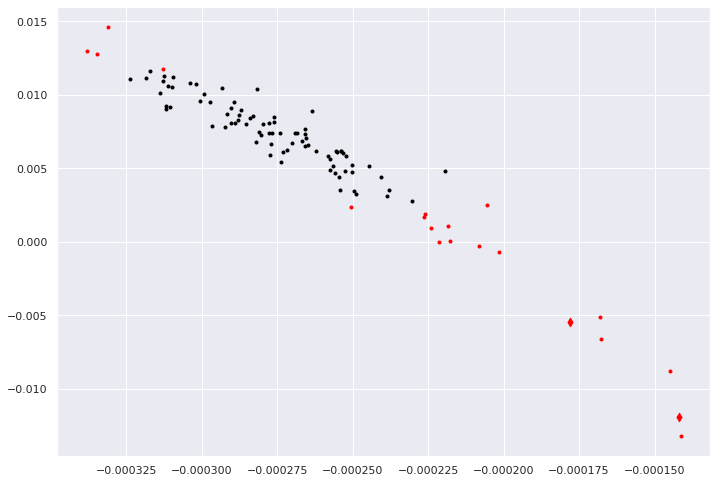

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.463618802318094
fowlkes_mallows_score: 0.9591678096644419
homogeneity_completeness_v_measure: 0.6120359227353217 0.2640240425582367 0.36890670710490103


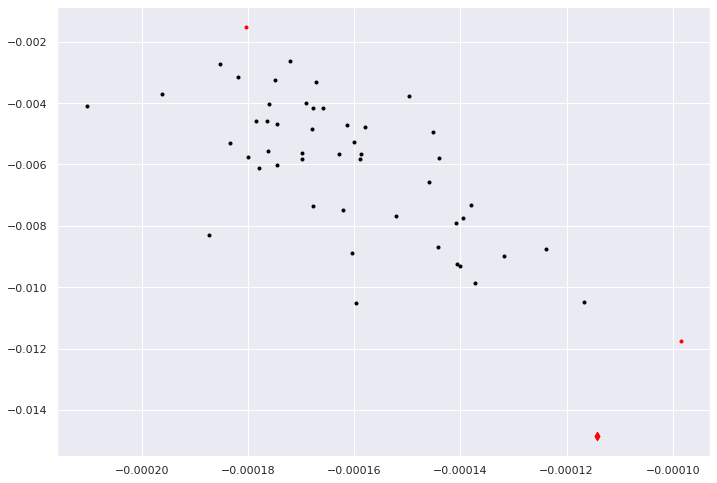

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.48514723050979375
fowlkes_mallows_score: 0.8733105614616175
homogeneity_completeness_v_measure: 0.5476509550430787 0.3334001631612297 0.41447519671480704


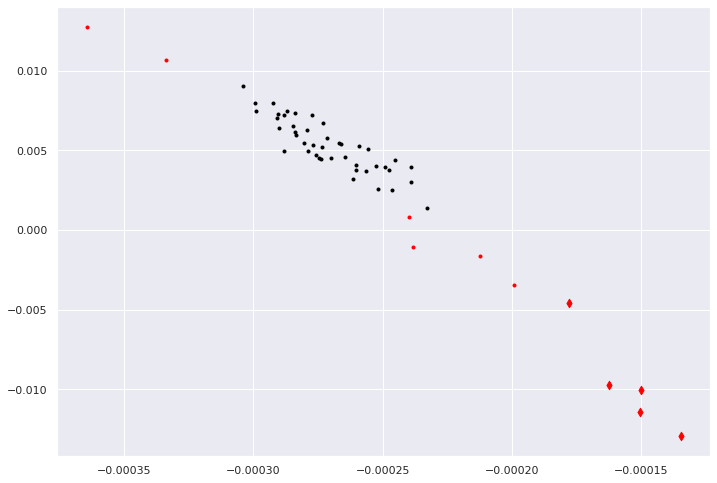

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.10645527860634511
fowlkes_mallows_score: 0.7070521745911096
homogeneity_completeness_v_measure: 0.2874215936196954 0.059075366775142316 0.09800683990318998


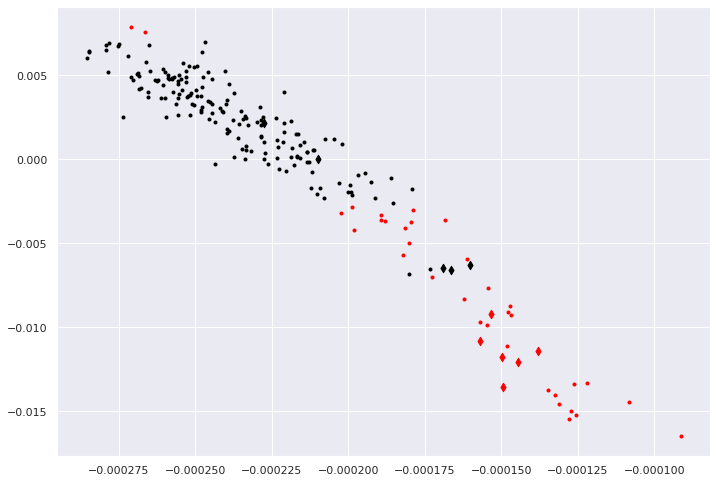

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.012136394065692013
fowlkes_mallows_score: 0.5006521613016784
homogeneity_completeness_v_measure: 0.19334832285060424 0.014147615879053353 0.026365988841000547


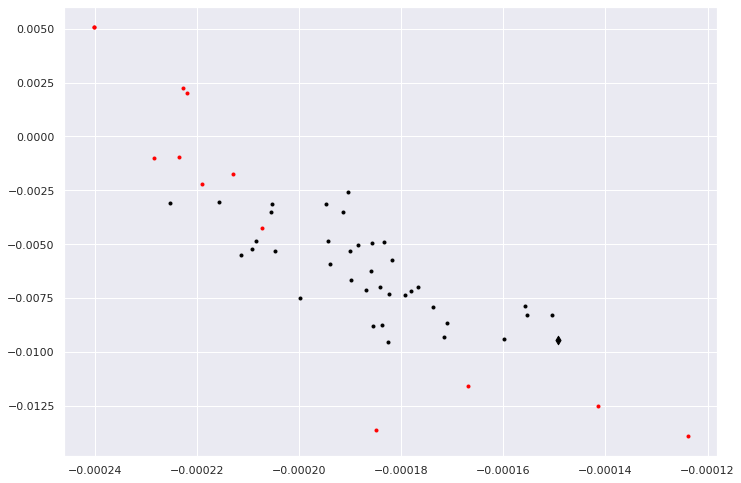

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030554876558298704
fowlkes_mallows_score: 0.7724251543501854
homogeneity_completeness_v_measure: 0.04991572095310778 0.007268431867307239 0.012689145469884784


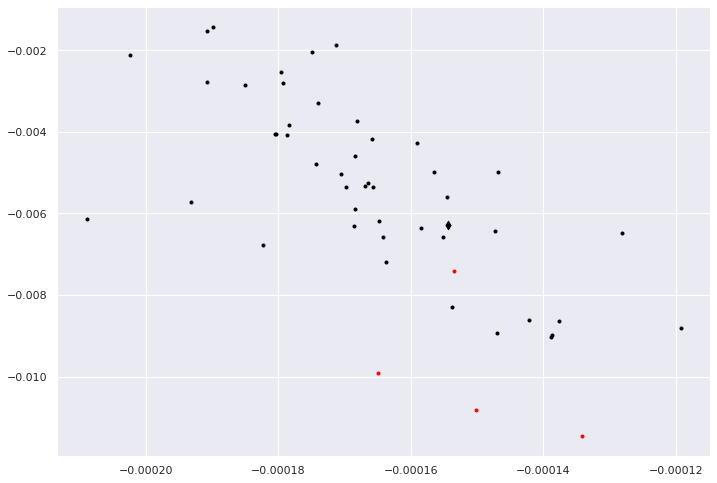

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.19871772851195924
fowlkes_mallows_score: 0.8274305664794127
homogeneity_completeness_v_measure: 0.38475973605640007 0.12156279062218335 0.18475364918441453


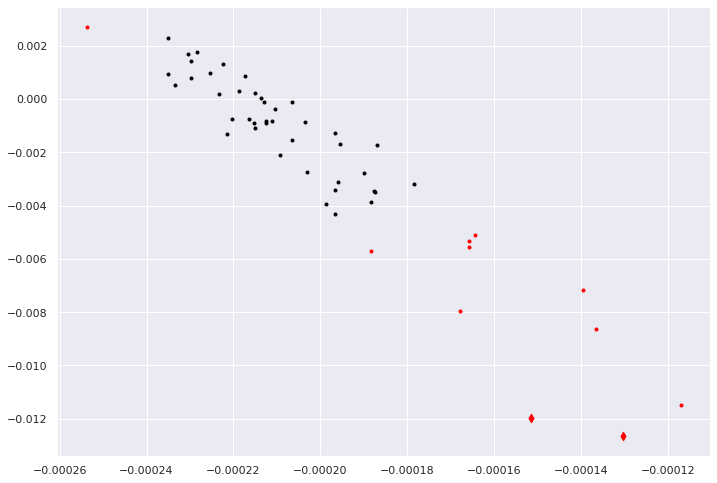

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.10302450511443079
fowlkes_mallows_score: 0.7808970907306446
homogeneity_completeness_v_measure: 0.6120359227353195 0.0837406476100007 0.14732397357100724


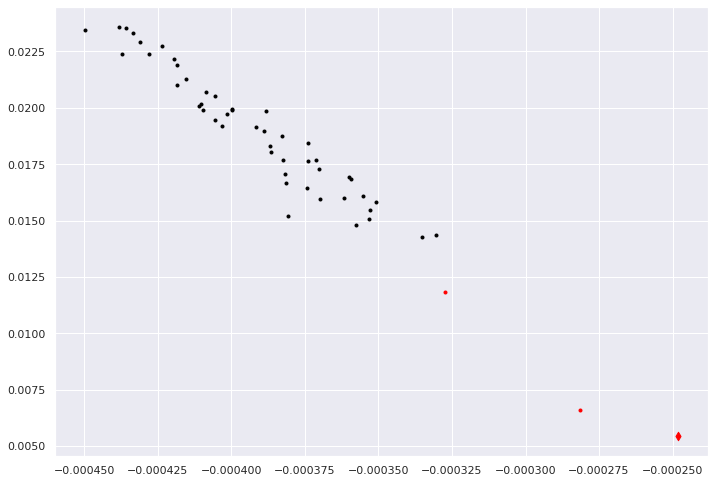

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.11061821676758368
fowlkes_mallows_score: 0.6408097721075376
homogeneity_completeness_v_measure: 0.3954974112715719 0.09757203843829332 0.15652759925621984


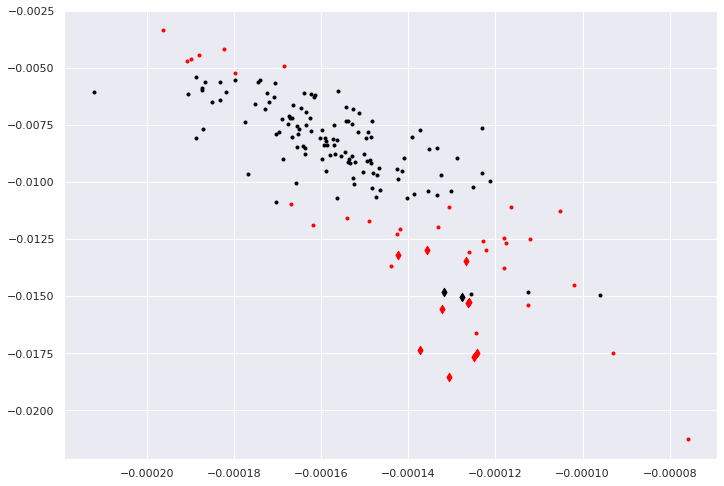

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.0018590039962870912
fowlkes_mallows_score: 0.34963486479507155
homogeneity_completeness_v_measure: 0.42214649234217894 0.021129873504969005 0.04024533077331895


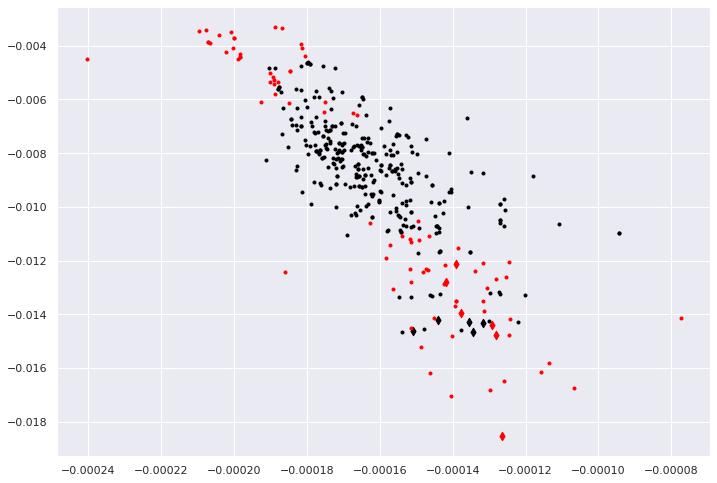

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.008565324262505558
fowlkes_mallows_score: 0.5468085390952384
homogeneity_completeness_v_measure: 0.29202608863634966 0.022963085409500317 0.04257809834558127


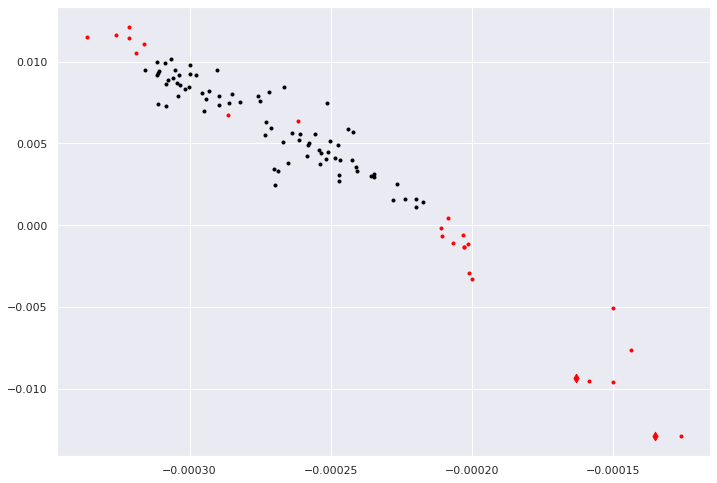

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.05464039642061441
fowlkes_mallows_score: 0.7287869896091596
homogeneity_completeness_v_measure: 0.019770989592930634 0.00991279231116835 0.013204901872286626


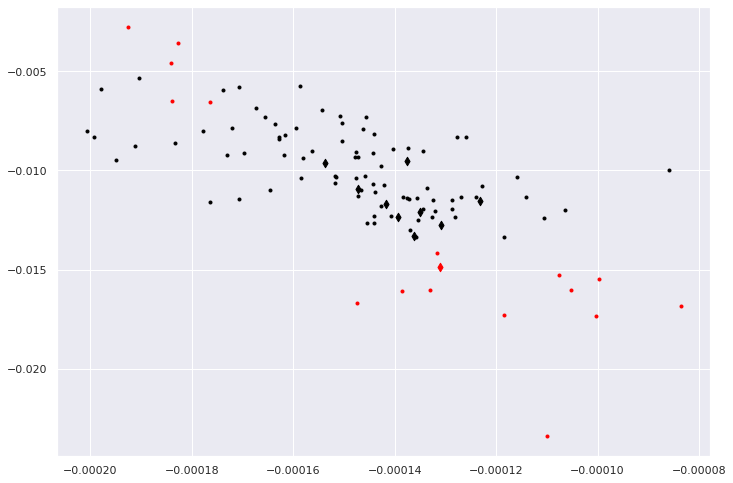

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.04460992414225068
fowlkes_mallows_score: 0.5780791447477034
homogeneity_completeness_v_measure: 0.06827836088337949 0.020189961901704096 0.0311645448121611


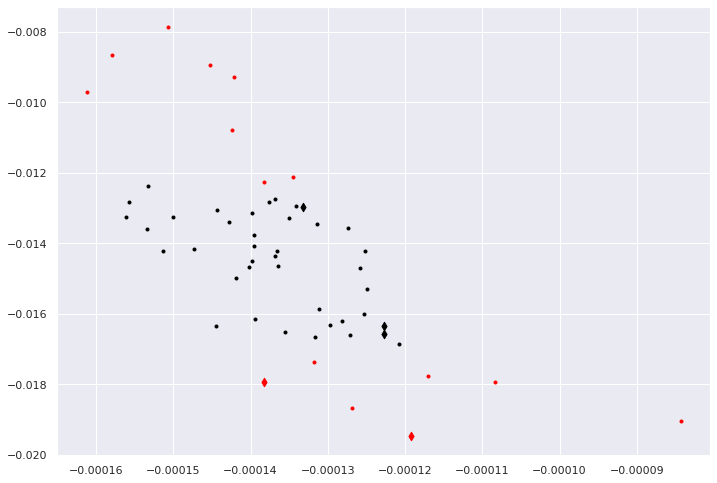

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


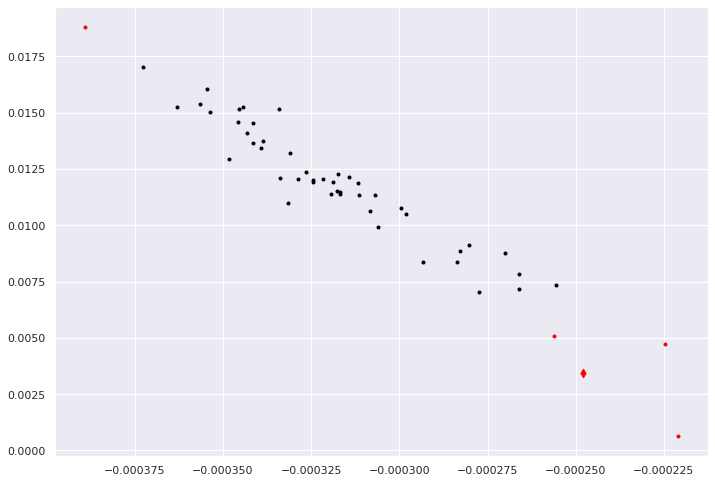

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.11796227763199936
fowlkes_mallows_score: 0.6356714724138868
homogeneity_completeness_v_measure: 0.49432672789014276 0.12949702539006835 0.20523053345108933


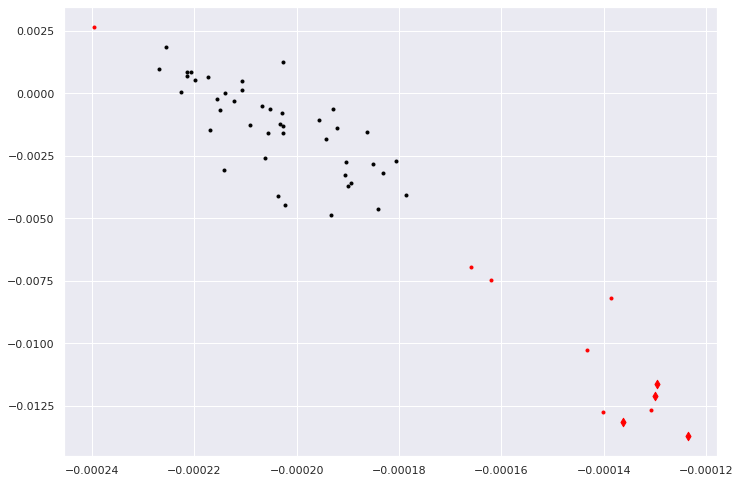

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.005392427648280284
fowlkes_mallows_score: 0.43970490594723505
homogeneity_completeness_v_measure: 0.18885920160610656 0.019917871895877137 0.03603531097405025


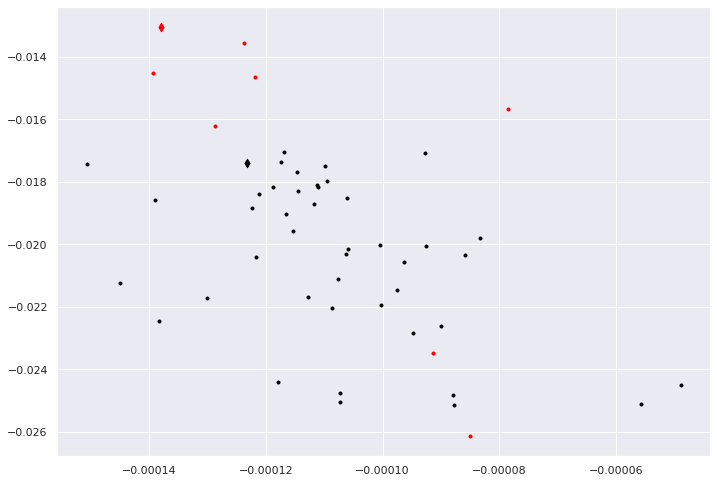

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.008837336093390692
fowlkes_mallows_score: 0.3717896704328028
homogeneity_completeness_v_measure: 0.35044415794813105 0.04373858745655727 0.07777069204446


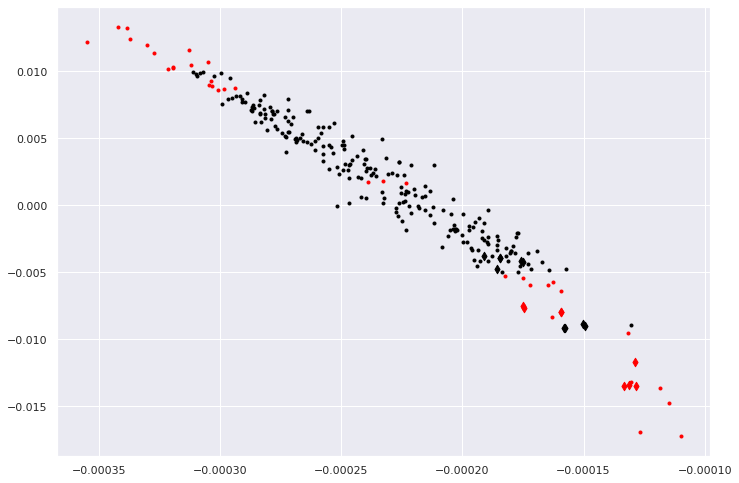

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.003904345378735766
fowlkes_mallows_score: 0.5019113216762222
homogeneity_completeness_v_measure: 0.3056394381697199 0.028069613365883143 0.0514171300976802


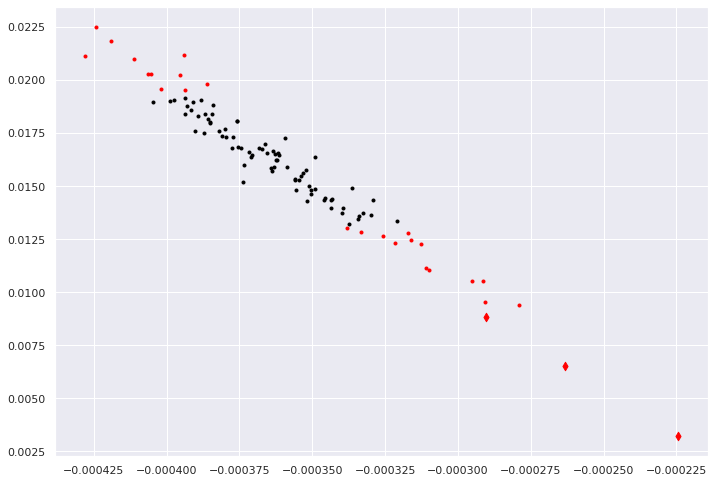

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.10498570407433881
fowlkes_mallows_score: 0.7741704957902397
homogeneity_completeness_v_measure: 0.05690690909825109 0.028367397129162614 0.03786136671644444


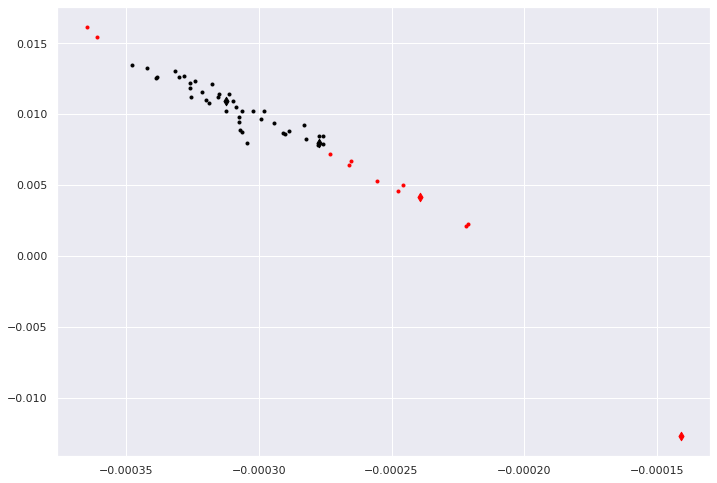

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.011956329120977351
fowlkes_mallows_score: 0.5241347610964183
homogeneity_completeness_v_measure: 0.33335812980637675 0.03272287675614845 0.05959575504746152


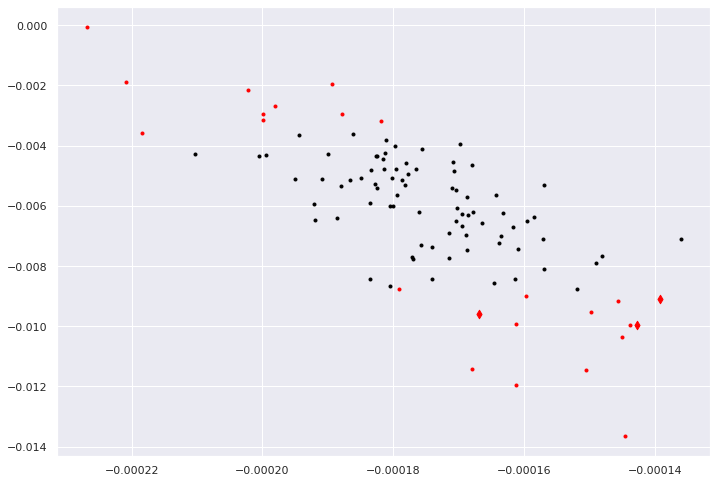

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.025313548031423716
fowlkes_mallows_score: 0.5664512045483249
homogeneity_completeness_v_measure: 0.4507535814407437 0.035472345827660505 0.0657689605889579


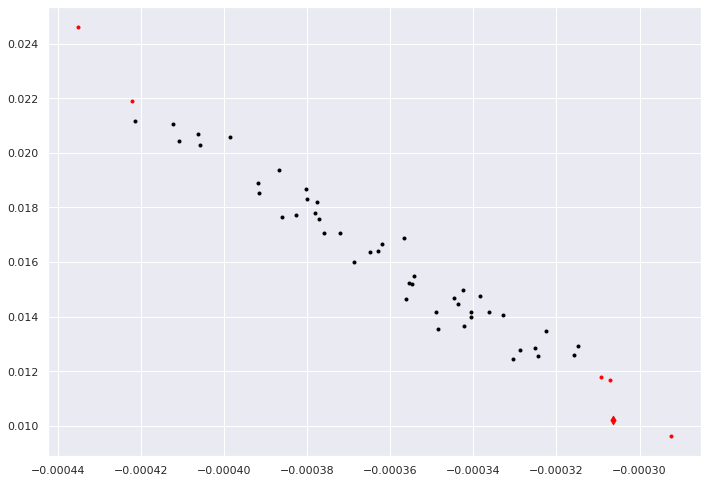

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.049766718506998445
fowlkes_mallows_score: 0.6349807811245665
homogeneity_completeness_v_measure: 0.35168984285346 0.05286597687294521 0.09191526208331163


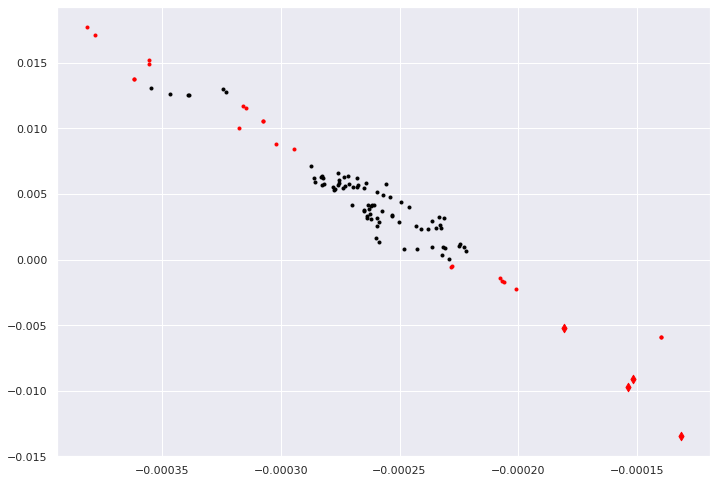

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.022443890274314215
fowlkes_mallows_score: 0.6001200360120043
homogeneity_completeness_v_measure: 0.3395249622165191 0.027934246723595554 0.051621370931114074


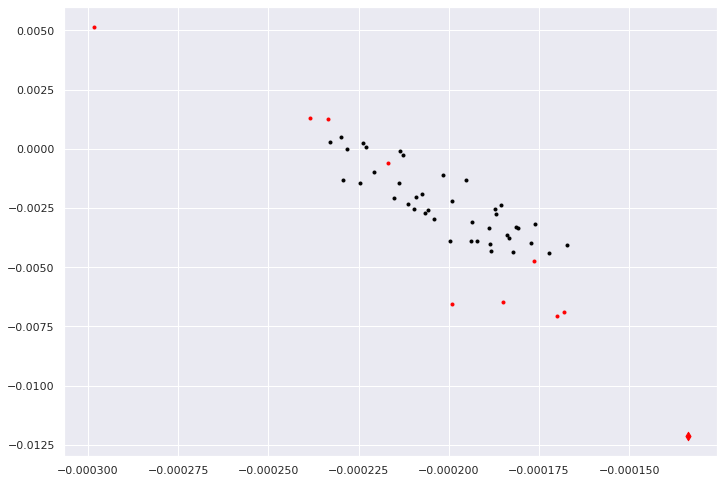

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.1429029608769728
fowlkes_mallows_score: 0.6735240038698848
homogeneity_completeness_v_measure: 0.7081092142671565 0.1549036853795666 0.2541995072984729


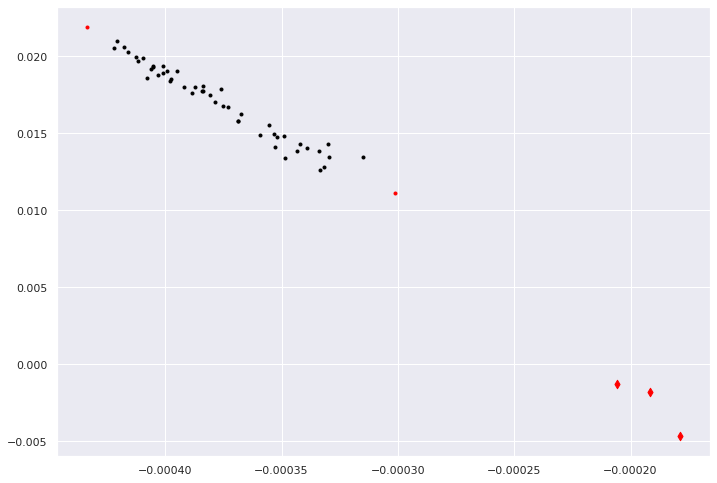

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.04888060316510986
fowlkes_mallows_score: 0.46150276889994696
homogeneity_completeness_v_measure: 0.5395673608280694 0.0646687442783877 0.1154950635470793


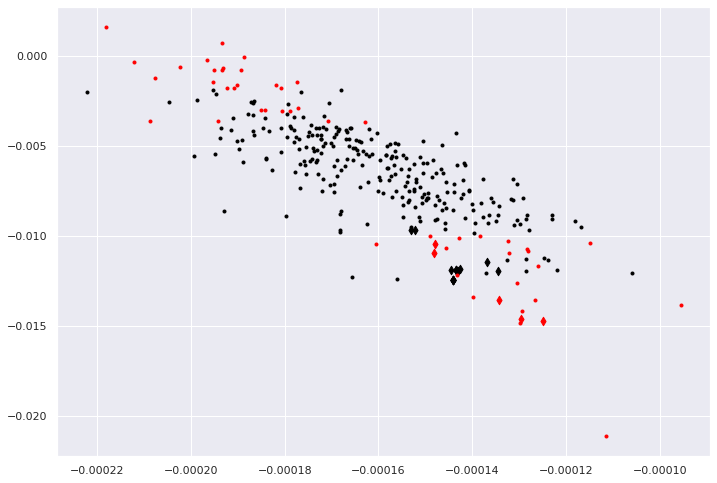

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.04731373840993156
fowlkes_mallows_score: 0.5027261836139565
homogeneity_completeness_v_measure: 0.6864319247955517 0.0773128529331049 0.13897315437791796


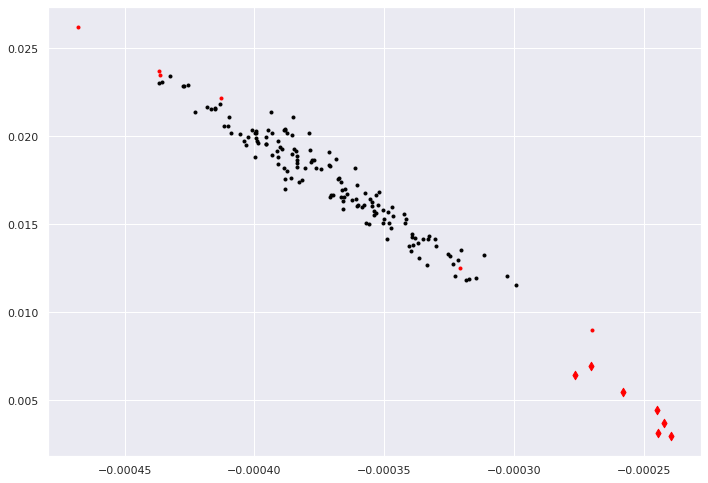

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


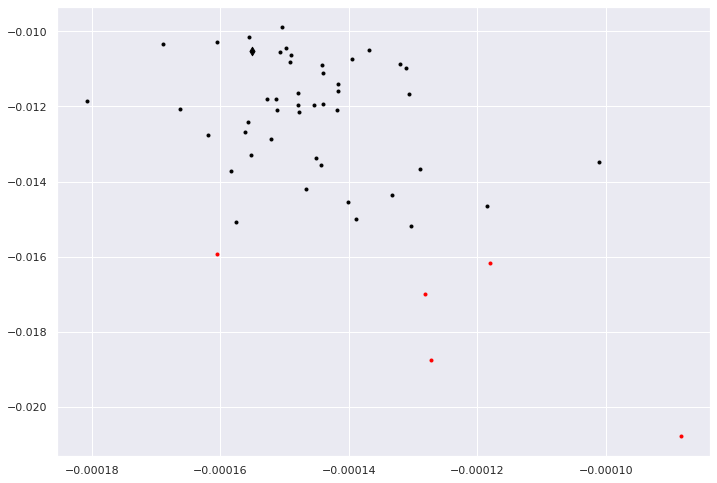

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.028976175144880875
fowlkes_mallows_score: 0.9209370289426528
homogeneity_completeness_v_measure: 0.012443374527241603 0.005367903947640151 0.007500285770158736


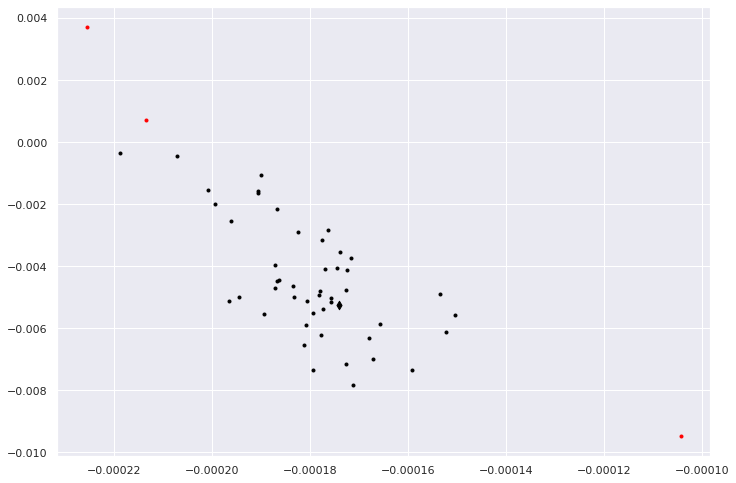

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.3549973651853153
fowlkes_mallows_score: 0.9393911530907418
homogeneity_completeness_v_measure: 0.5429987341208927 0.19061535127803197 0.2821753194438662


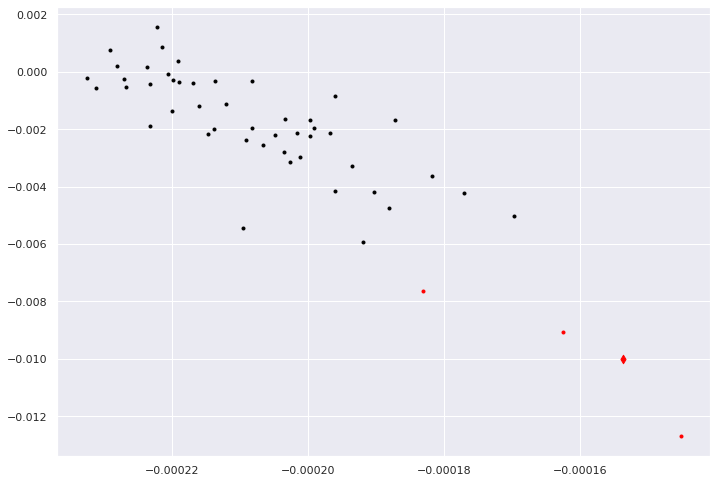

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.019260414411077186
fowlkes_mallows_score: 0.5763597086575862
homogeneity_completeness_v_measure: 0.3505205960463588 0.025821275329599075 0.048099292200024985


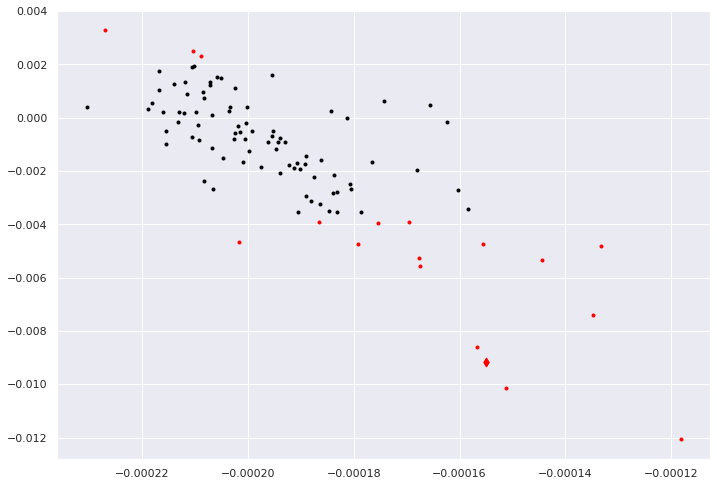

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.027984265130744725
fowlkes_mallows_score: 0.5835514576166512
homogeneity_completeness_v_measure: 0.34301898882815346 0.037828785603698234 0.06814266831799214


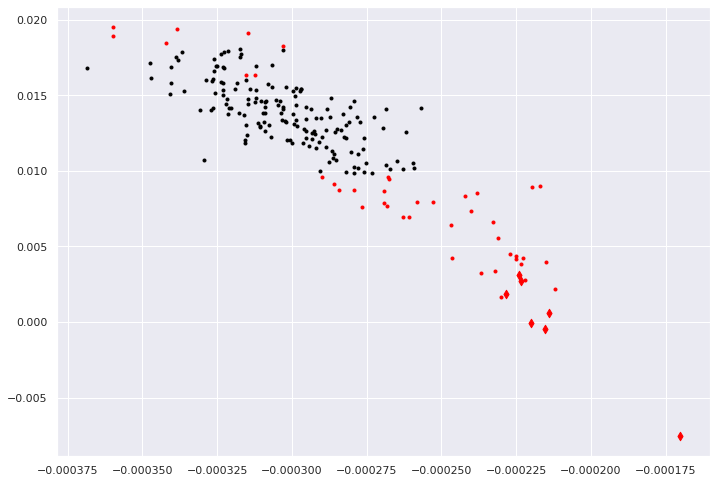

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.196557044980663
fowlkes_mallows_score: 0.8064460315902466
homogeneity_completeness_v_measure: 0.37966784432004447 0.08229767743589182 0.13527321981028295


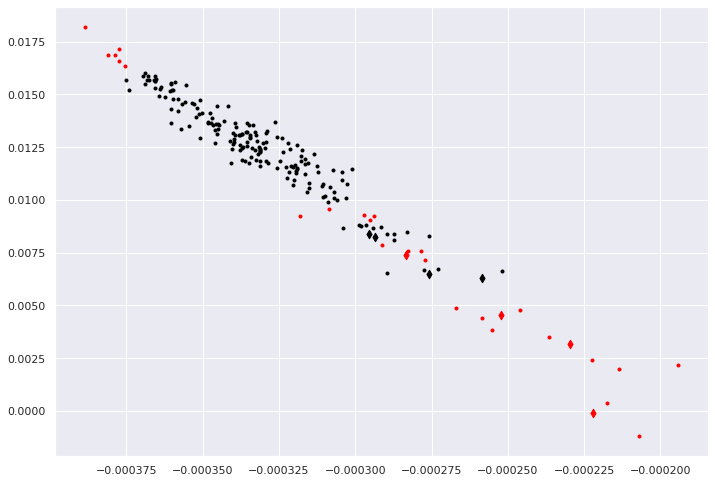

In [21]:
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
  if len(set(true_labels))> 1:
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df1[['comp-1','comp-2']])
    distances, indices = nbrs.kneighbors(df1[['comp-1','comp-2']])
    distances = np.sort(distances[:,1], axis=0)
    values.append({'eps':np.round(np.quantile(distances,0.95),5)})
print(len(values))
clustering_function(familyes,df_data, df, DBSCAN, params = values)

In [22]:

# from sklearn.cluster import KMeans

# # params for dbscan
# values = []
# familyes = sorted(set(family_lables))
# print(familyes)
# for i in familyes:    
#   df1= df.query('y==@i')
#   df_data1 = df_data.query('family_lable==@i')
#   true_labels = df_data1.is_RE.tolist()
# # print(len(familyes))
#   values.append({'n_clusters':2})
# clustering_function(familyes,df_data, df, KMeans, params=values)

# IsolationForest

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: -0.026399413346370082
fowlkes_mallows_score: 0.7734309162699123
homogeneity_completeness_v_measure: 0.05512581036683671 0.009751076938919133 0.0165709558682727


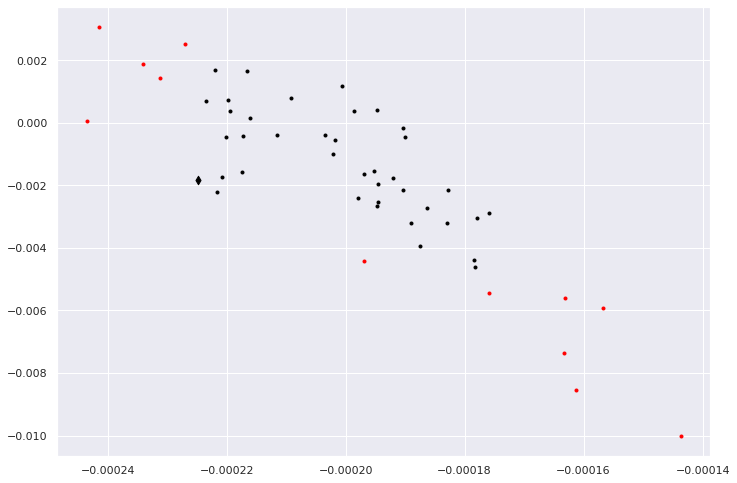

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


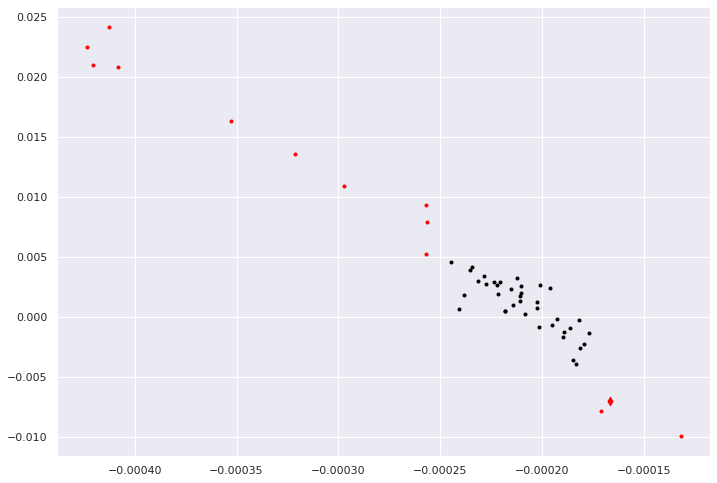

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.026399413346370082
fowlkes_mallows_score: 0.7734309162699123
homogeneity_completeness_v_measure: 0.05512581036683671 0.009751076938919133 0.0165709558682727


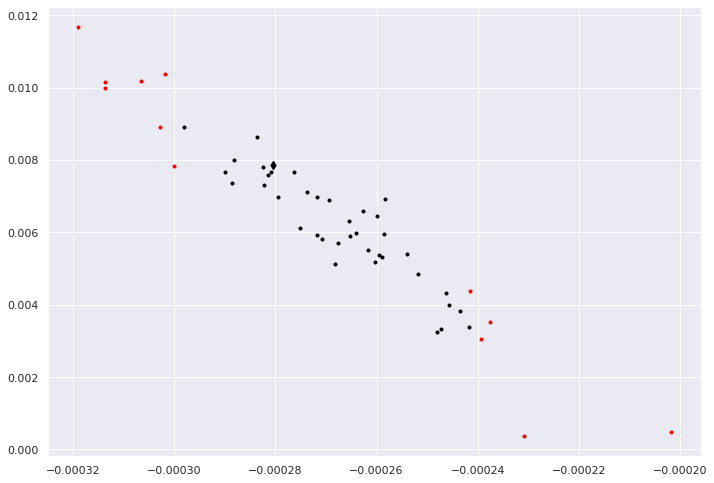

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.015596113238296344
fowlkes_mallows_score: 0.6984356212895007
homogeneity_completeness_v_measure: 0.001605267657666283 0.0006975132560034295 0.0009724724258474599


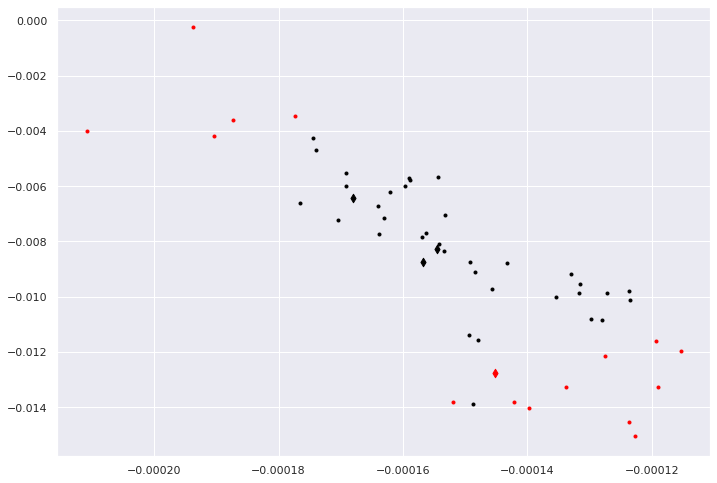

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.08011448916192537
fowlkes_mallows_score: 0.8021309786996907
homogeneity_completeness_v_measure: 0.13679199290838914 0.030743757619945508 0.050204208487591565


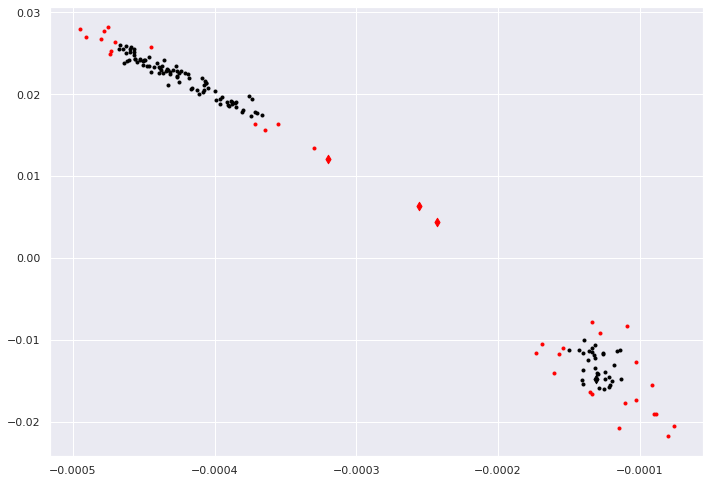

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


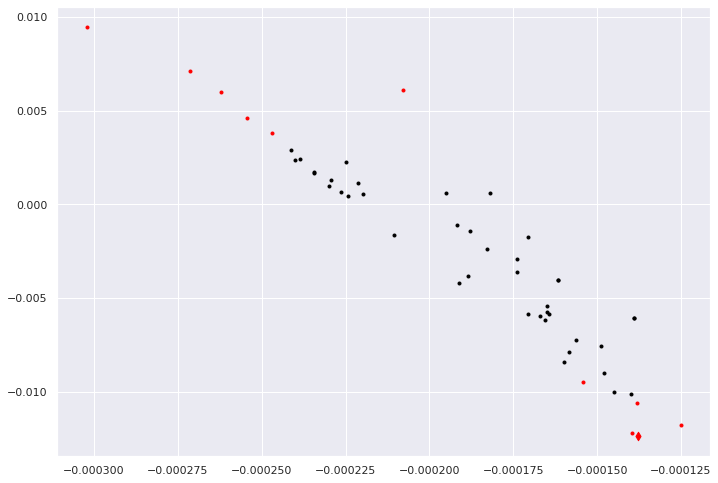

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.06572234336652932
fowlkes_mallows_score: 0.8006385297815325
homogeneity_completeness_v_measure: 0.010342621688172416 0.008710644279841367 0.009456740760128474


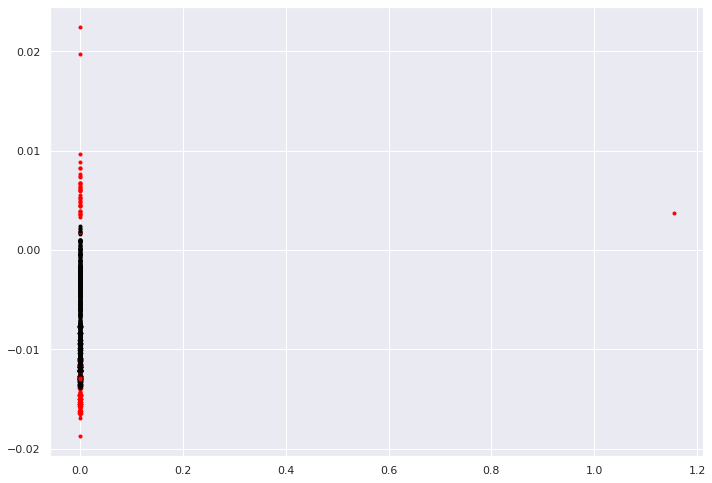

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.13005445360509107
fowlkes_mallows_score: 0.7804323062703838
homogeneity_completeness_v_measure: 0.3226998307586119 0.09031484659197692 0.14113099271521276


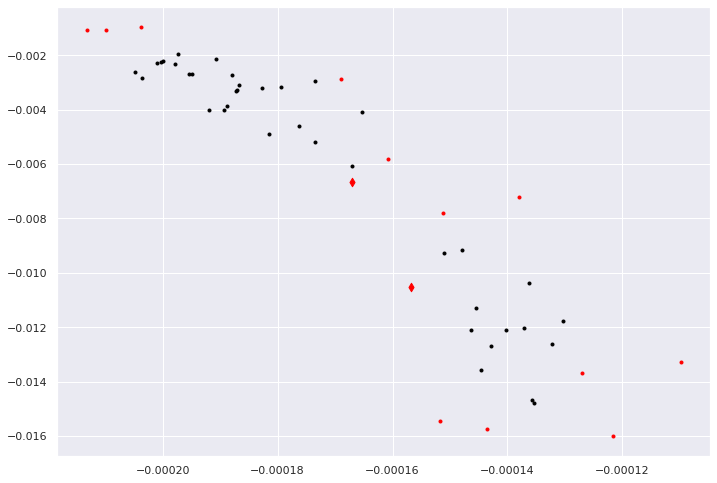

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.039316636343694755
fowlkes_mallows_score: 0.7948236495621211
homogeneity_completeness_v_measure: 0.04854145793495789 0.01298707672867092 0.02049168380717194


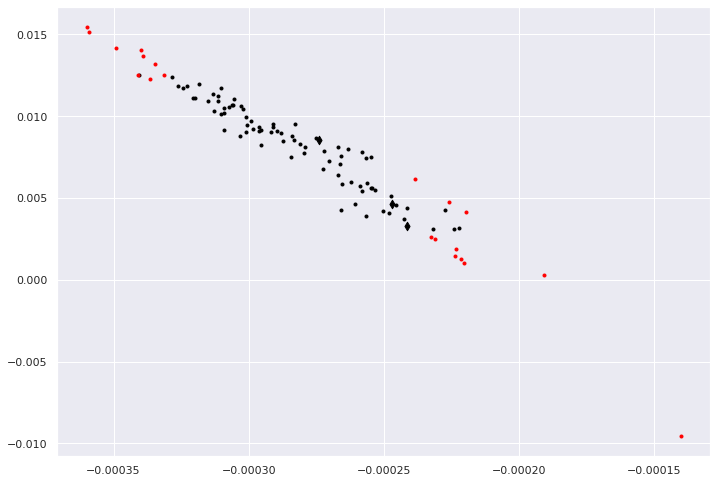

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.038901601830663615
fowlkes_mallows_score: 0.7369918385607233
homogeneity_completeness_v_measure: 0.22729774050744764 0.03446312714887227 0.05985150493957278


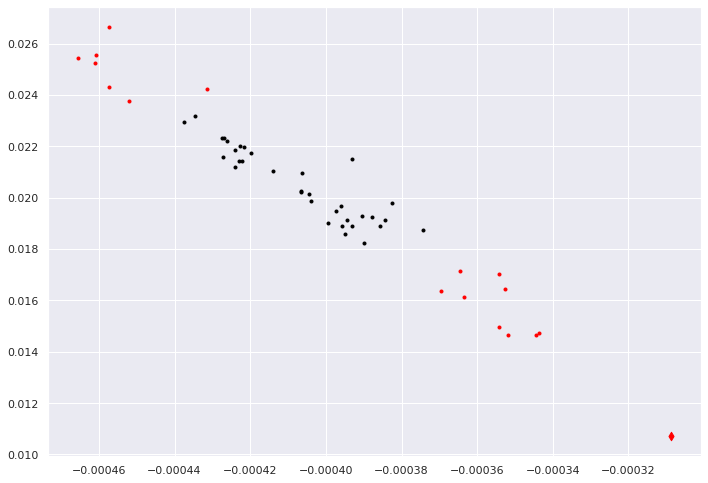

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.19008690678610018
fowlkes_mallows_score: 0.78752281060198
homogeneity_completeness_v_measure: 0.17777642280388187 0.08505070724032045 0.11505669515610126


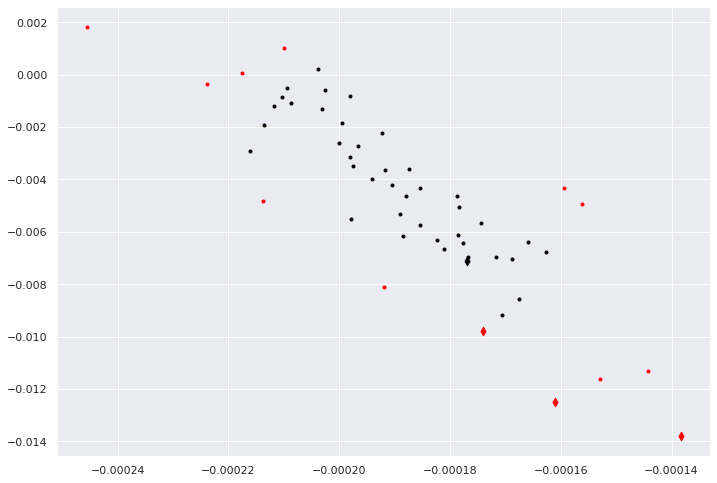

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.018520780057736278
fowlkes_mallows_score: 0.7629906142177129
homogeneity_completeness_v_measure: 0.023619202597489817 0.0038786658693917143 0.0066631342780236425


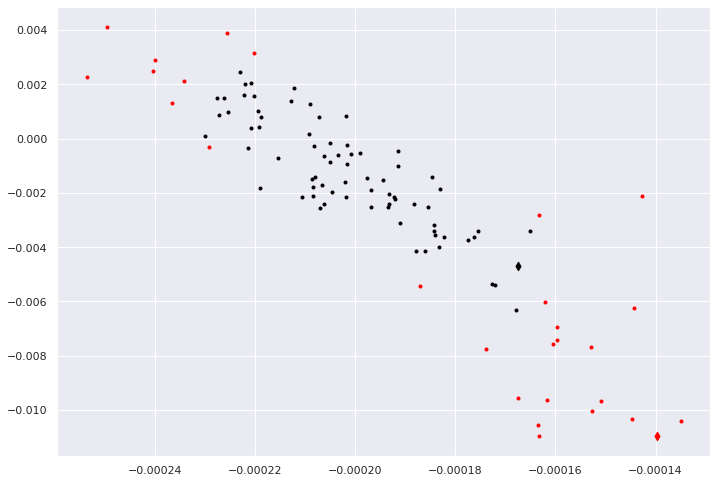

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.38578311662596526
fowlkes_mallows_score: 0.8348210990982834
homogeneity_completeness_v_measure: 0.48304223678623703 0.2690894500871971 0.3456351384583295


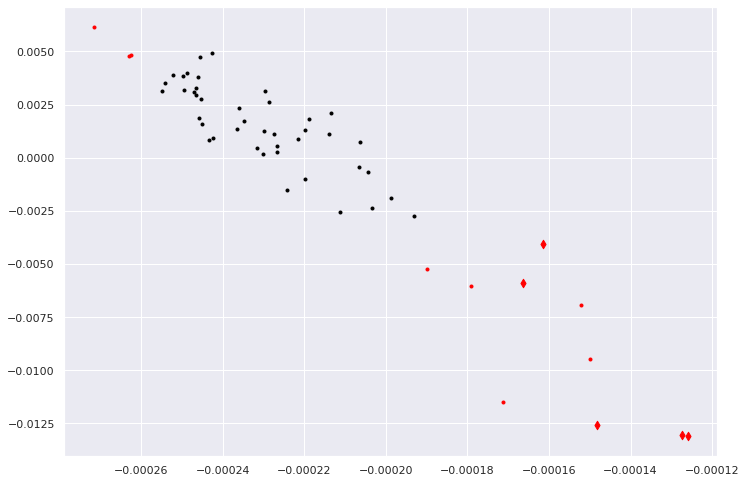

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.07272569372507105
fowlkes_mallows_score: 0.8386324908196792
homogeneity_completeness_v_measure: 0.06454078573666694 0.01712301116946717 0.027065422792559975


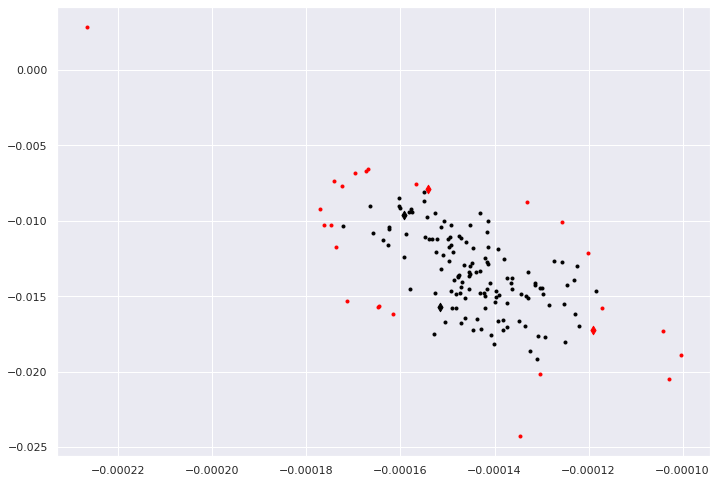

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


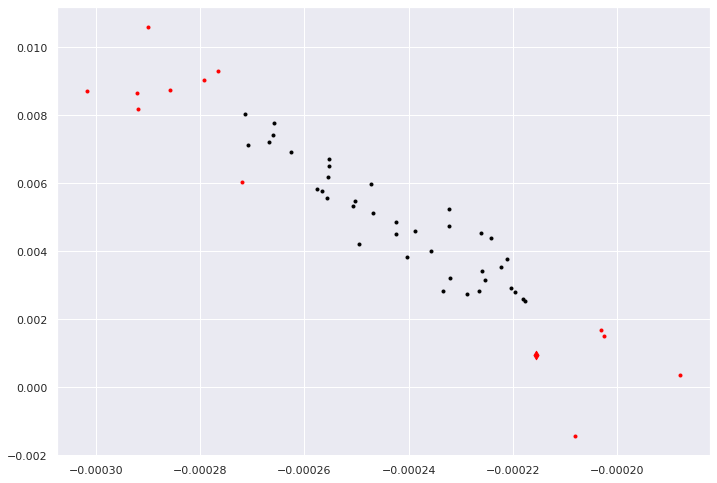

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.03249310752264671
fowlkes_mallows_score: 0.7269867224556095
homogeneity_completeness_v_measure: 0.2153395905102777 0.03200963072071838 0.055734485335997695


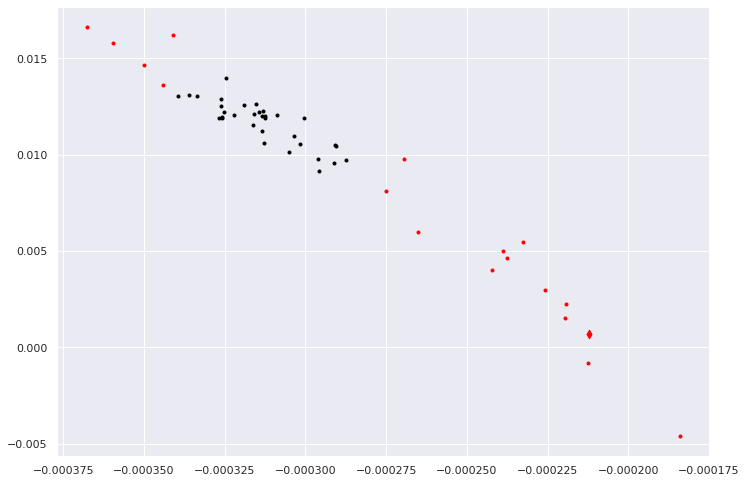

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.1266445973125107
fowlkes_mallows_score: 0.8415492257721544
homogeneity_completeness_v_measure: 0.3505205960463508 0.07036208825123418 0.11719826941348015


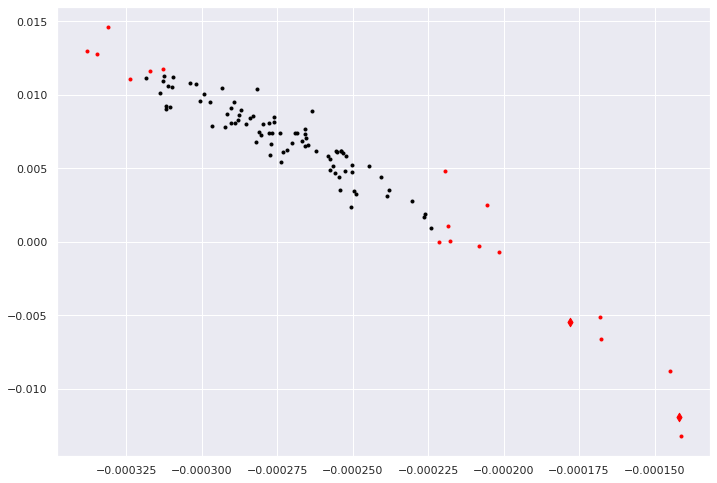

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.1364441819255759
fowlkes_mallows_score: 0.8480813153836058
homogeneity_completeness_v_measure: 0.3621462226994919 0.07500088265183384 0.12426611554323588


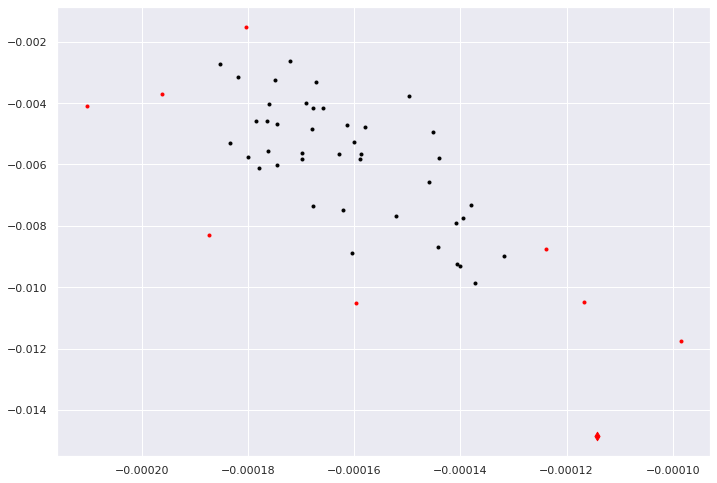

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.43268410819660946
fowlkes_mallows_score: 0.8537908749850147
homogeneity_completeness_v_measure: 0.5135585606554228 0.29822596452879213 0.3773328816750393


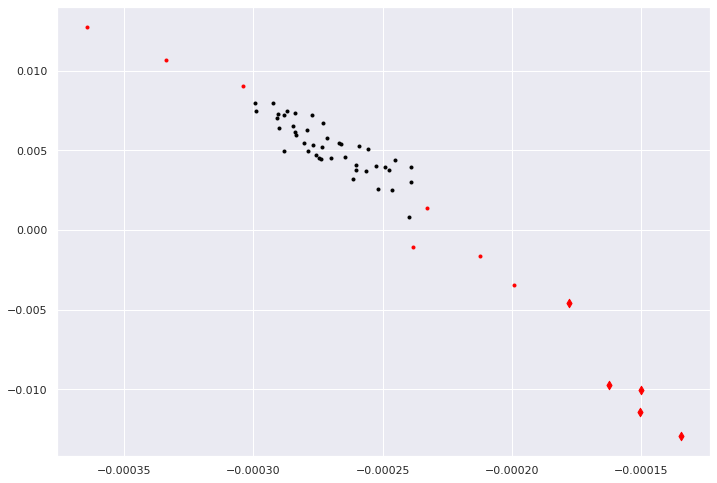

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.11064982475079813
fowlkes_mallows_score: 0.7598639722466453
homogeneity_completeness_v_measure: 0.16333947826691542 0.055614420604806494 0.08297664935419055


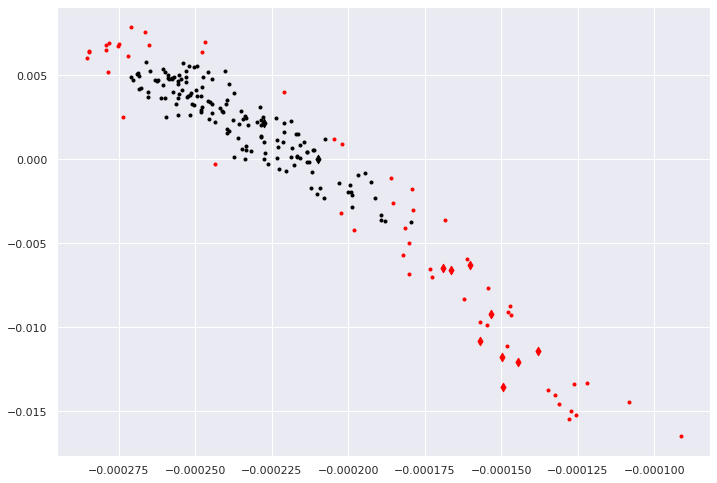

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


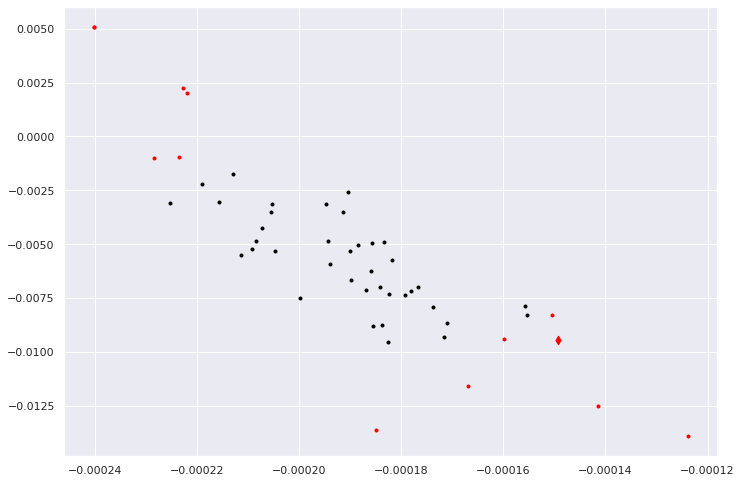

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


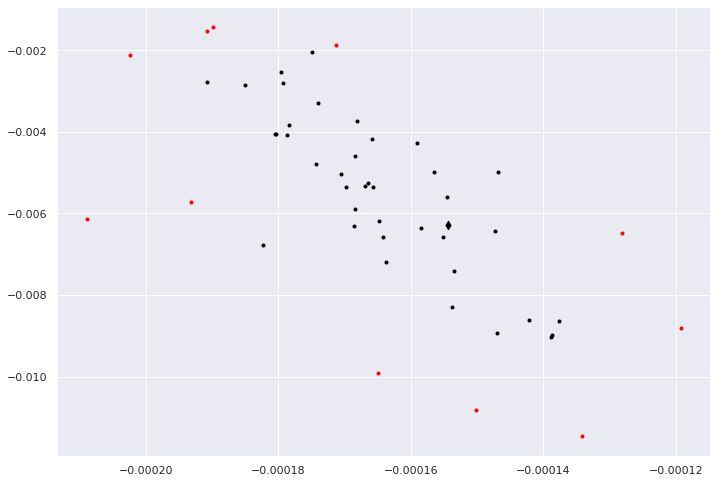

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.1725797824924229
fowlkes_mallows_score: 0.8110537389132709
homogeneity_completeness_v_measure: 0.3622049520856421 0.10930676253002375 0.16793411258973837


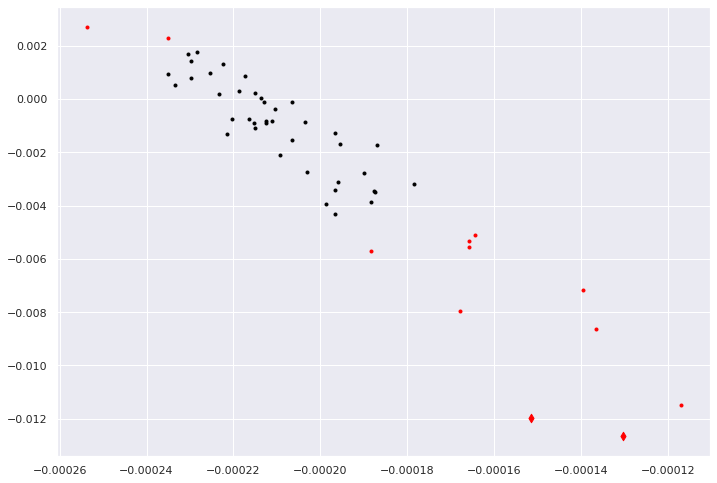

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


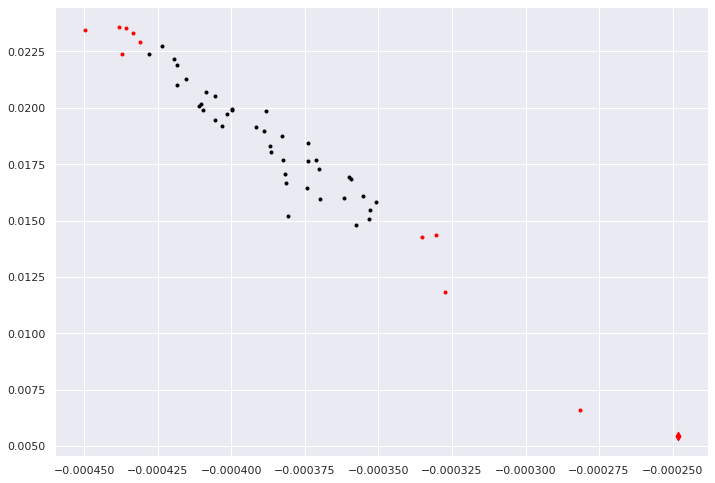

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.108603066439523
fowlkes_mallows_score: 0.7998265107917617
homogeneity_completeness_v_measure: 0.044190935257245954 0.024352137432371312 0.03140051026082722


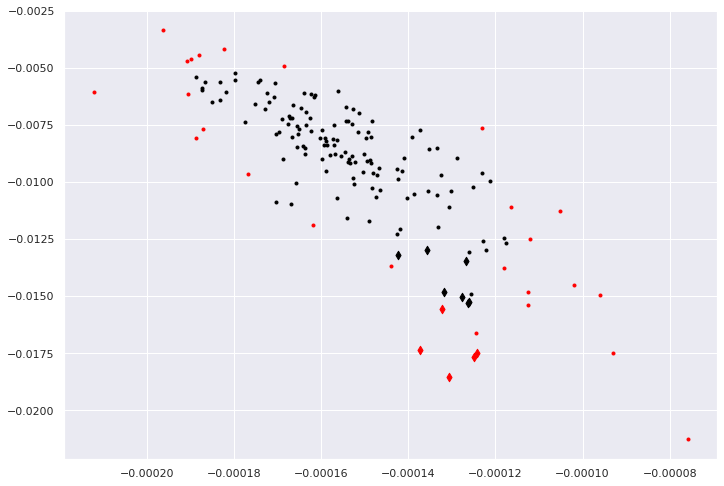

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.11974701422778451
fowlkes_mallows_score: 0.8416706033296982
homogeneity_completeness_v_measure: 0.16350635854472592 0.04310229294554474 0.06822075371597806


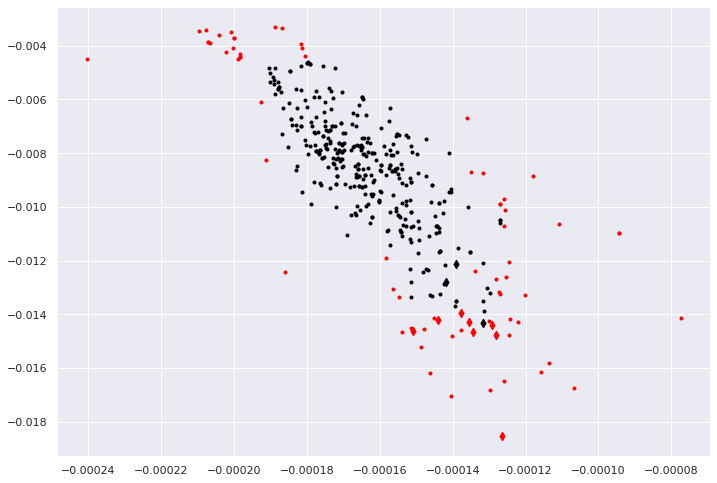

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.10054557302203161
fowlkes_mallows_score: 0.817831943928969
homogeneity_completeness_v_measure: 0.3191738423312055 0.05907845268009472 0.09970221986531402


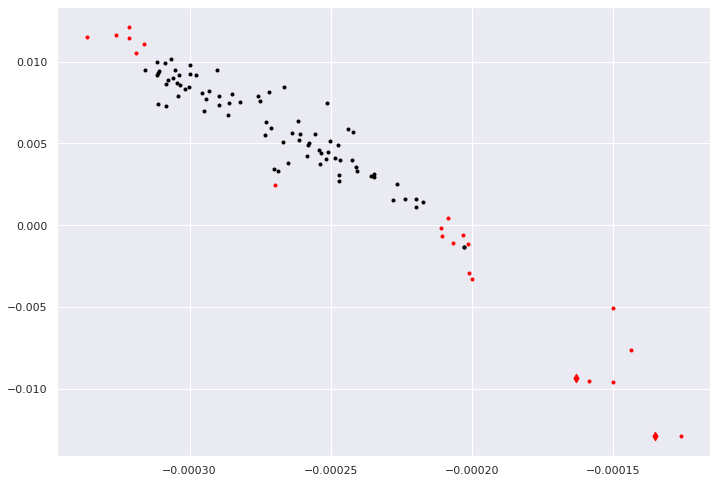

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.08894849129619391
fowlkes_mallows_score: 0.7218106017829736
homogeneity_completeness_v_measure: 0.0738536246323835 0.043878094914357686 0.05504984321752848


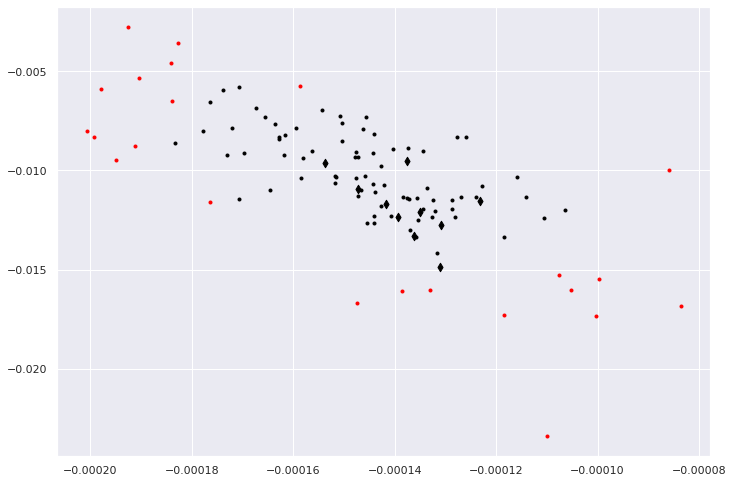

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.09638085354780127
fowlkes_mallows_score: 0.7734779432100835
homogeneity_completeness_v_measure: 0.03505825917668437 0.021342844784660014 0.02653291980033512


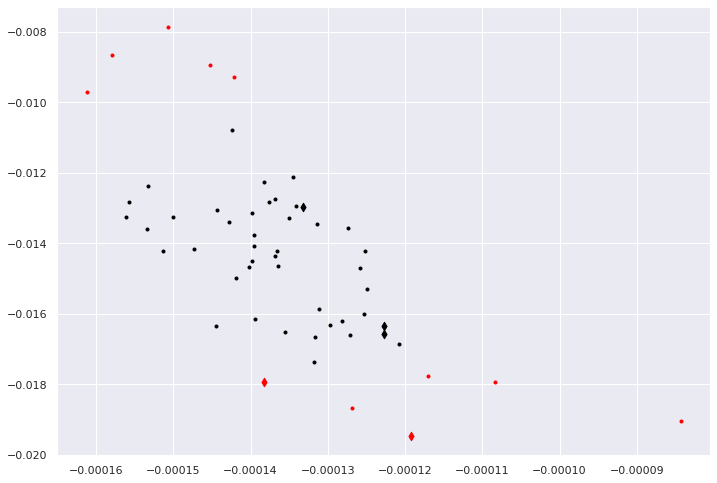

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.1364441819255759
fowlkes_mallows_score: 0.8480813153836058
homogeneity_completeness_v_measure: 0.3621462226994919 0.07500088265183384 0.12426611554323588


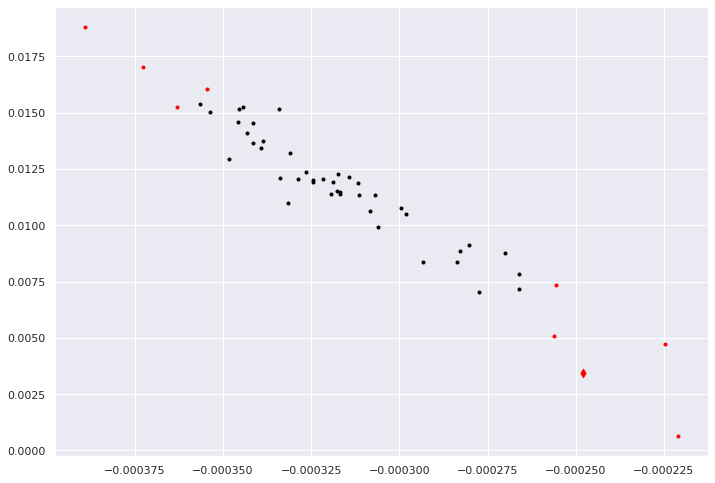

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.2708786882208532
fowlkes_mallows_score: 0.8025330374502632
homogeneity_completeness_v_measure: 0.412589565952766 0.19037007831954833 0.26053056363017024


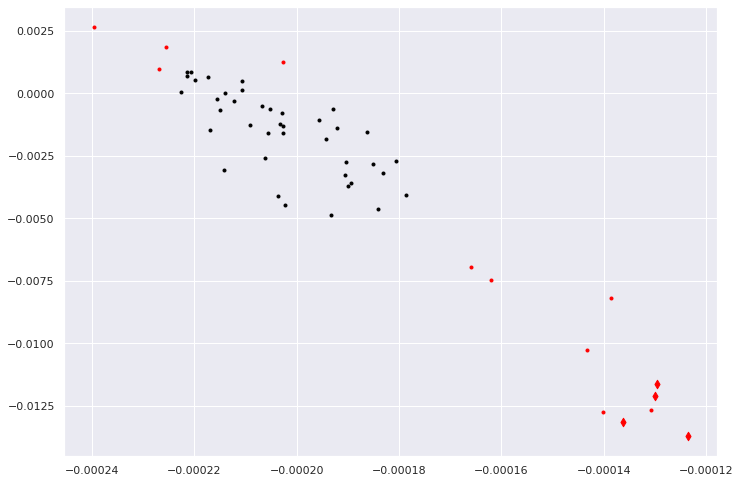

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.016945562380851514
fowlkes_mallows_score: 0.7193548703941065
homogeneity_completeness_v_measure: 0.0157005466749602 0.00405007682620113 0.006439130414612635


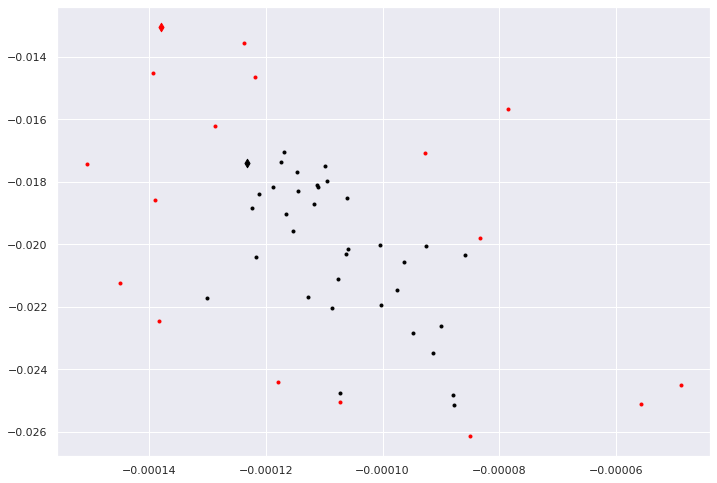

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.23473947301602238
fowlkes_mallows_score: 0.8368160746227363
homogeneity_completeness_v_measure: 0.17383567787748905 0.09106910896046039 0.11952264418328462


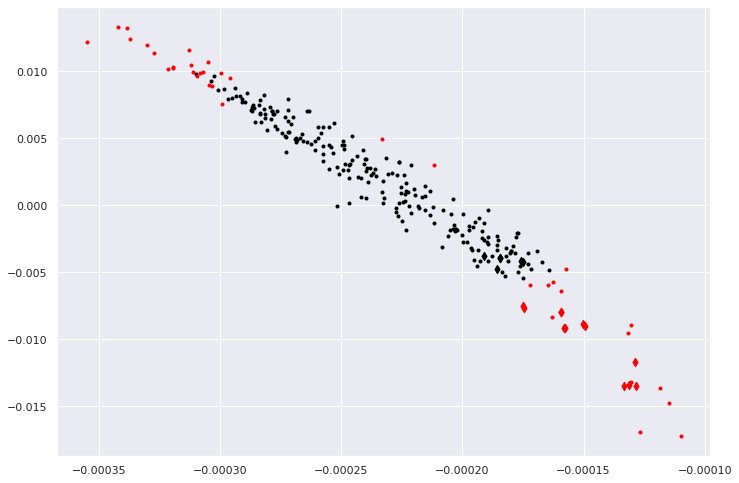

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.21881353249820434
fowlkes_mallows_score: 0.8651758418654288
homogeneity_completeness_v_measure: 0.4159648443156446 0.12228901611102179 0.18901093067056585


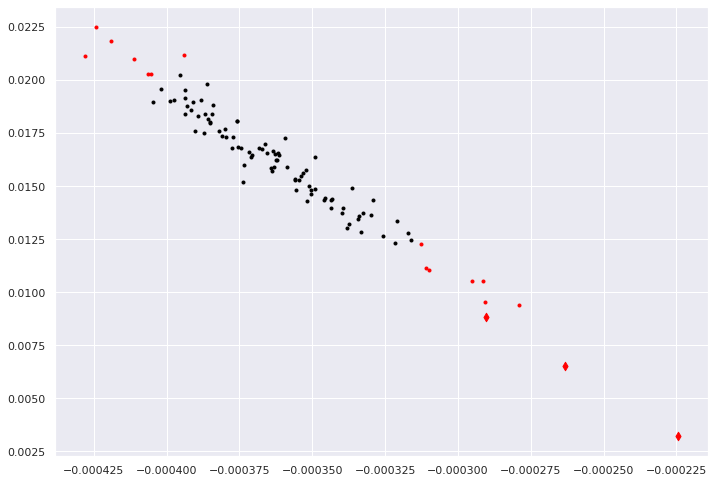

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.12534518383744928
fowlkes_mallows_score: 0.790088074845028
homogeneity_completeness_v_measure: 0.0669356294576737 0.034964775293402084 0.04593483703675432


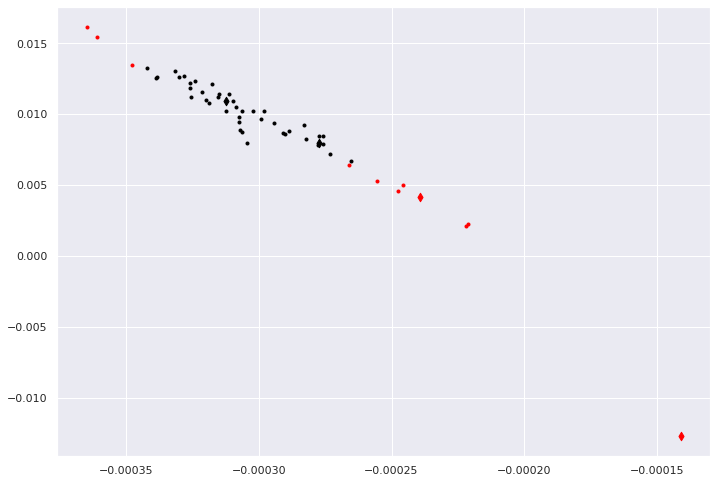

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.12098542150855694
fowlkes_mallows_score: 0.8003026382300061
homogeneity_completeness_v_measure: 0.32372684896302184 0.07692640594417868 0.12431269529622226


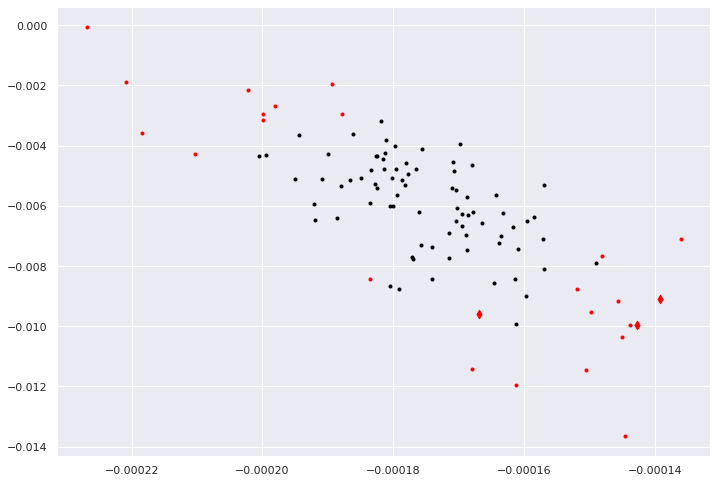

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


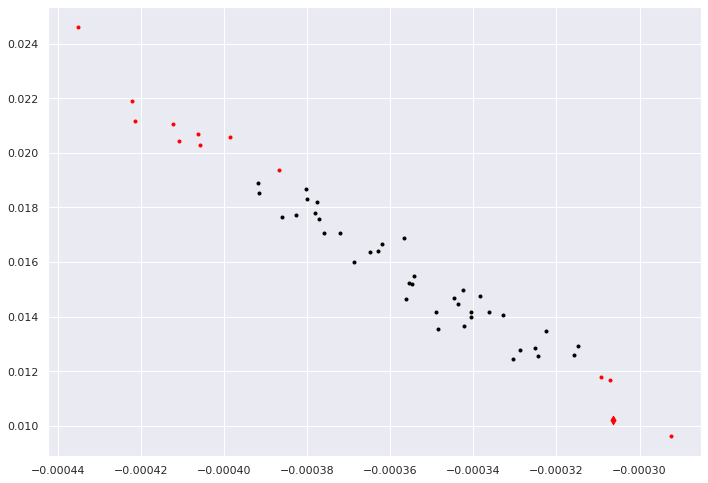

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.1222732062696549
fowlkes_mallows_score: 0.7759687201841287
homogeneity_completeness_v_measure: 0.31377892652806116 0.08642813826921789 0.1355264853291436


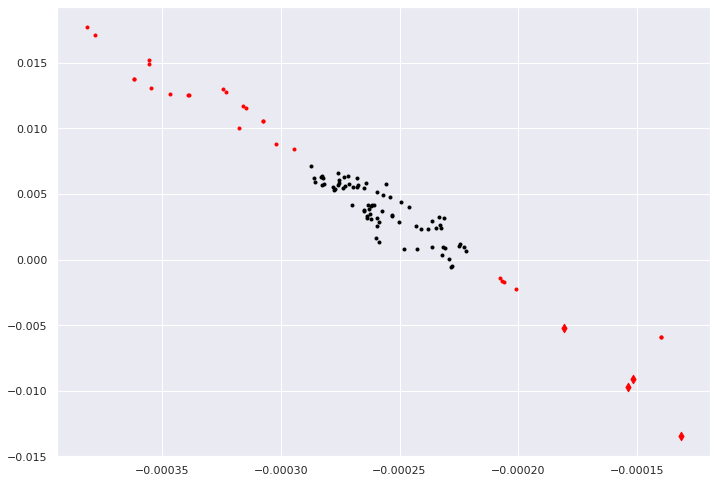

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.16080777860882572
fowlkes_mallows_score: 0.8652250534546901
homogeneity_completeness_v_measure: 0.38760917830812613 0.08610752365469332 0.14091150407680916


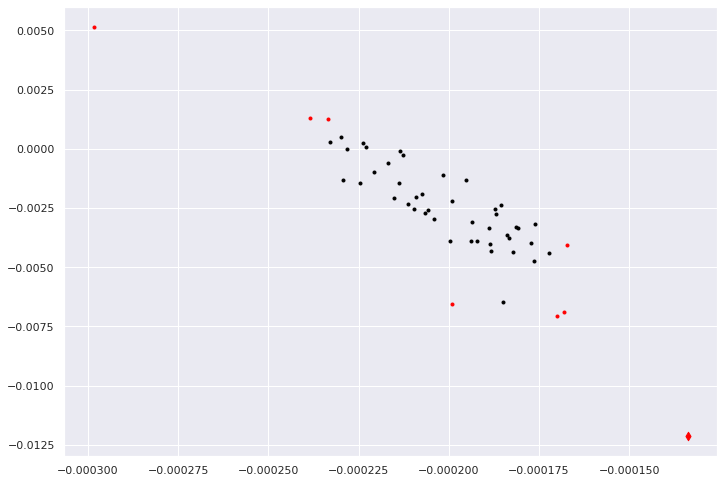

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.3866739900376901
fowlkes_mallows_score: 0.8778536245155478
homogeneity_completeness_v_measure: 0.5030892721804947 0.2401984273146218 0.3251533748202609


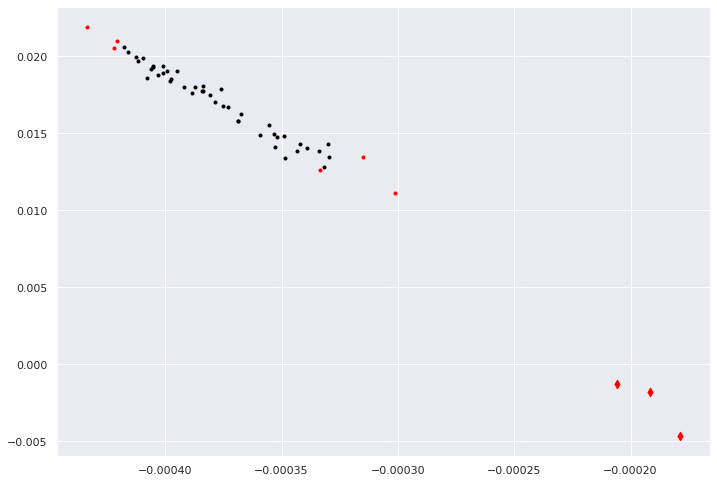

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.009955761109993968
fowlkes_mallows_score: 0.7919048745172027
homogeneity_completeness_v_measure: 0.0004954710831967139 0.0002524524430993002 0.0003344804142143313


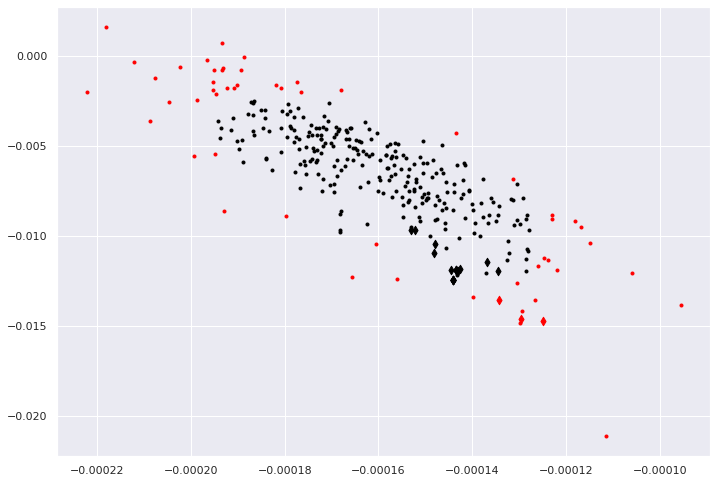

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.25528114917806116
fowlkes_mallows_score: 0.845695243067082
homogeneity_completeness_v_measure: 0.42129786020312304 0.15454026814682878 0.2261312027810298


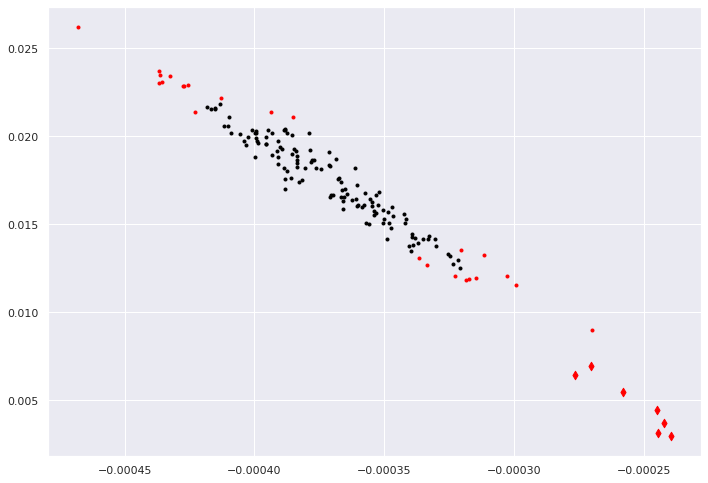

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.02841429880843263
fowlkes_mallows_score: 0.8014526153676969
homogeneity_completeness_v_measure: 0.04483591126959422 0.008743003913873719 0.014632642201502092


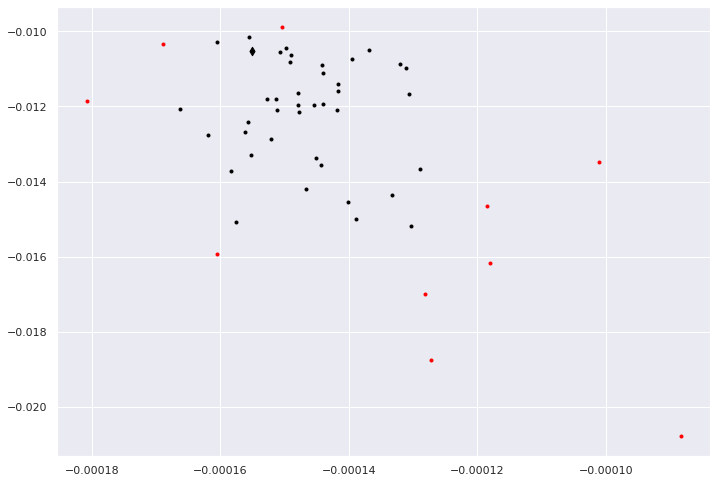

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.02923803898405198
fowlkes_mallows_score: 0.8166002316854517
homogeneity_completeness_v_measure: 0.03988002426815938 0.008259197066844632 0.013684350113148636


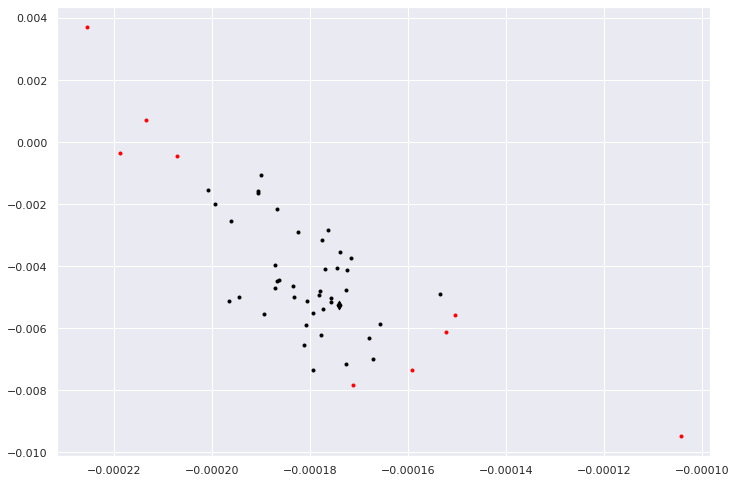

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


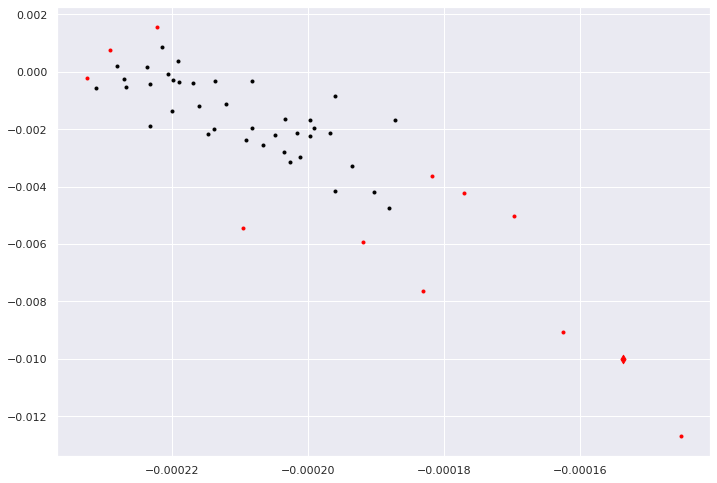

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.10849010788494862
fowlkes_mallows_score: 0.8255683059671922
homogeneity_completeness_v_measure: 0.3290944810956866 0.06246549736168549 0.10500077419360594


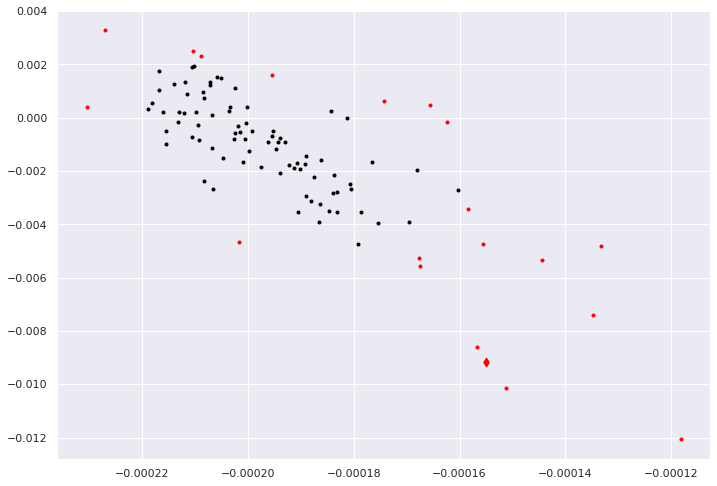

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.19559046482433606
fowlkes_mallows_score: 0.8396008540874151
homogeneity_completeness_v_measure: 0.387378742442079 0.11501056330559203 0.1773630404595128


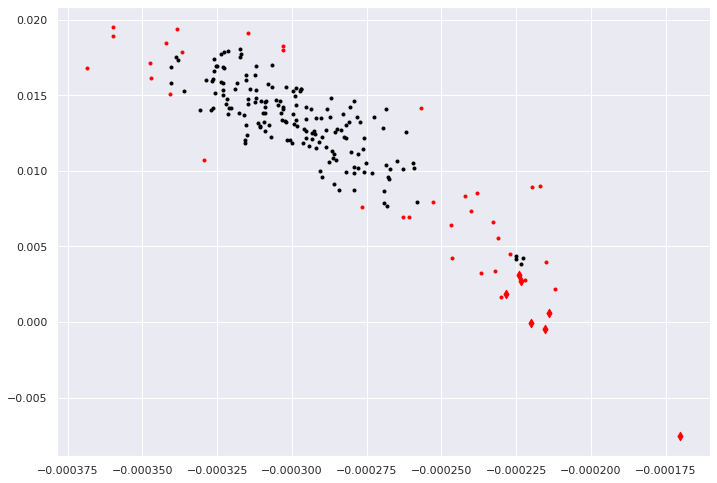

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.16673265129444673
fowlkes_mallows_score: 0.839082654569781
homogeneity_completeness_v_measure: 0.19054738805196342 0.06533521657839937 0.09730598830512373


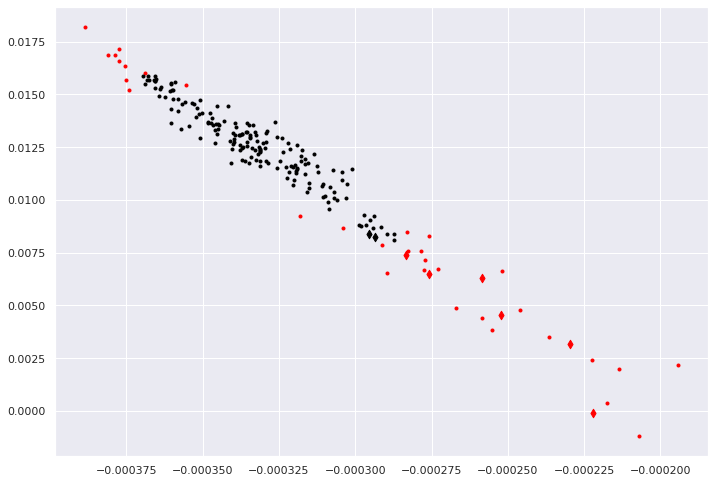

In [23]:
from sklearn.ensemble import IsolationForest


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, IsolationForest, params=None)

# one class svm 

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


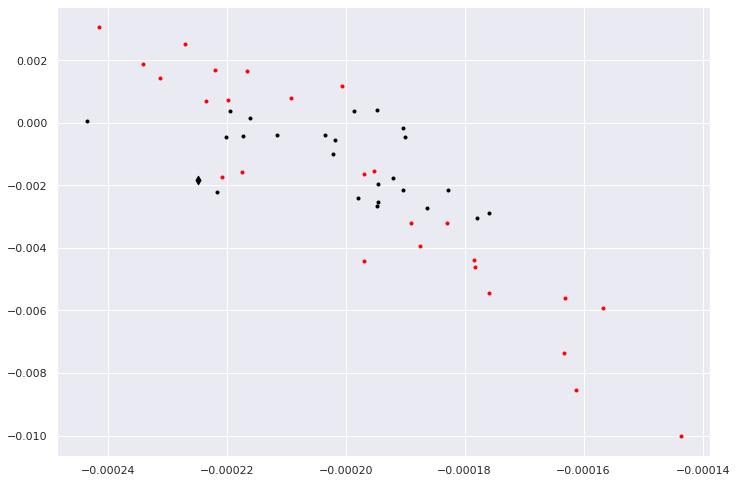

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


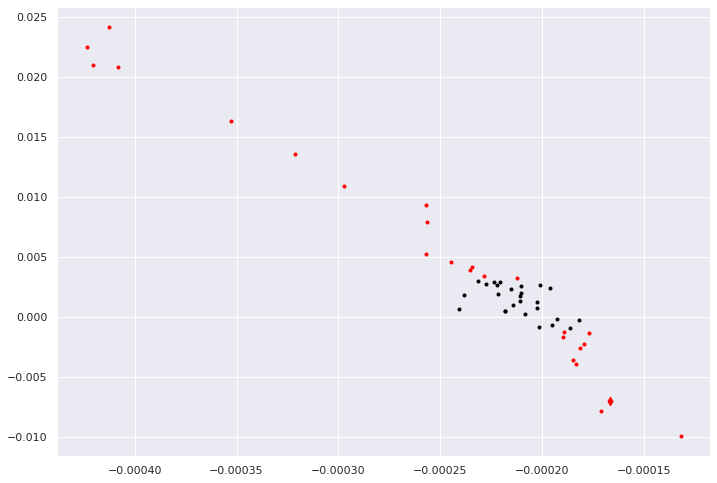

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


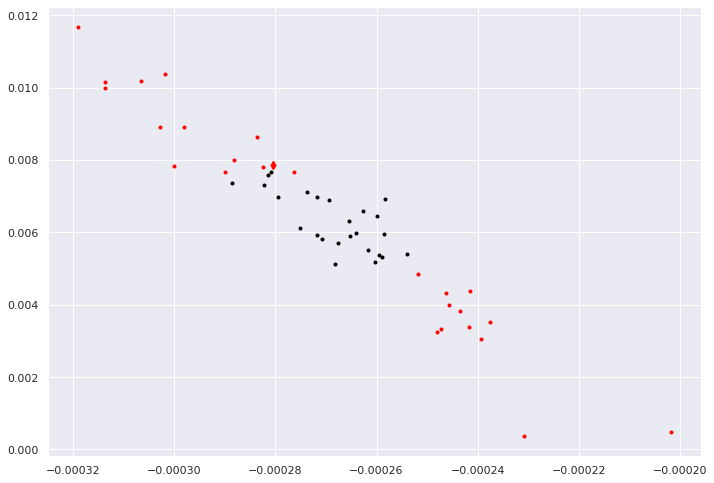

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: 0.006219327757029538
fowlkes_mallows_score: 0.6525022327591361
homogeneity_completeness_v_measure: 0.04533153211315304 0.017286000841692958 0.025028162729702423


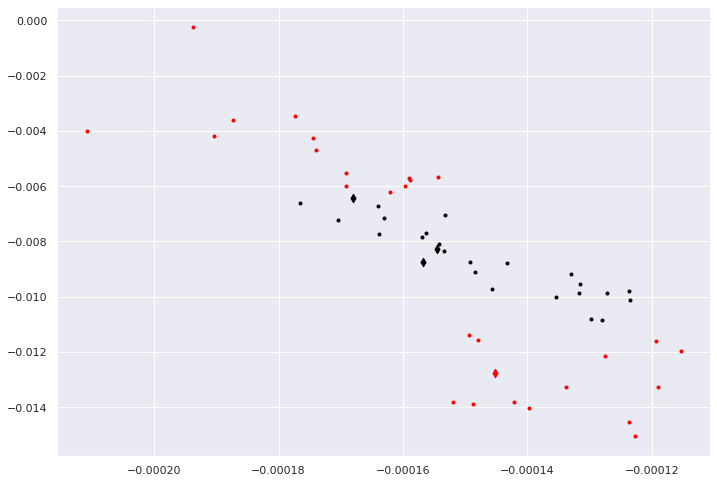

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.00340642743958801
fowlkes_mallows_score: 0.6879162727700022
homogeneity_completeness_v_measure: 0.15523438183024274 0.026980118808811848 0.04597045844654071


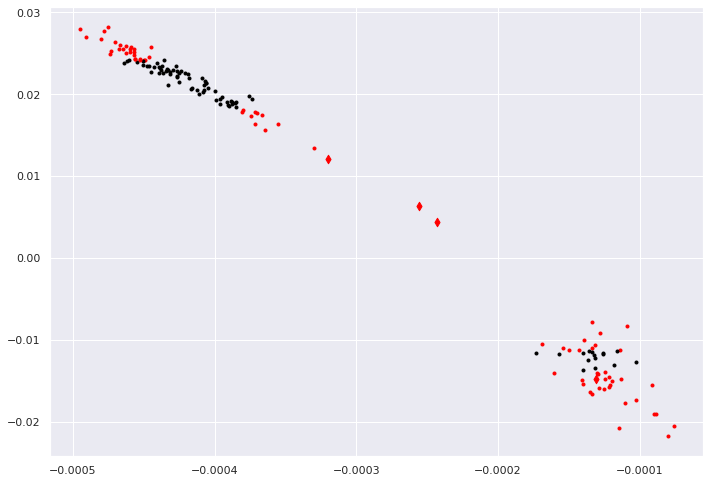

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


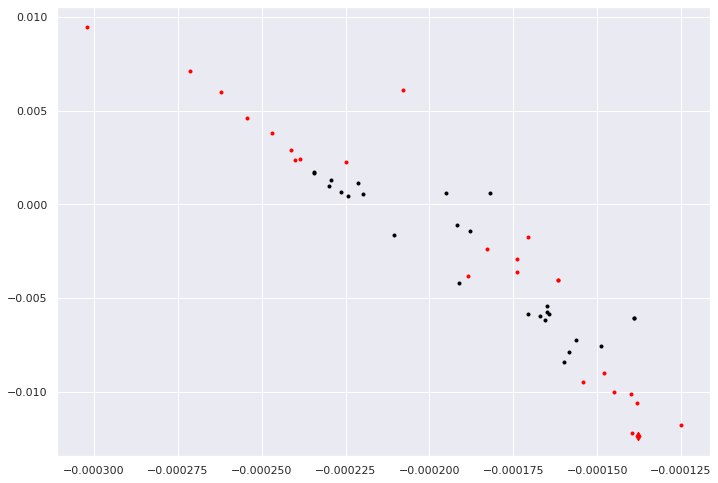

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.020324229695445124
fowlkes_mallows_score: 0.6441887708814792
homogeneity_completeness_v_measure: 0.09262101928685264 0.044993912938025314 0.0605658413756125


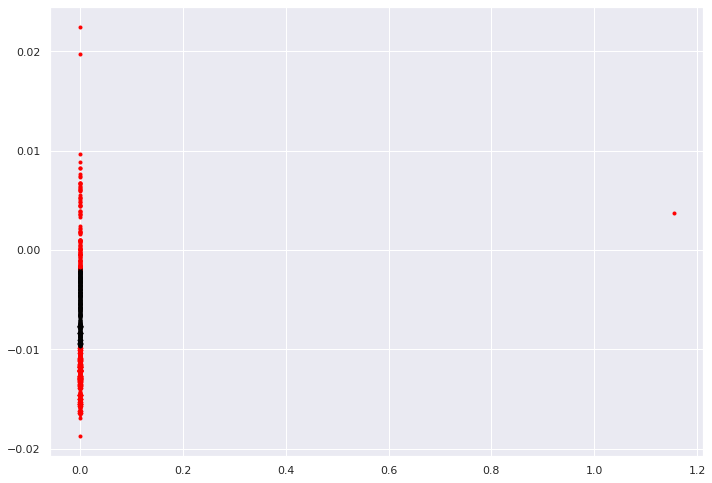

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.0091950932616367
fowlkes_mallows_score: 0.6772042036654343
homogeneity_completeness_v_measure: 0.17788766669657974 0.041882705225973815 0.06780183008667459


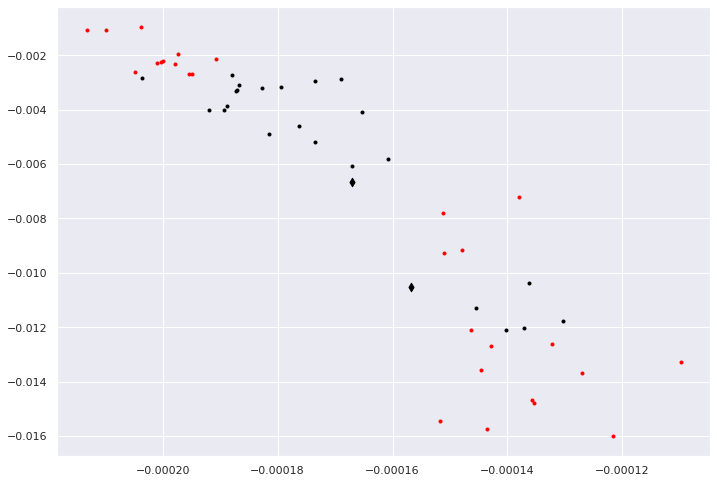

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.0003445040607499927
fowlkes_mallows_score: 0.6831500835050487
homogeneity_completeness_v_measure: 0.01364219869031343 0.002592067883979418 0.004356403158738674


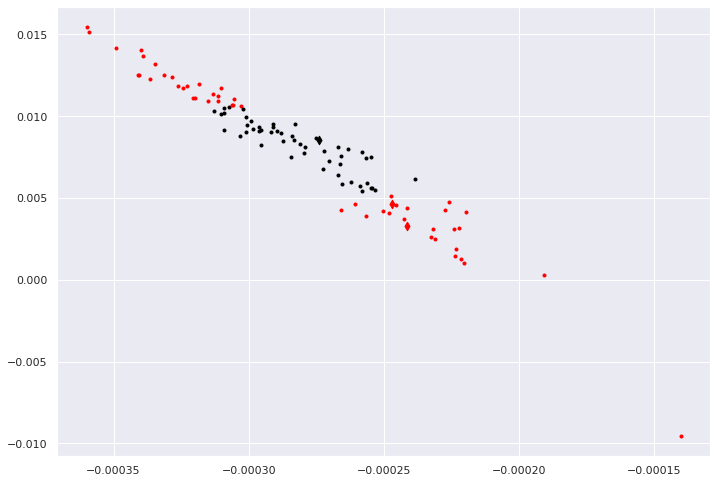

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


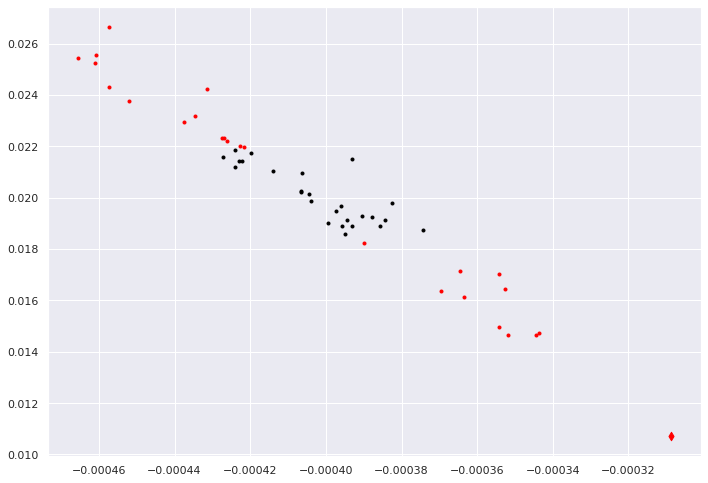

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.006219327757029538
fowlkes_mallows_score: 0.6525022327591361
homogeneity_completeness_v_measure: 0.19465535560540279 0.07422675749048259 0.10747190066595014


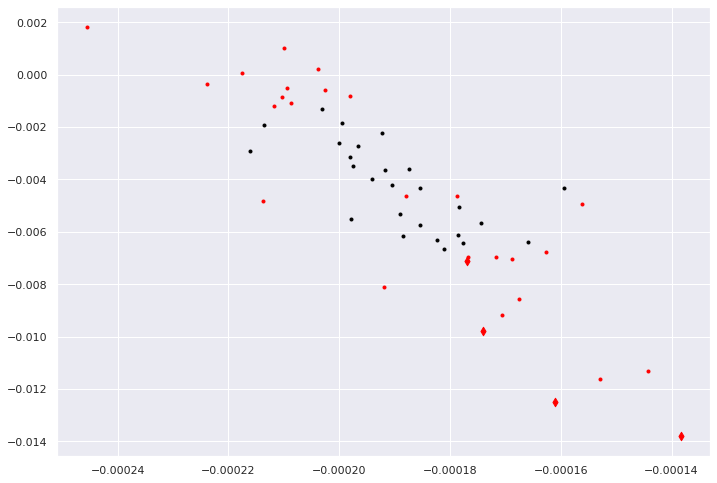

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


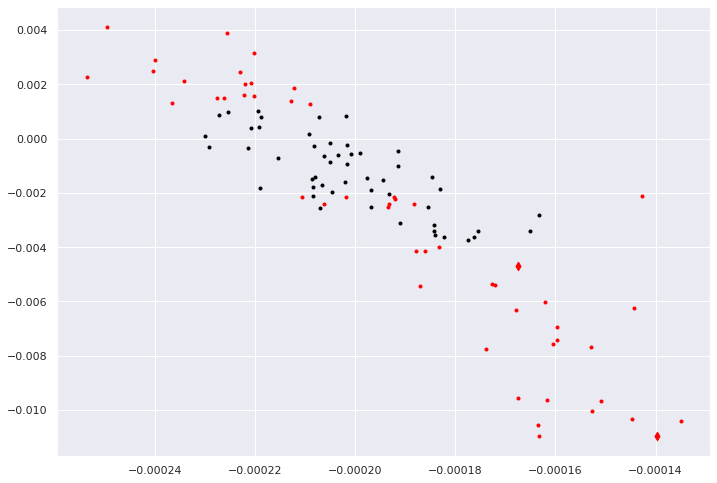

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.02056617469150738
fowlkes_mallows_score: 0.6470995952589369
homogeneity_completeness_v_measure: 0.21586504084499003 0.09489466505068185 0.1318345999079695


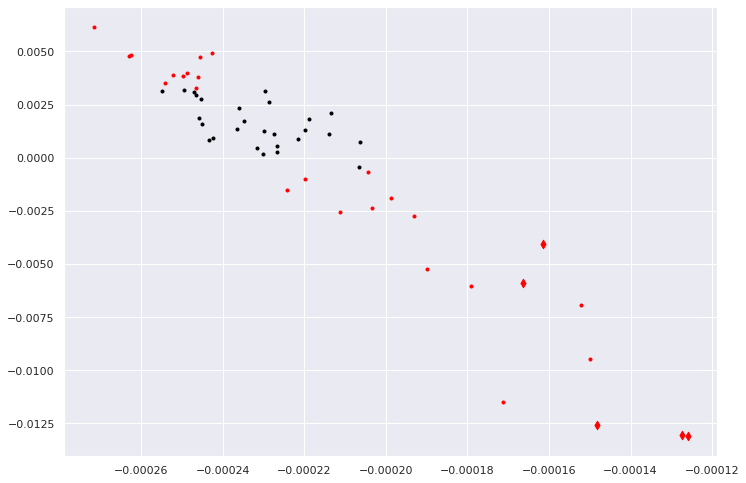

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.0007056318499933976
fowlkes_mallows_score: 0.6869273544982754
homogeneity_completeness_v_measure: 0.14948252341110957 0.025980431615227492 0.04426712723003031


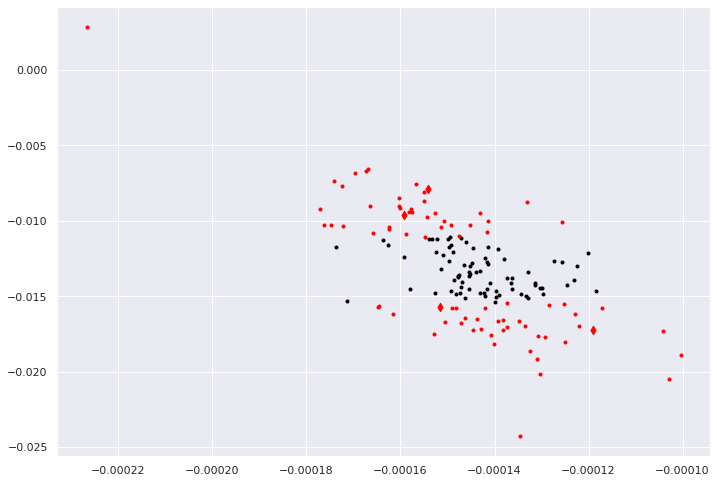

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


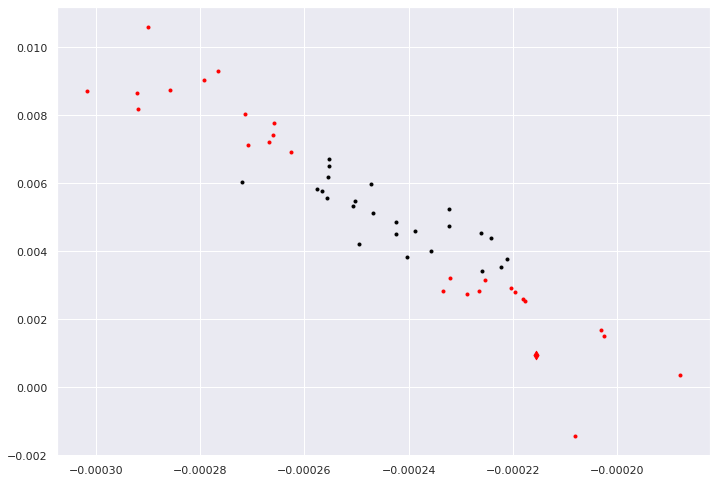

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


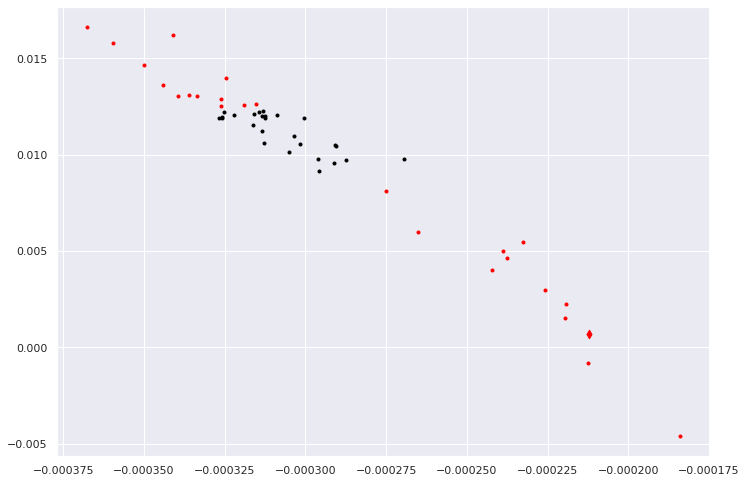

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


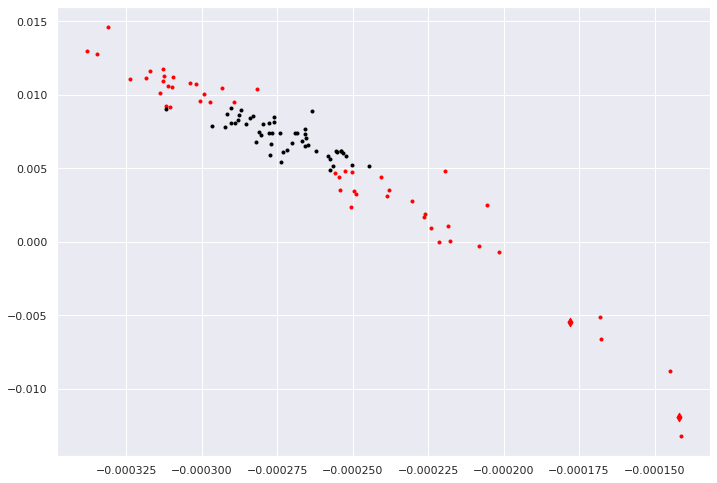

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.0049081985093619345
fowlkes_mallows_score: 0.6891839007912093
homogeneity_completeness_v_measure: 0.1554324907626066 0.02169551538314924 0.03807628243278946


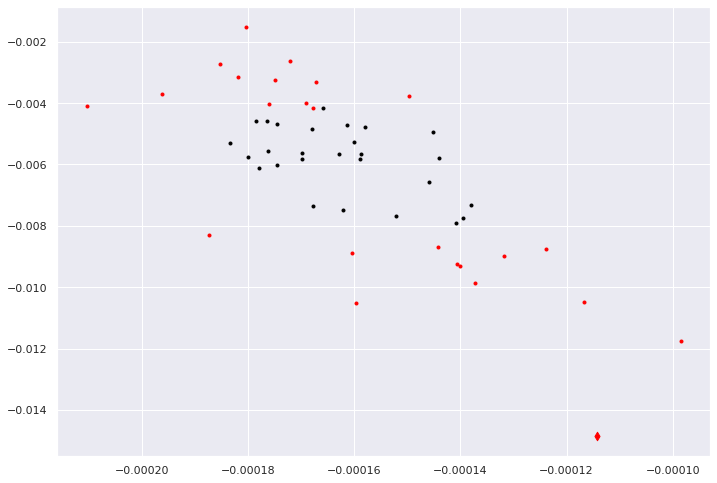

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.033873699491894504
fowlkes_mallows_score: 0.6523691359369412
homogeneity_completeness_v_measure: 0.2278434404710406 0.10016039133923603 0.13915013148296004


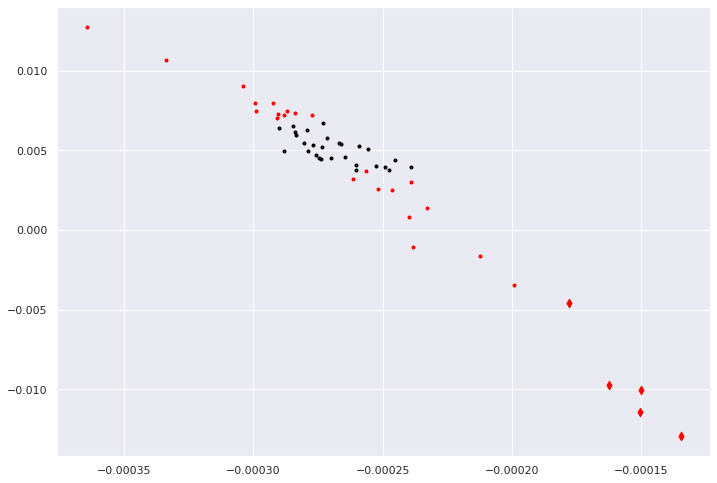

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.00409848991786824
fowlkes_mallows_score: 0.671025213538636
homogeneity_completeness_v_measure: 0.05941333083033412 0.017550290459992745 0.027096469625164574


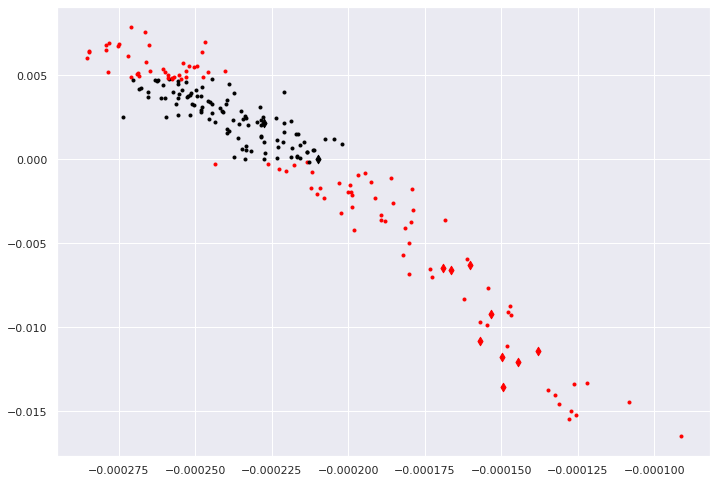

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


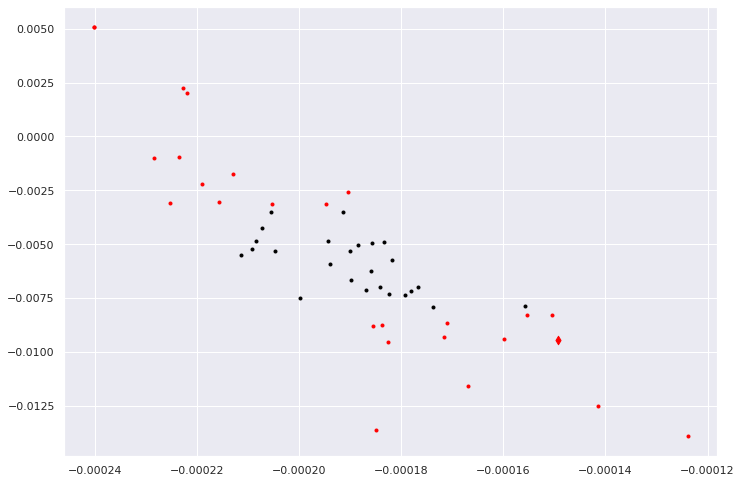

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


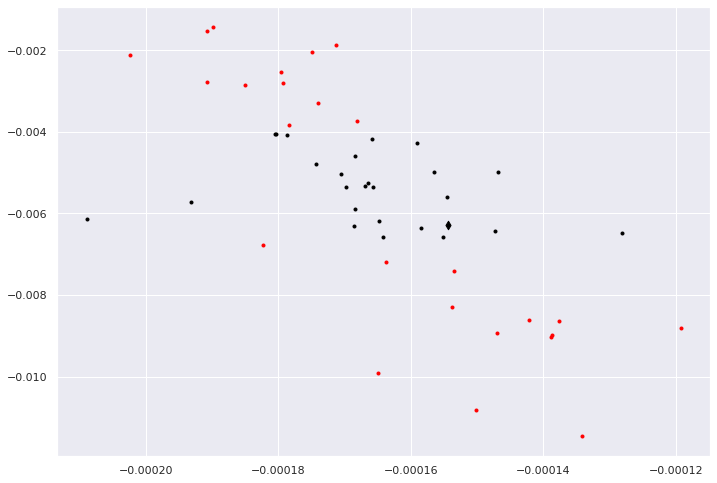

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.0091950932616367
fowlkes_mallows_score: 0.6772042036654343
homogeneity_completeness_v_measure: 0.17788766669657974 0.041882705225973815 0.06780183008667459


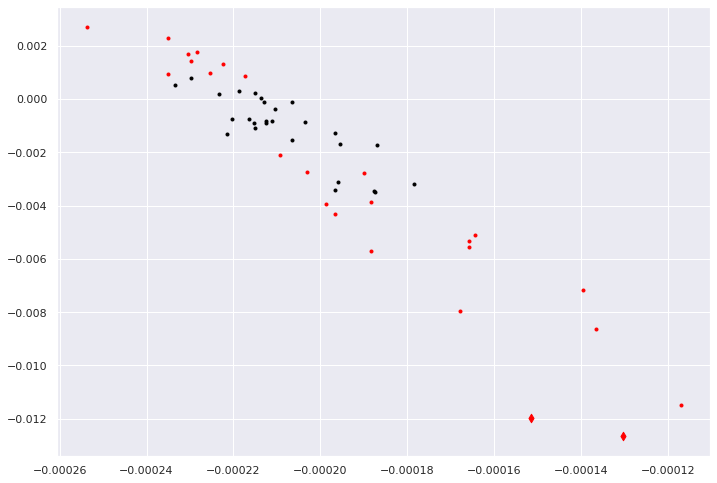

-------------------
Frankia
23 Frankia
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


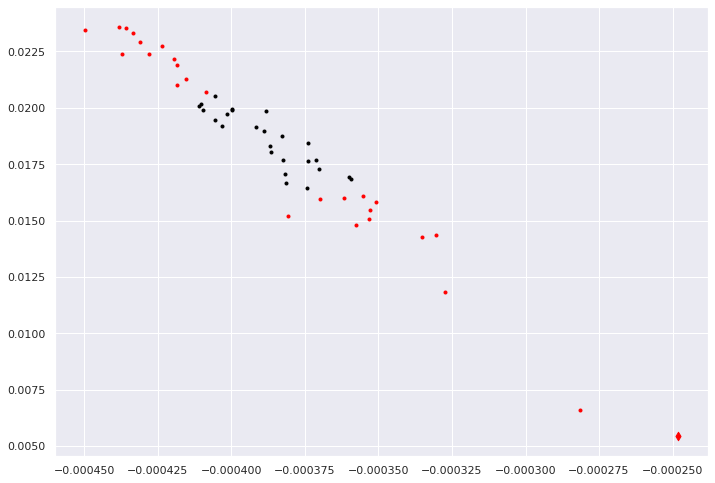

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.020278401283615972
fowlkes_mallows_score: 0.6622350705568112
homogeneity_completeness_v_measure: 0.2056805345652218 0.07835329738868076 0.11347766553716158


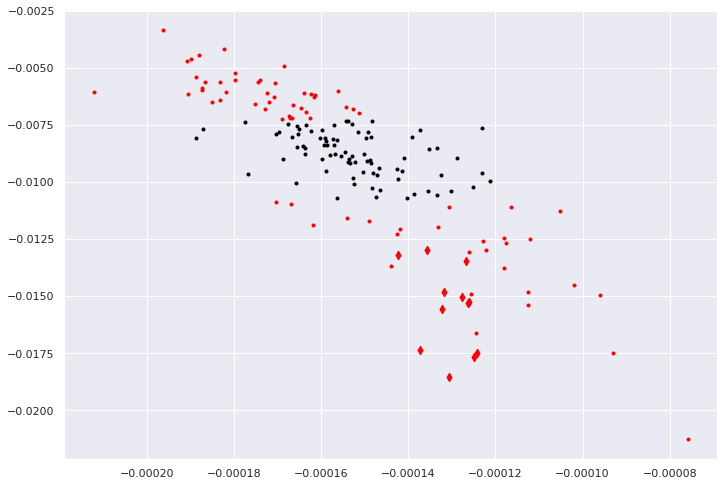

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.0028729614174167668
fowlkes_mallows_score: 0.6886047361512531
homogeneity_completeness_v_measure: 0.15397713507800798 0.027391768964484947 0.04650969395373221


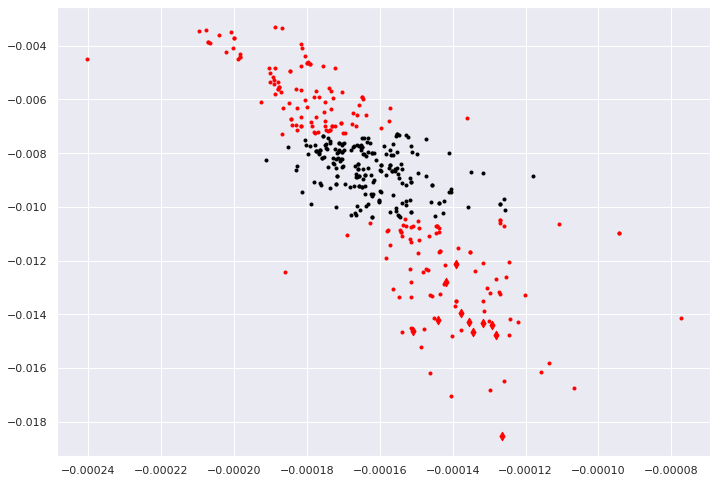

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.002346893026870311
fowlkes_mallows_score: 0.6907959838293899
homogeneity_completeness_v_measure: 0.14696457212882502 0.020467994981116955 0.035931720771617735


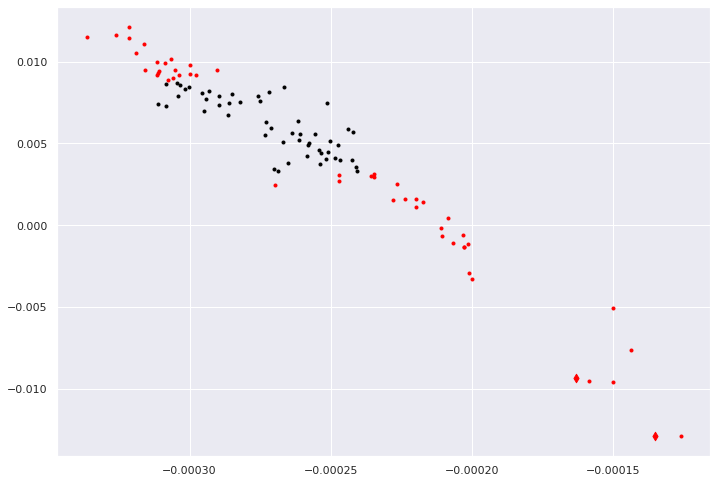

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.0030420564301467793
fowlkes_mallows_score: 0.6412848533203596
homogeneity_completeness_v_measure: 1.4577694951920096e-15 6.406853007629834e-16 8.901516385013678e-16


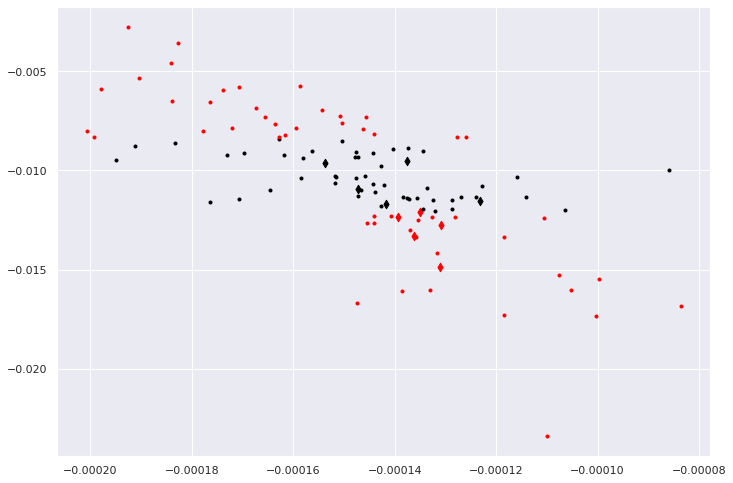

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.0019356399709654004
fowlkes_mallows_score: 0.6397222383097309
homogeneity_completeness_v_measure: 0.059364005849429184 0.026096525074634586 0.03625519875501181


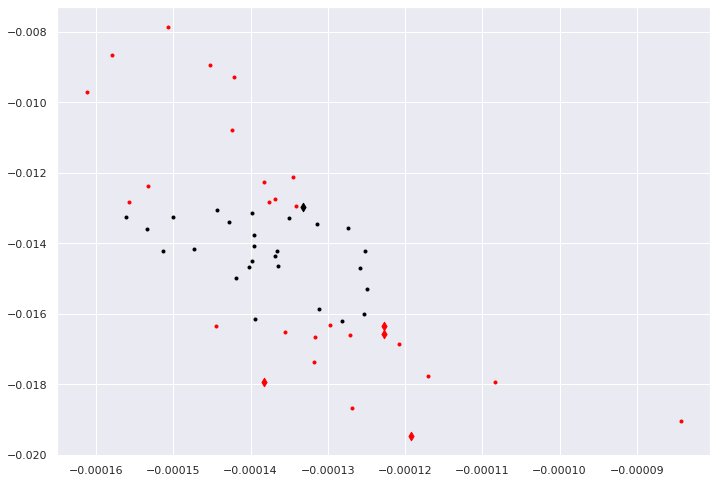

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


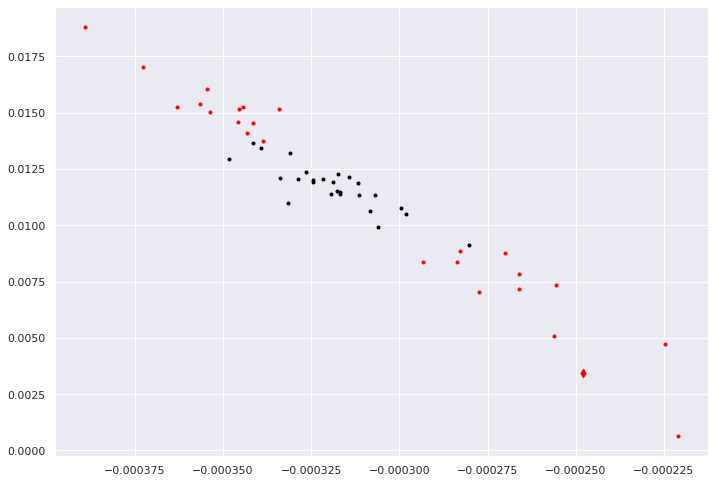

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.01685875588625543
fowlkes_mallows_score: 0.6561939961369581
homogeneity_completeness_v_measure: 0.20568053456521845 0.0783532973886795 0.11347766553715974


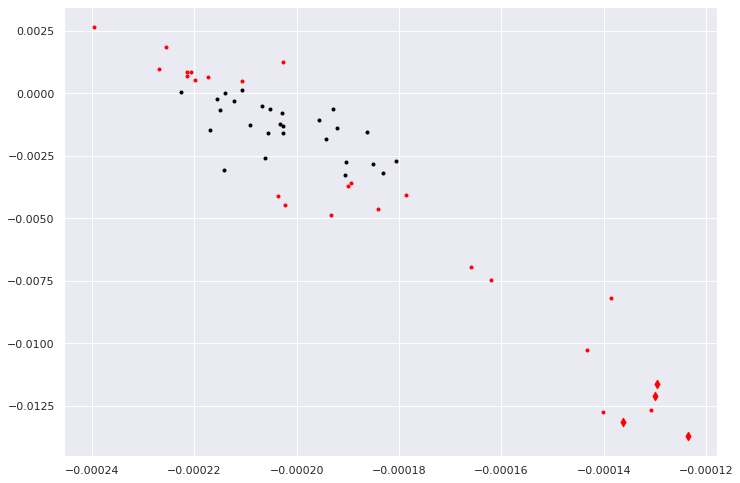

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.0026886237607124854
fowlkes_mallows_score: 0.6727268205007042
homogeneity_completeness_v_measure: 0.15899339002802354 0.03743414825256139 0.06060028227798269


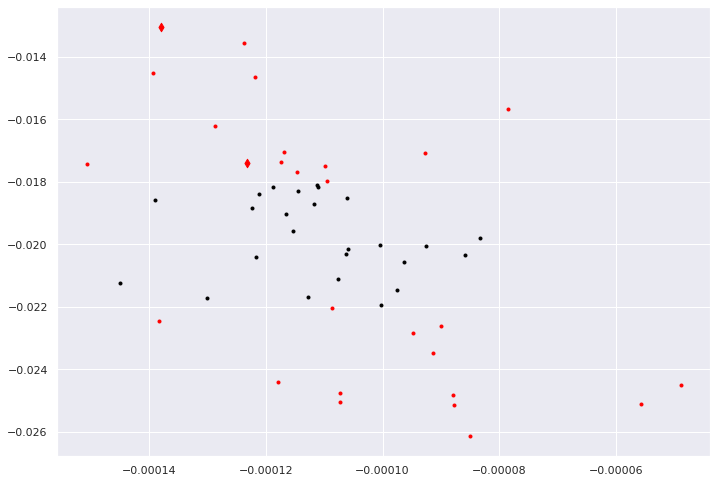

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.01914316016115862
fowlkes_mallows_score: 0.6671959199067086
homogeneity_completeness_v_measure: 0.2010838199583246 0.0714380333967304 0.10542297778233173


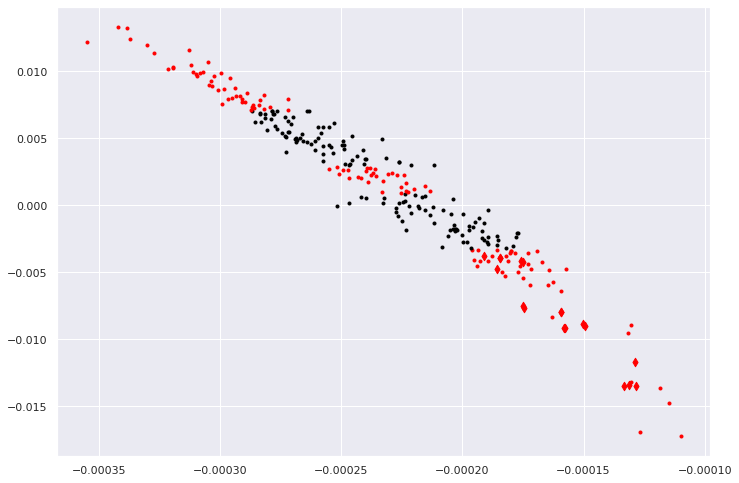

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.0011654499076435923
fowlkes_mallows_score: 0.683707302170224
homogeneity_completeness_v_measure: 0.15441999878924076 0.02934036723786607 0.049311389297938386


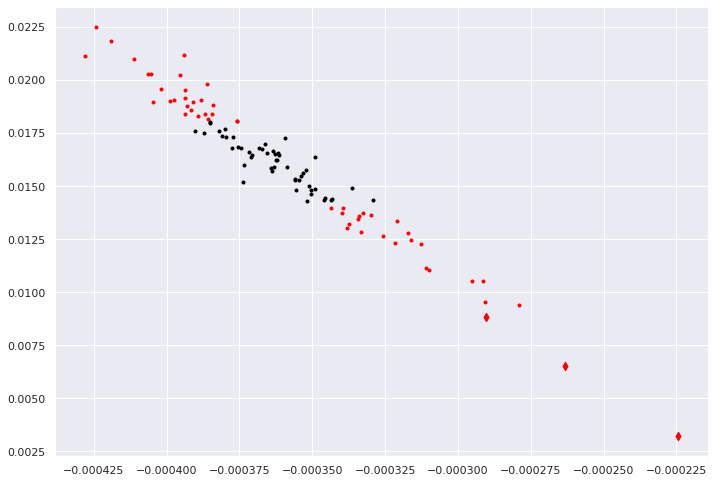

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: -0.0048226797123368005
fowlkes_mallows_score: 0.6482023827903773
homogeneity_completeness_v_measure: 0.03409840002802822 0.013002538059238813 0.01882619591576429


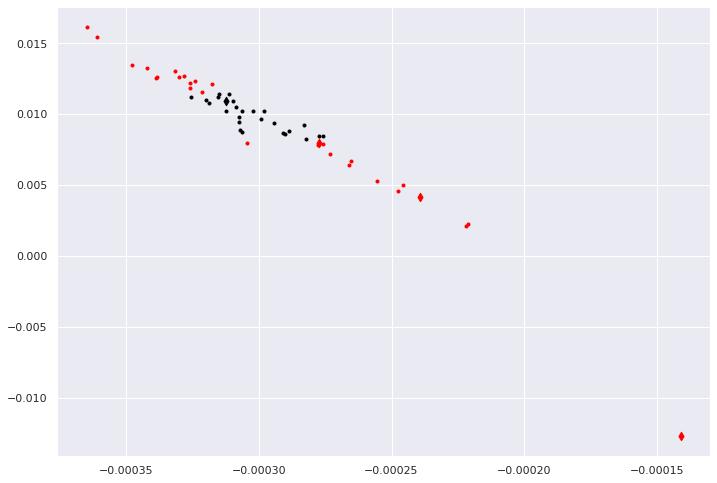

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.0011654499076435923
fowlkes_mallows_score: 0.683707302170224
homogeneity_completeness_v_measure: 0.15441999878924076 0.02934036723786607 0.049311389297938386


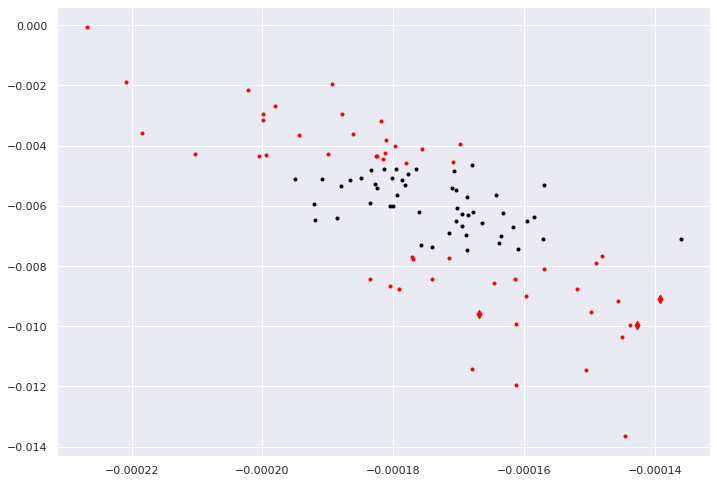

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


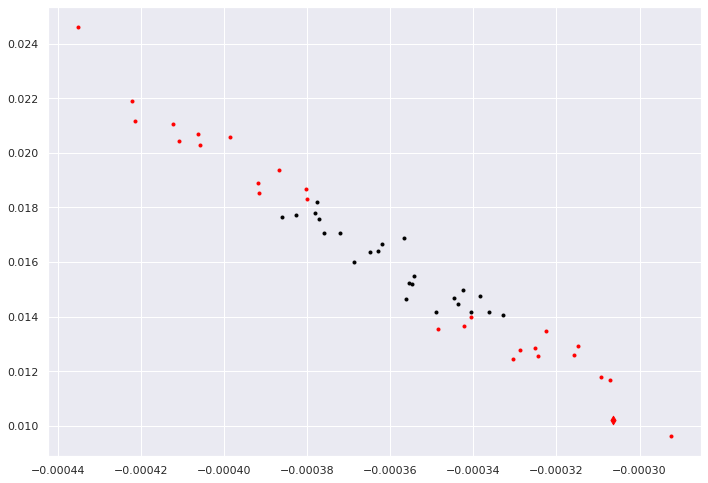

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.0015803815769341758
fowlkes_mallows_score: 0.677596076519044
homogeneity_completeness_v_measure: 0.16357692992430764 0.0384824779605117 0.062306879610857895


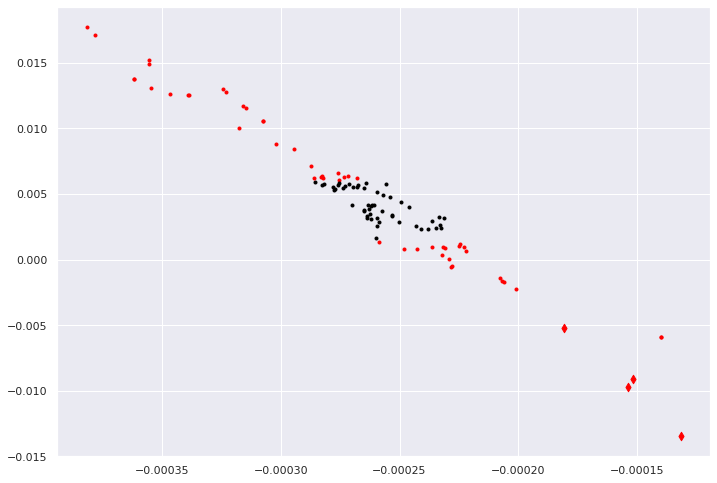

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


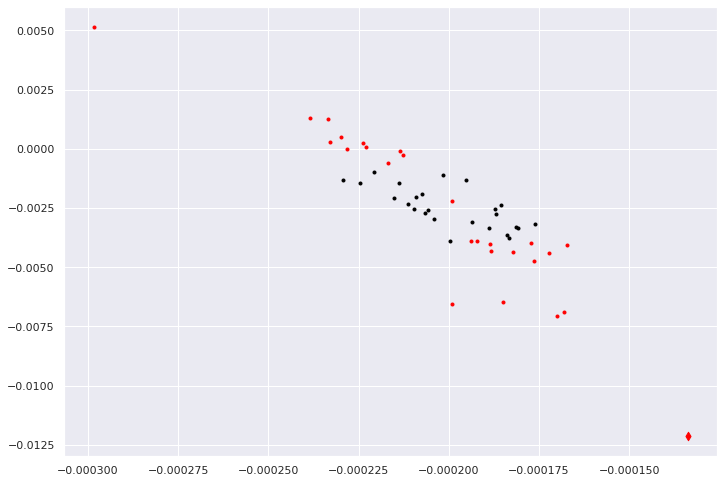

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.0045336787564766836
fowlkes_mallows_score: 0.6629250151987521
homogeneity_completeness_v_measure: 0.18302646225521343 0.05745083081523058 0.08745126979331261


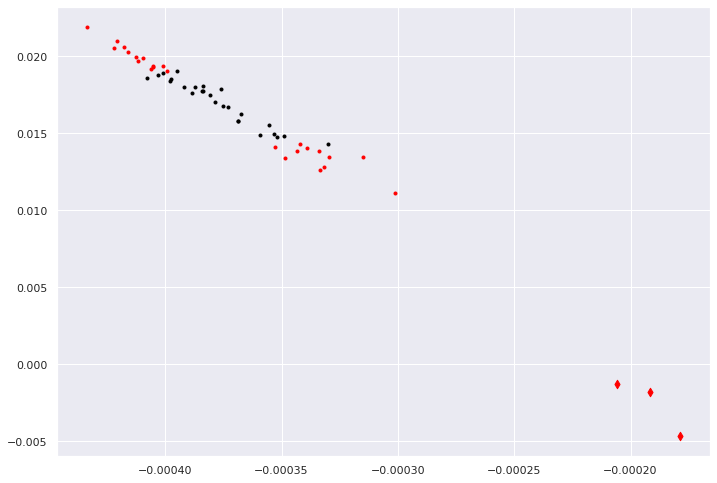

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.01647456249610914
fowlkes_mallows_score: 0.6694417454901037
homogeneity_completeness_v_measure: 0.1960089820252609 0.06611374554611887 0.09887649256848967


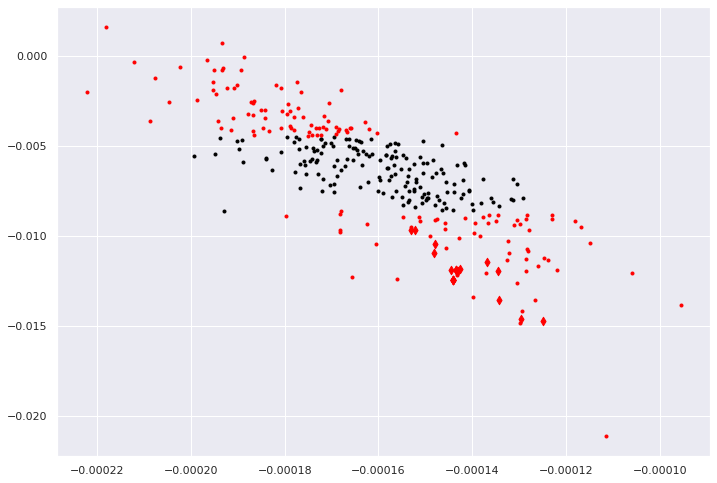

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.008011308134240632
fowlkes_mallows_score: 0.6769438137158869
homogeneity_completeness_v_measure: 0.1769166546221436 0.04651936403254008 0.07366807114931687


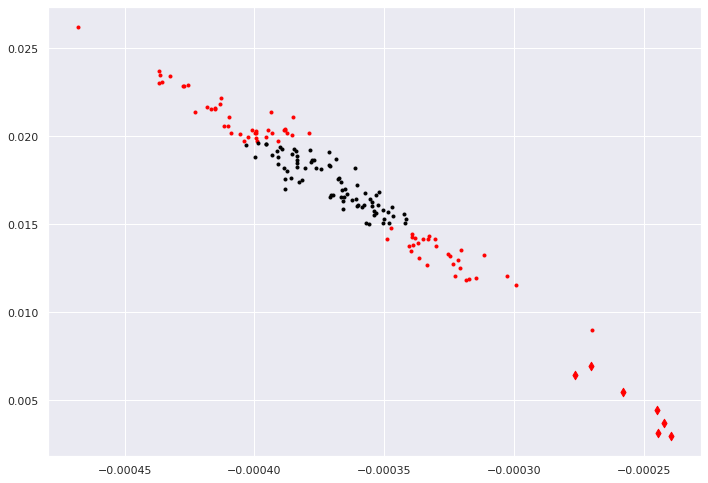

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


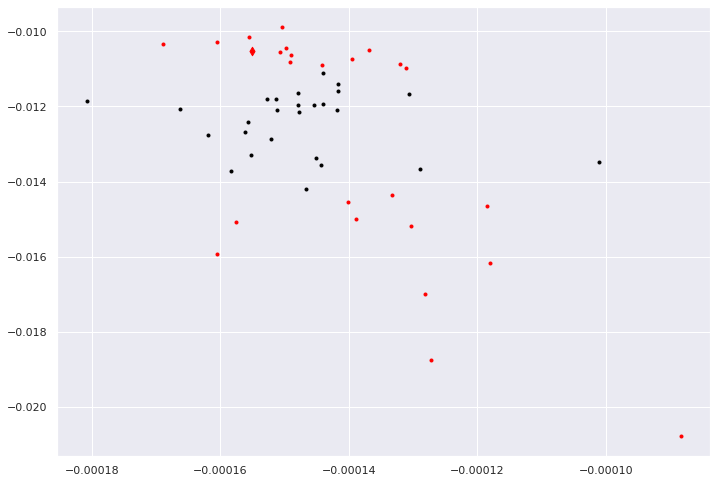

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


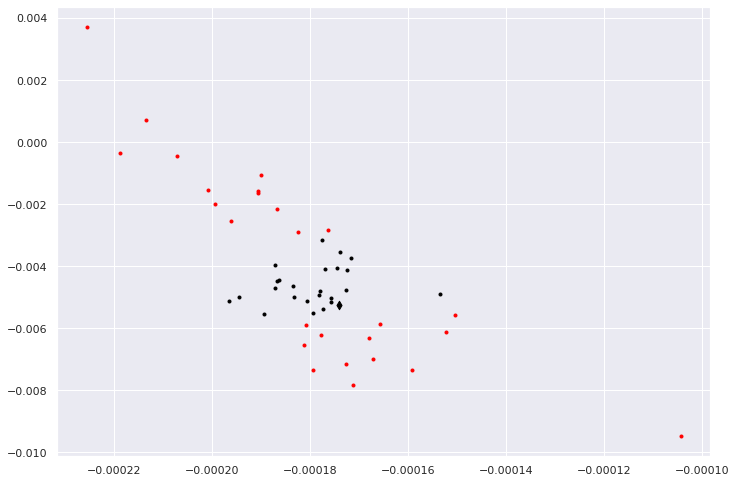

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


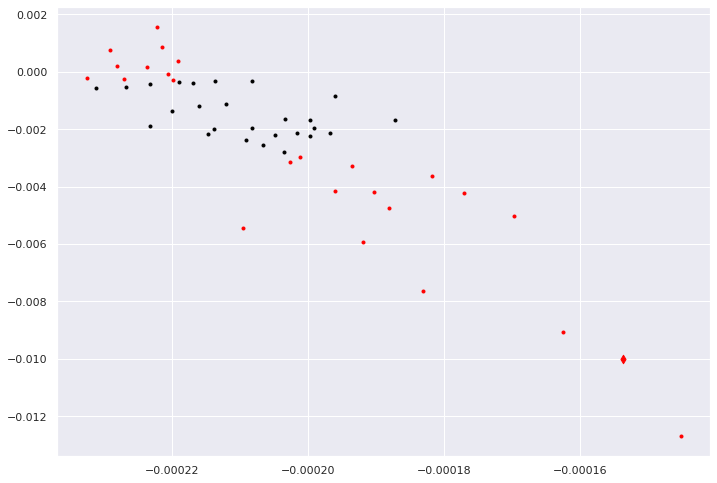

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


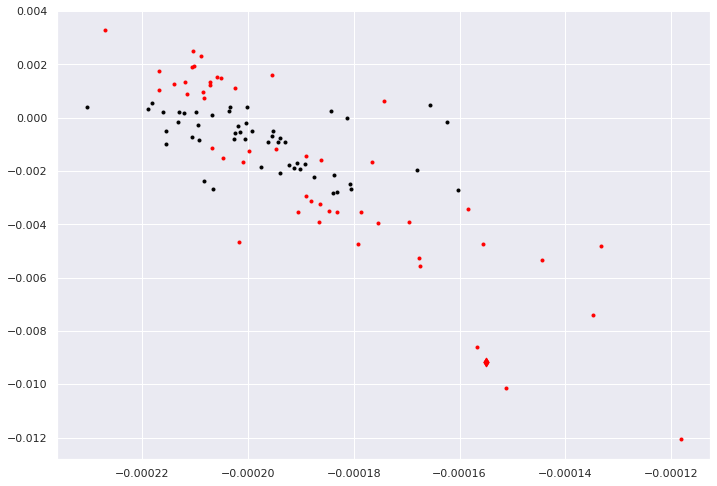

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.003291540011119214
fowlkes_mallows_score: 0.683056228841494
homogeneity_completeness_v_measure: 0.1614893763771658 0.03442752282792292 0.056755483720390625


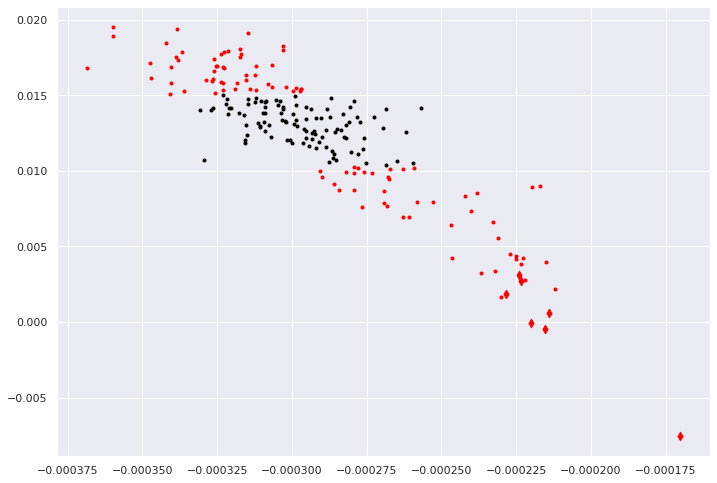

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.0037399470098527427
fowlkes_mallows_score: 0.6800923349282796
homogeneity_completeness_v_measure: 0.16590254885380842 0.03902178402299054 0.06318247656932983


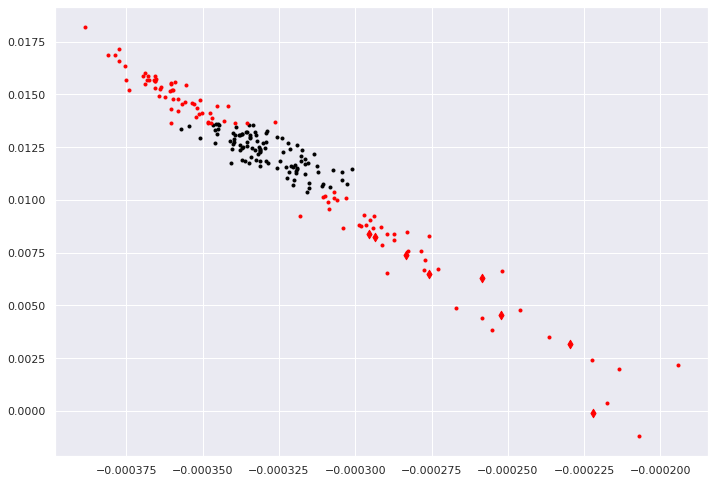

In [24]:
from sklearn.svm import OneClassSVM



# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, OneClassSVM, params=None)



# EllipticEnvelope

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


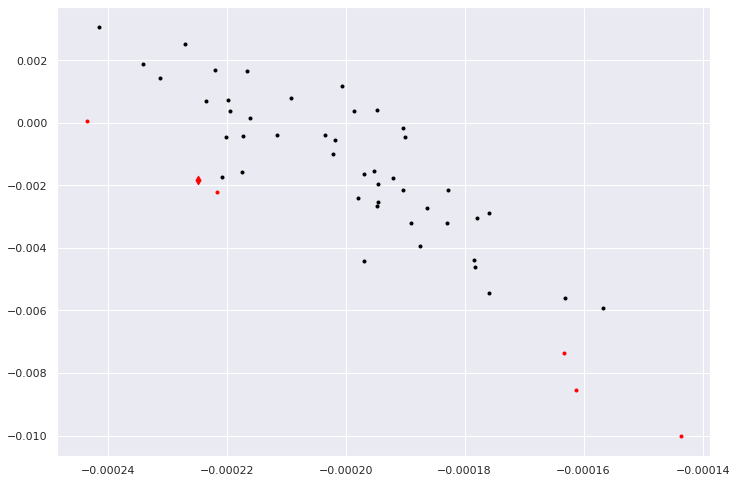

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


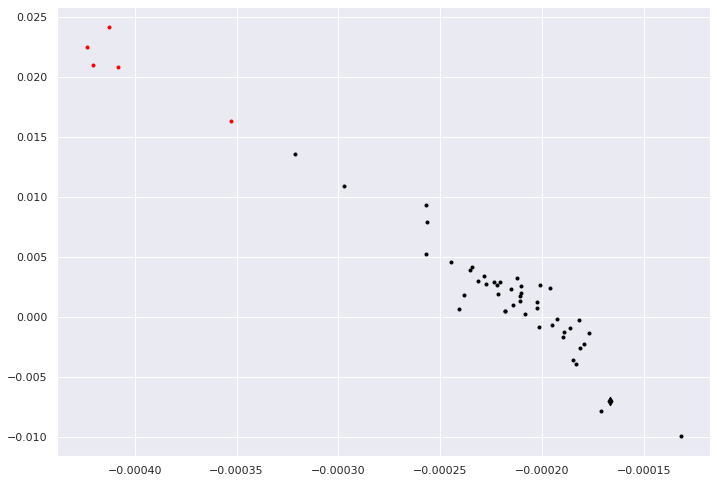

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


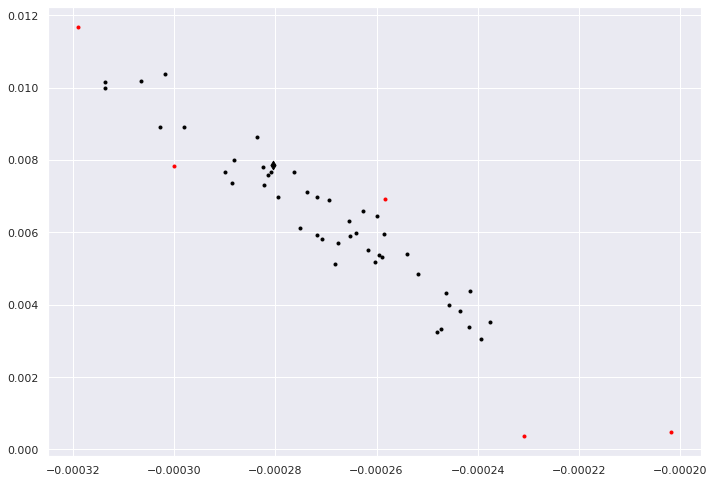

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.07976293369551797
fowlkes_mallows_score: 0.8152190738955344
homogeneity_completeness_v_measure: 0.034412660271568175 0.026049018028360408 0.02965236933619754


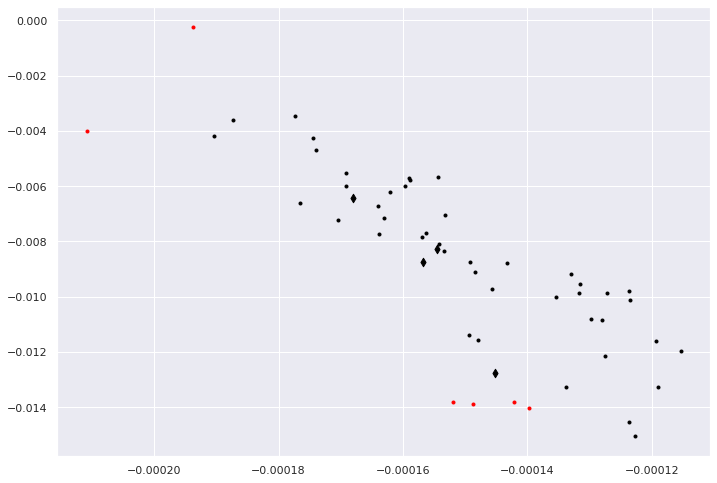

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


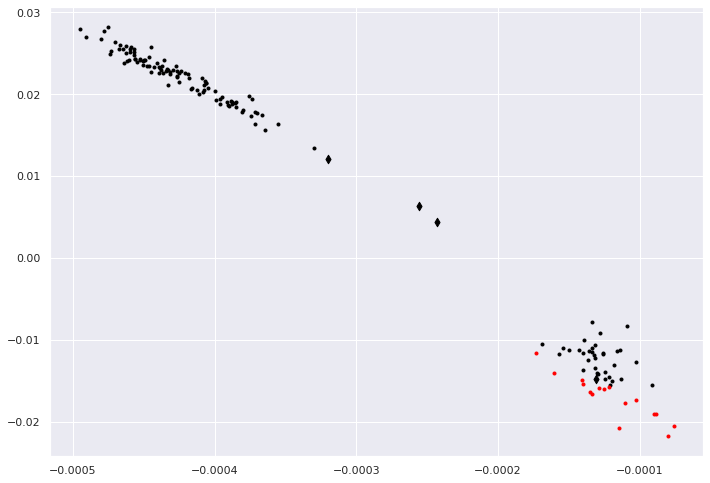

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


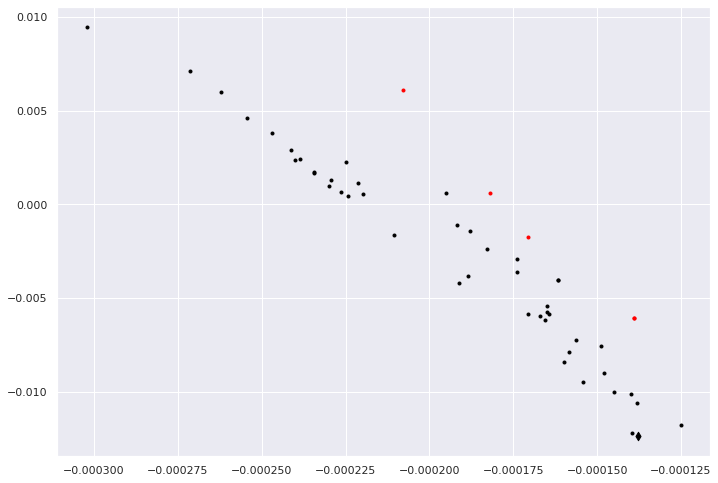

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.07093878307065
fowlkes_mallows_score: 0.801070215347033
homogeneity_completeness_v_measure: 0.018386741113376043 0.01886805870805866 0.018624290692199716


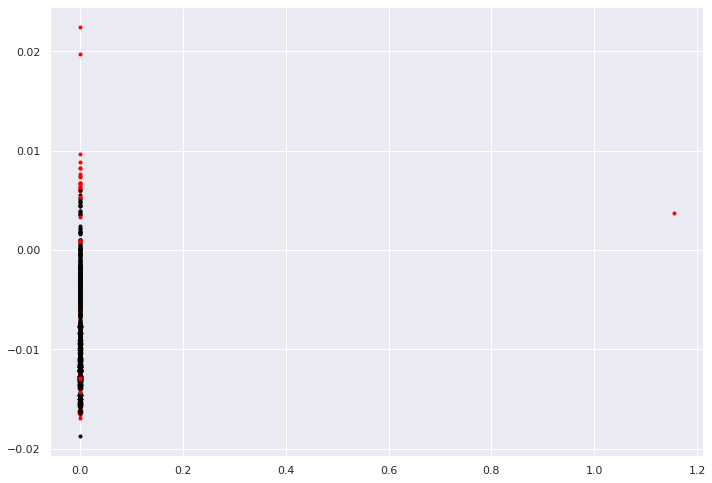

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: -0.05272274548013424
fowlkes_mallows_score: 0.8478815545719766
homogeneity_completeness_v_measure: 0.029533560624185776 0.013462814867927575 0.01849480820294072


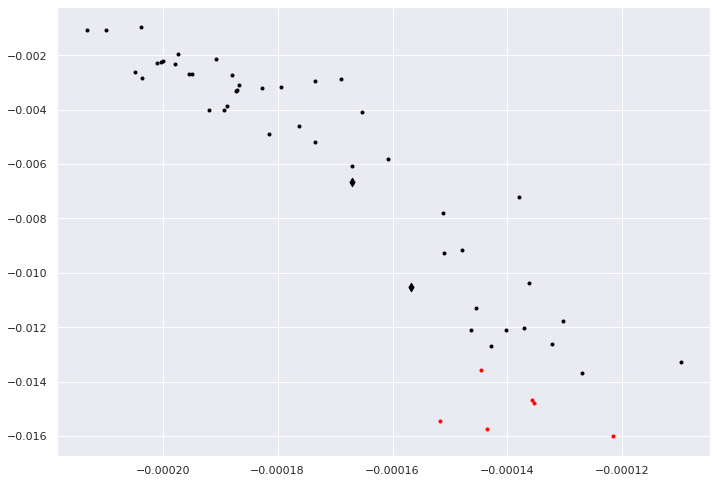

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.04144995111966517
fowlkes_mallows_score: 0.8670807858659687
homogeneity_completeness_v_measure: 0.02537224732261839 0.00983421156412823 0.014174447298472554


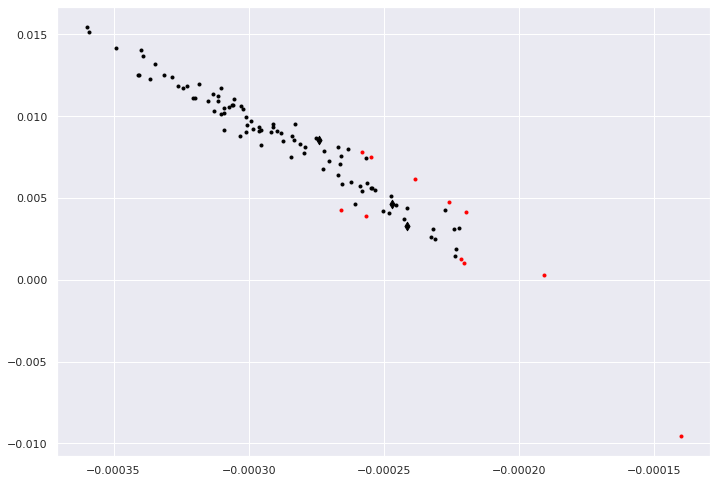

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


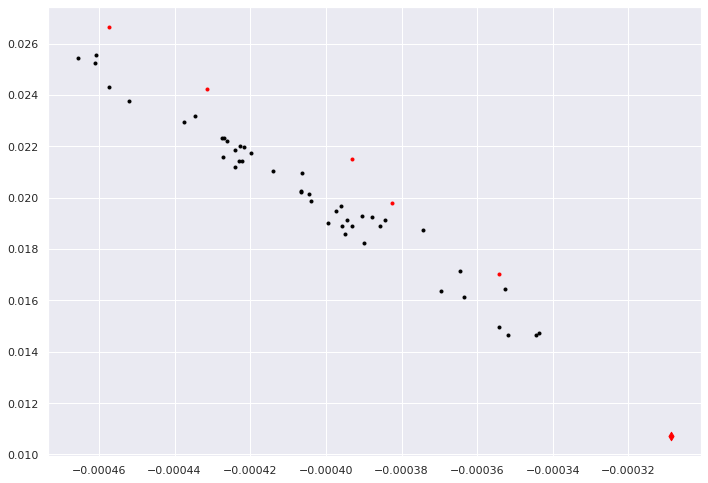

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.09692554636374862
fowlkes_mallows_score: 0.8455684913311489
homogeneity_completeness_v_measure: 0.02338511480278485 0.017701603778546272 0.020150260271347444


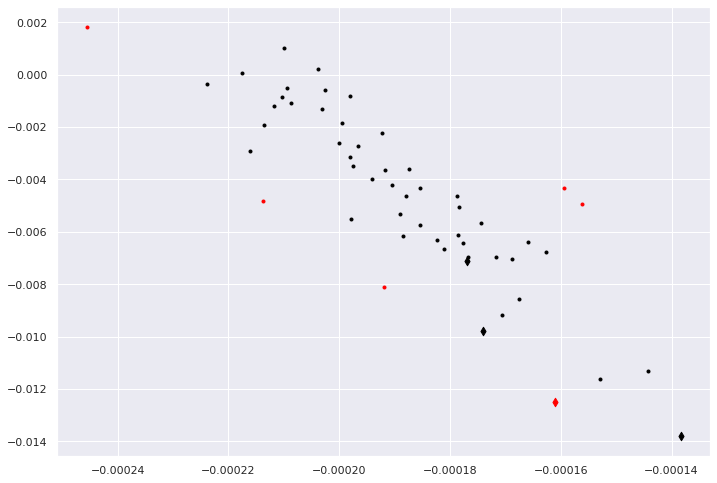

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.10884986754986345
fowlkes_mallows_score: 0.8934793337539082
homogeneity_completeness_v_measure: 0.10032311958540002 0.028311665665171255 0.0441609105135304


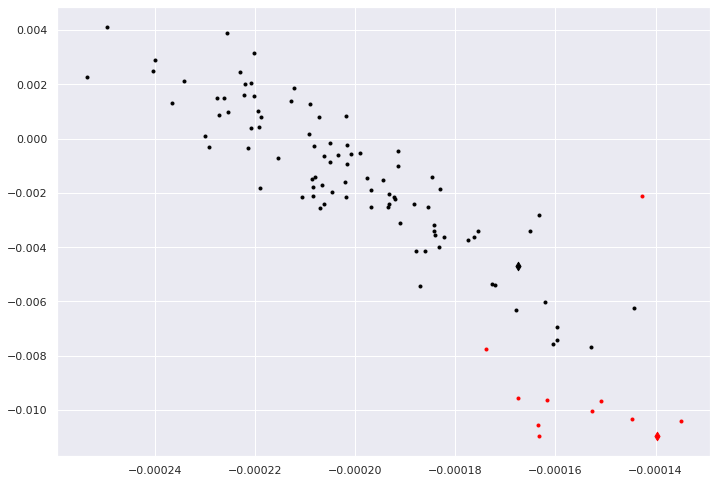

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.6494461594334483
fowlkes_mallows_score: 0.9358505544576419
homogeneity_completeness_v_measure: 0.4807138944215439 0.42495174580067574 0.45111617266379533


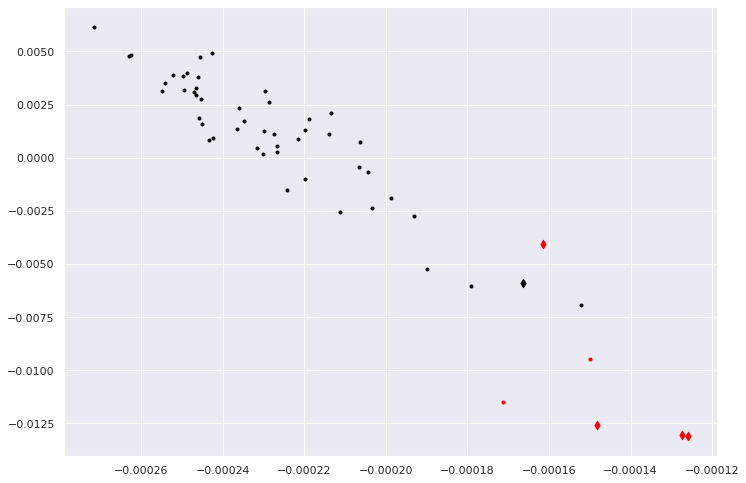

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


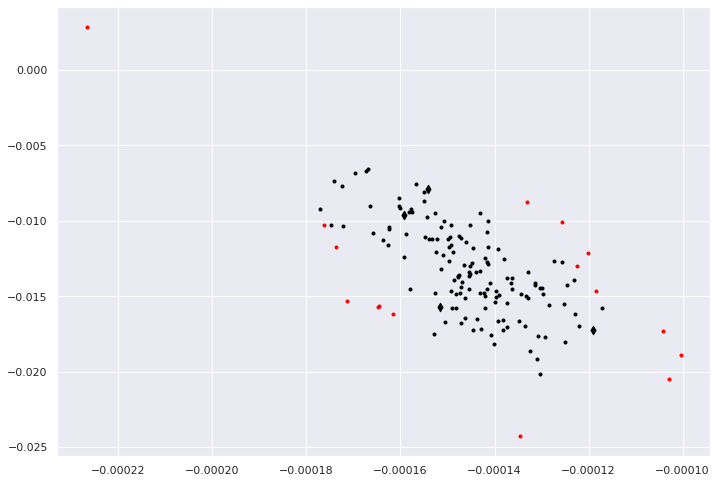

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


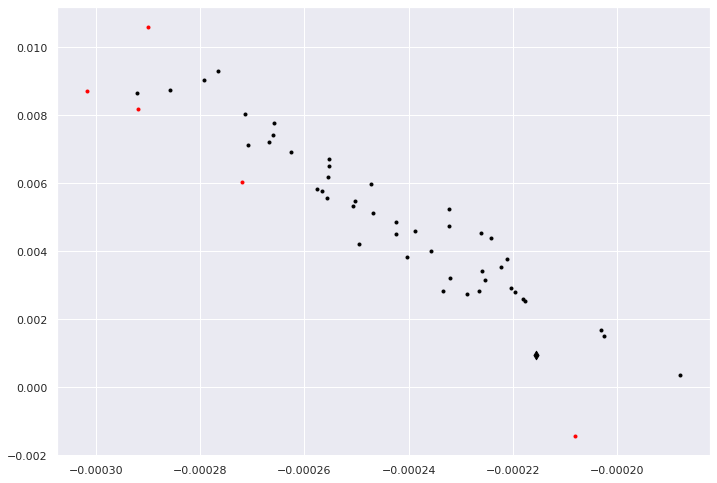

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


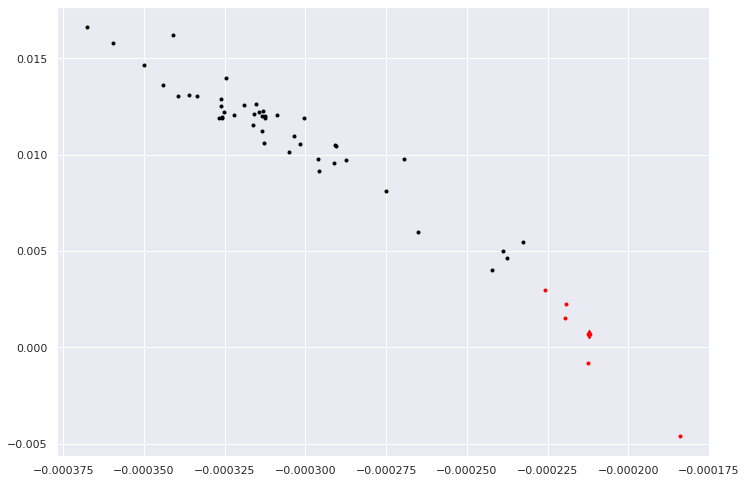

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


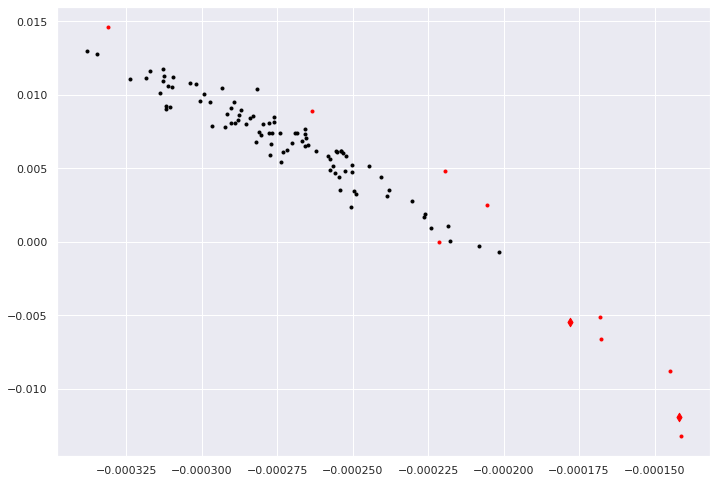

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


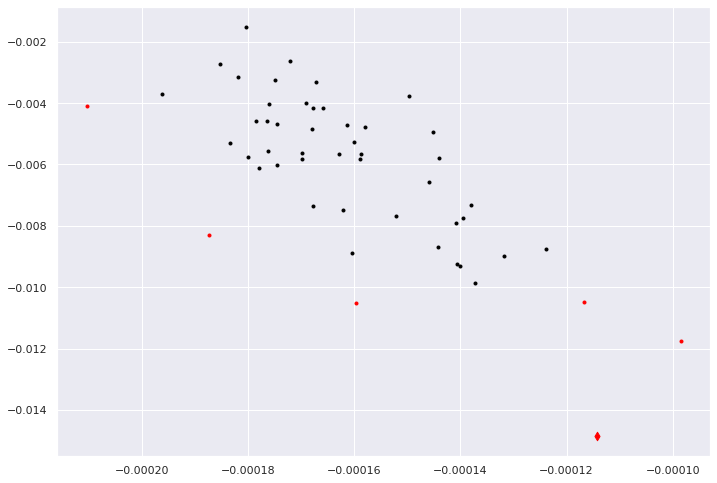

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.8786544398038859
fowlkes_mallows_score: 0.9779019890632276
homogeneity_completeness_v_measure: 0.8386529623245021 0.7413703755943142 0.7870168076007836


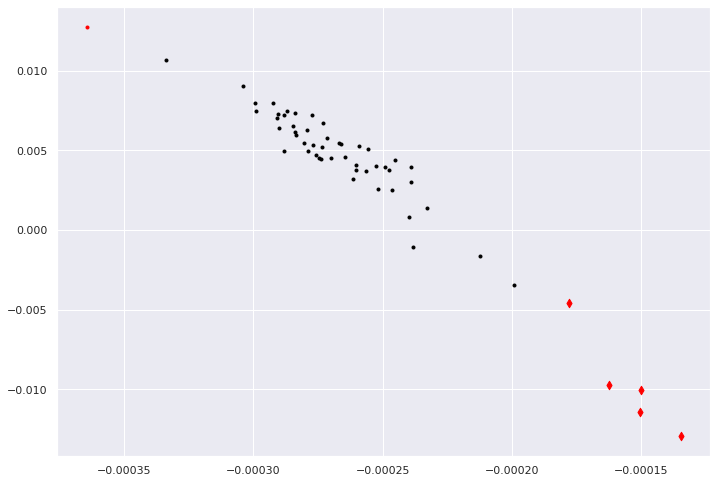

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.29227581241384154
fowlkes_mallows_score: 0.9007837795500936
homogeneity_completeness_v_measure: 0.1739866528424704 0.10993491018520718 0.13473585344975875


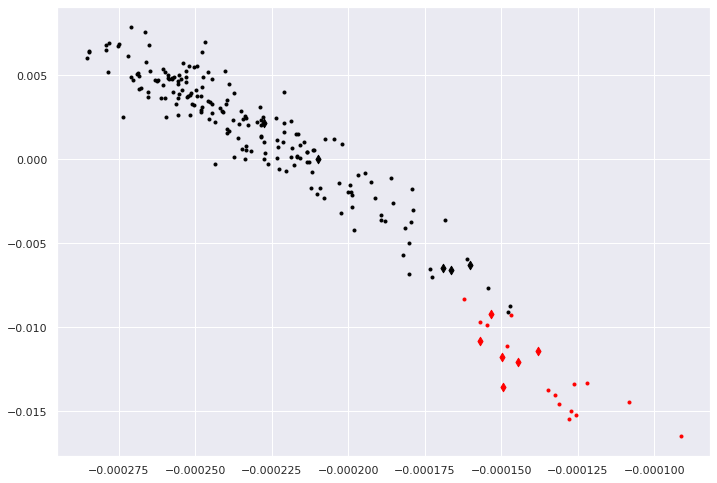

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


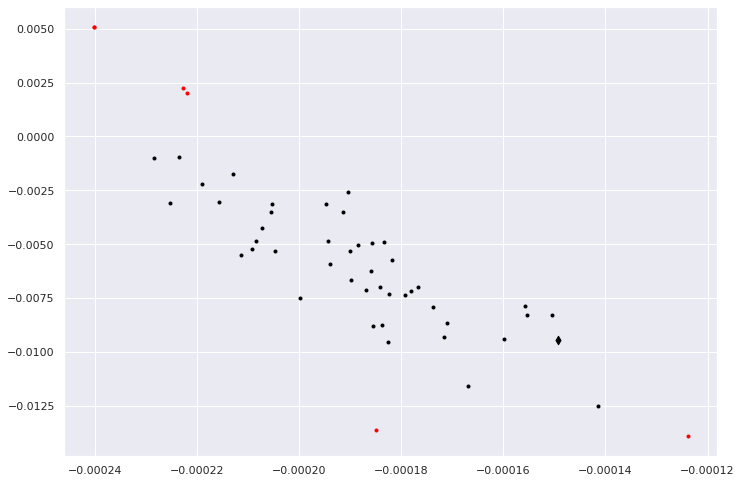

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


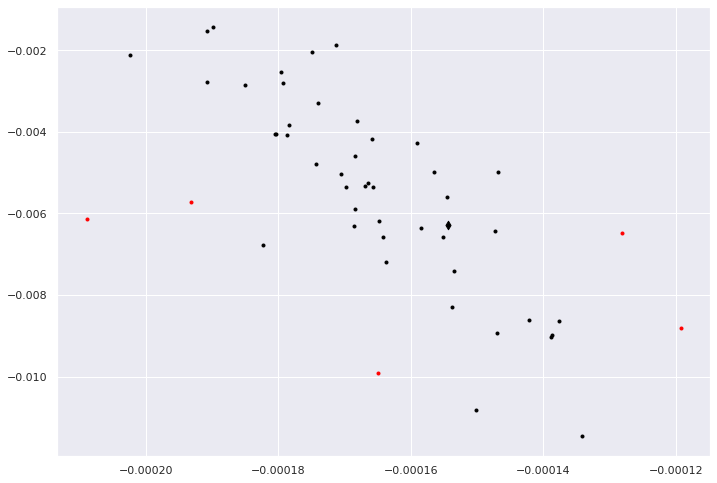

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.42578759337447225
fowlkes_mallows_score: 0.9183914551600827
homogeneity_completeness_v_measure: 0.5494889745532635 0.25048345610992184 0.34410660208951227


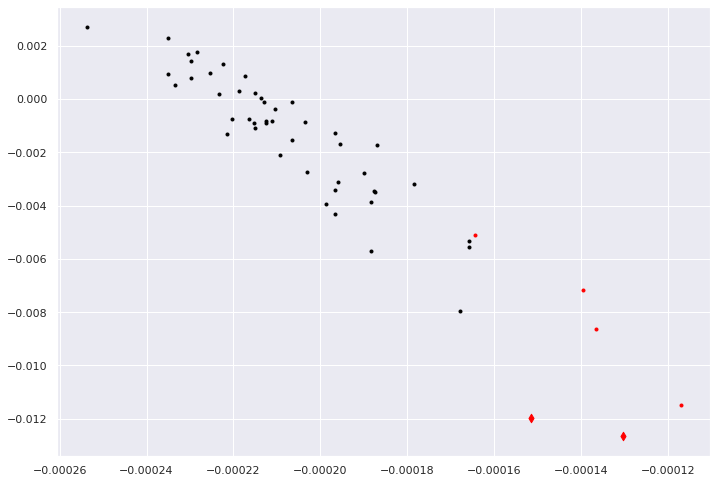

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


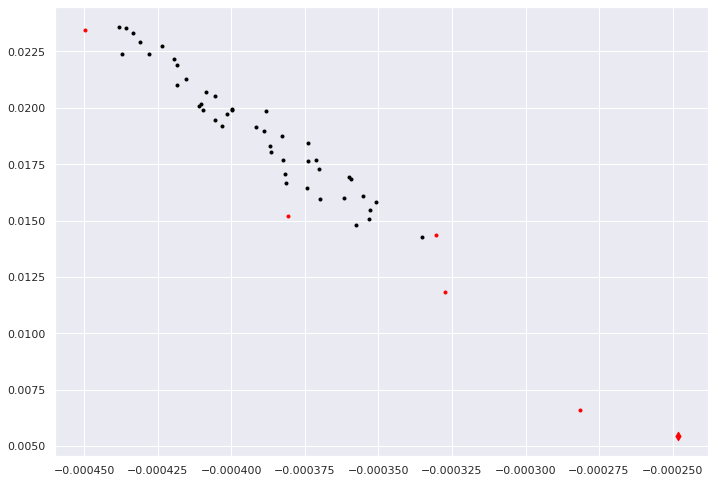

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.5366199555832372
fowlkes_mallows_score: 0.9242961818866308
homogeneity_completeness_v_measure: 0.38383858940727217 0.30182665777775125 0.3379279292411366


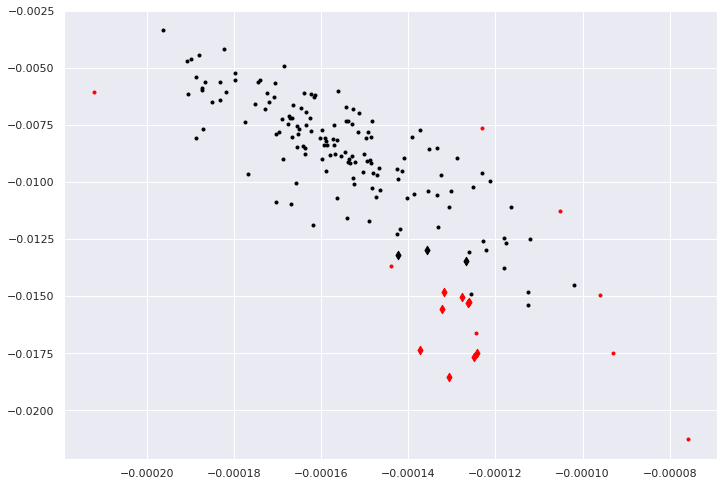

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.10216921647116436
fowlkes_mallows_score: 0.8939206674606517
homogeneity_completeness_v_measure: 0.05653839711722464 0.021480874271598314 0.03113318487531499


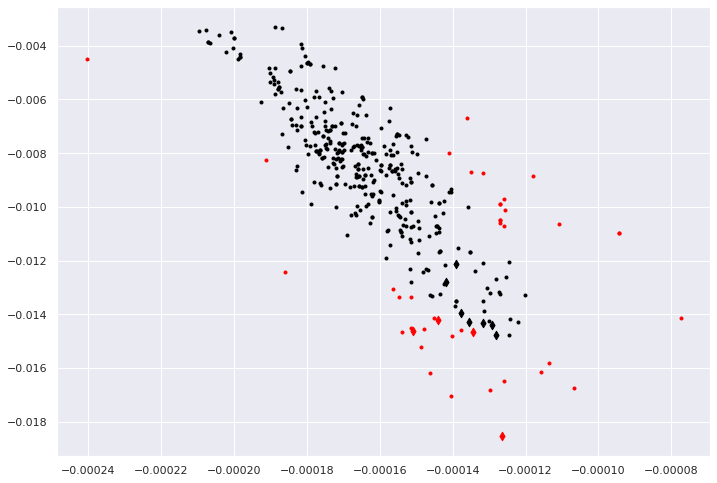

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


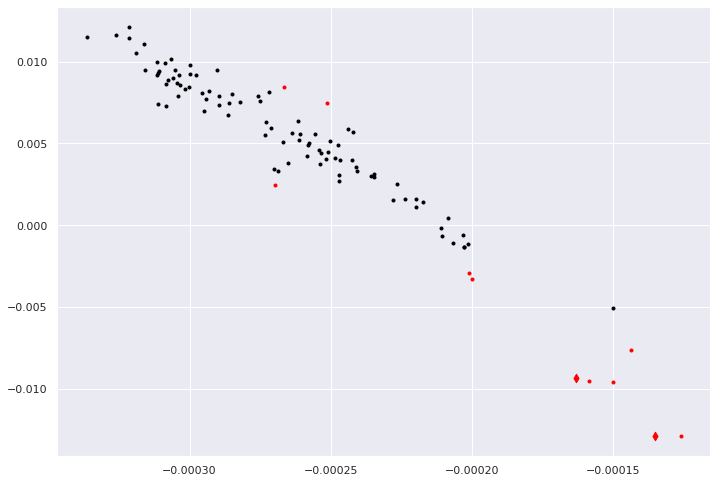

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.08304049420258265
fowlkes_mallows_score: 0.8112639652899177
homogeneity_completeness_v_measure: 0.03305265142814905 0.03097372536331339 0.03197943719974265


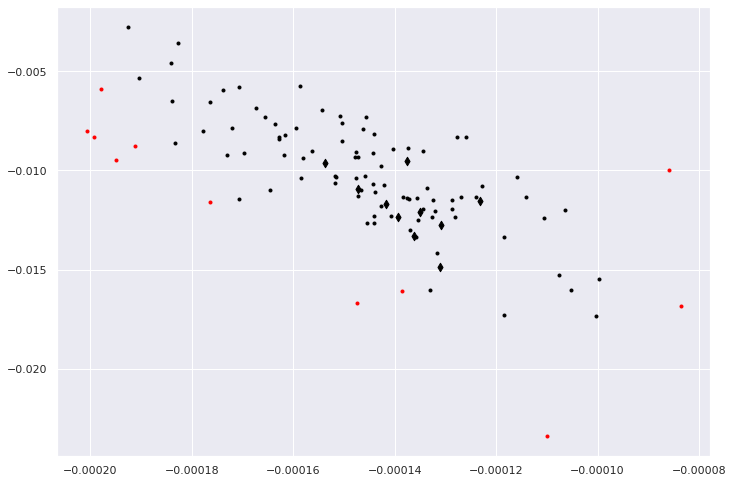

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.08761576175776285
fowlkes_mallows_score: 0.8006263333730135
homogeneity_completeness_v_measure: 0.03624737285782633 0.032042727608605194 0.03401560949765492


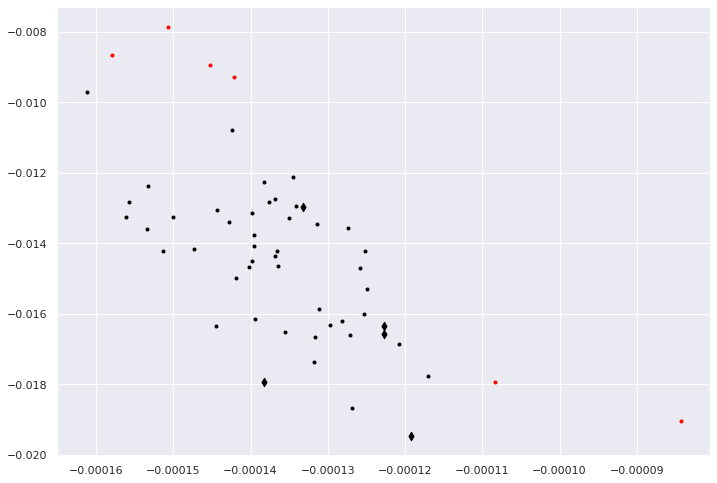

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


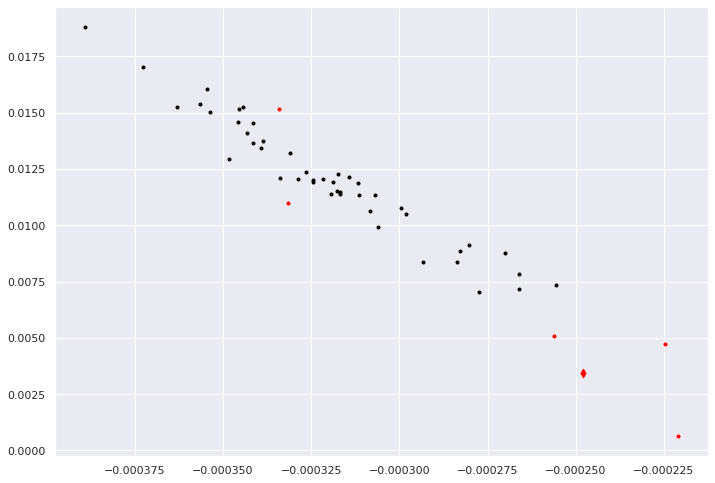

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.7447833065810594
fowlkes_mallows_score: 0.9568496885950687
homogeneity_completeness_v_measure: 0.7321596405397185 0.5542157893504782 0.6308802604336415


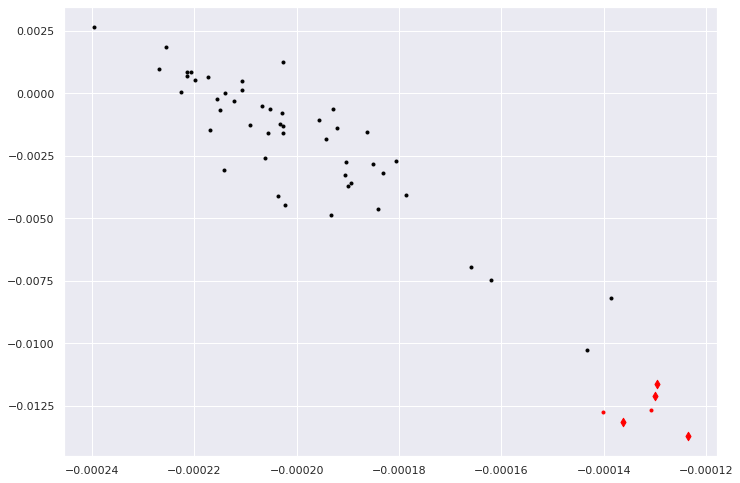

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.05272274548013424
fowlkes_mallows_score: 0.8478815545719766
homogeneity_completeness_v_measure: 0.029533560624185776 0.013462814867927575 0.01849480820294072


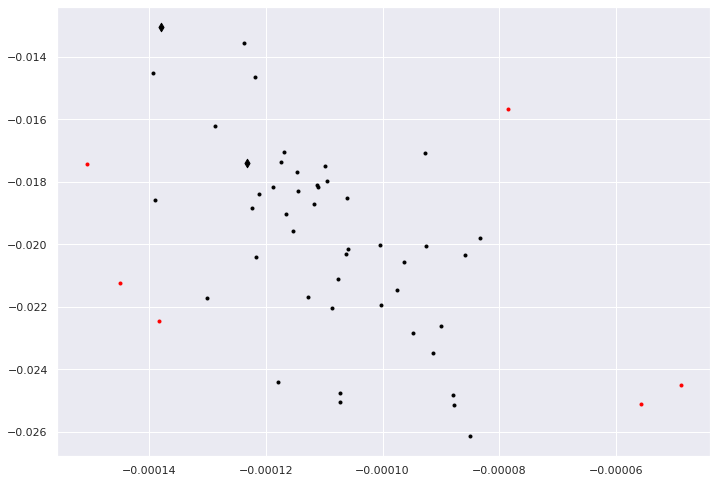

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.3986226139519282
fowlkes_mallows_score: 0.9074335167101755
homogeneity_completeness_v_measure: 0.24356845200542424 0.18357190568069856 0.20935659248190086


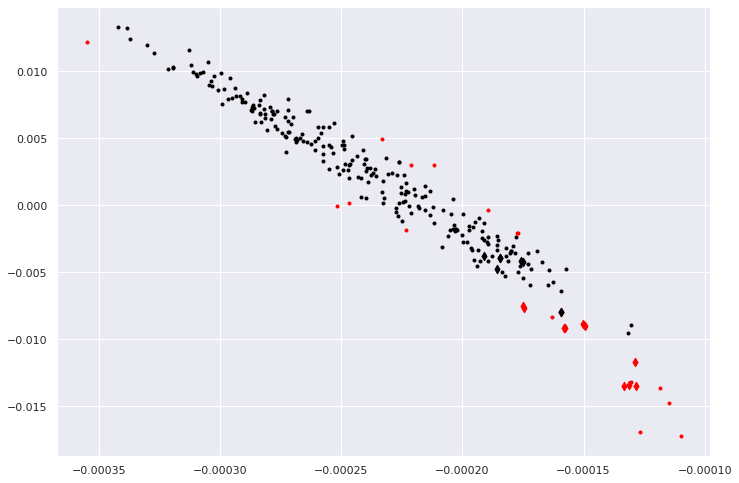

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.36476567989490727
fowlkes_mallows_score: 0.9201005722186186
homogeneity_completeness_v_measure: 0.5248179477986026 0.20341795764784604 0.2931945384172659


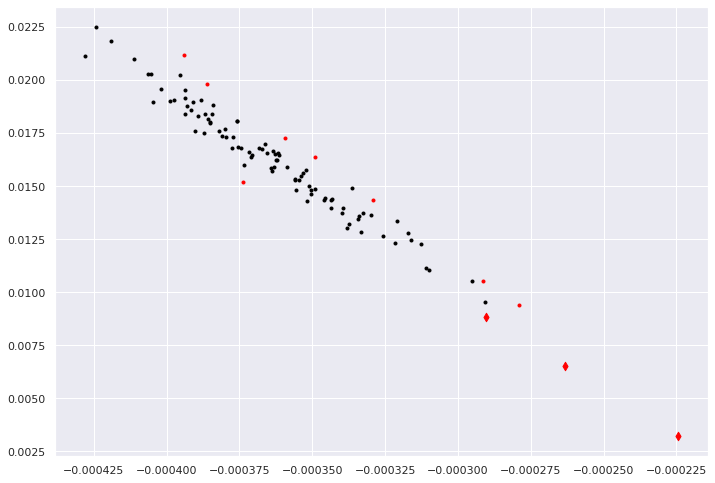

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.09692554636374862
fowlkes_mallows_score: 0.8455684913311489
homogeneity_completeness_v_measure: 0.02338511480278485 0.017701603778546272 0.020150260271347444


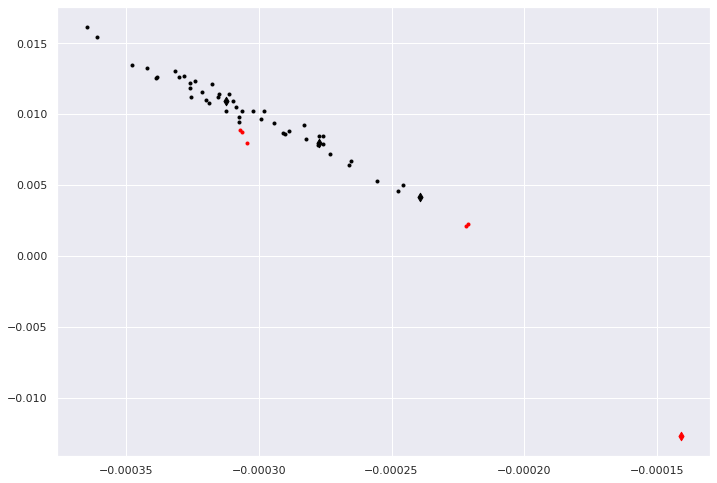

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: -0.04144995111966517
fowlkes_mallows_score: 0.8670807858659687
homogeneity_completeness_v_measure: 0.02537224732261839 0.00983421156412823 0.014174447298472554


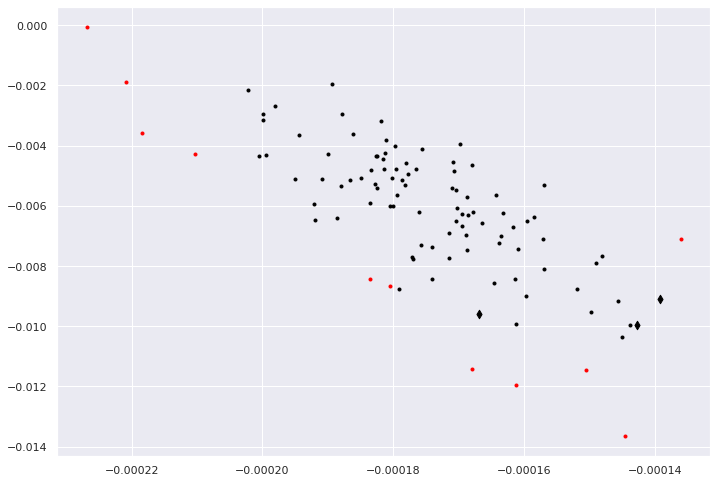

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


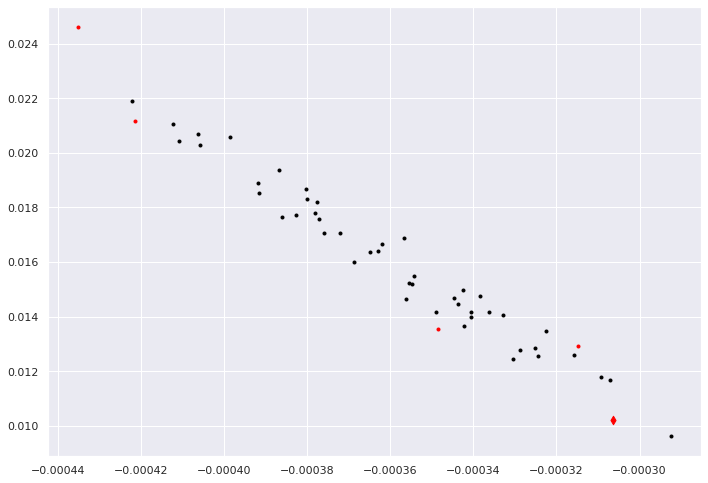

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.32687734044686106
fowlkes_mallows_score: 0.9100046418975695
homogeneity_completeness_v_measure: 0.2938327517060728 0.1418983542457077 0.19137666933144515


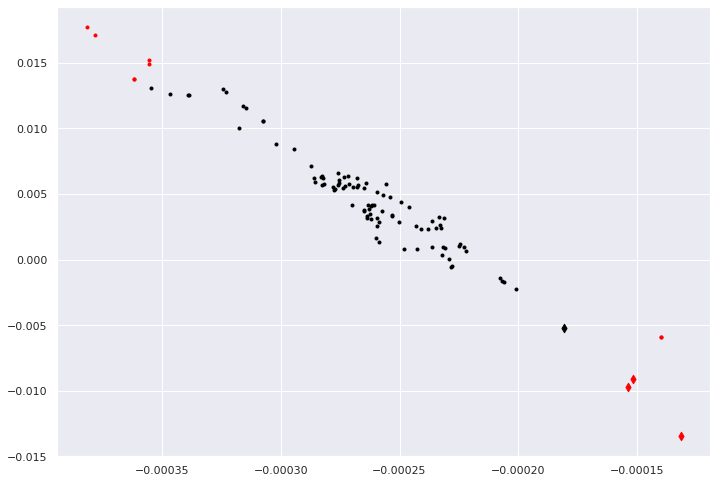

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


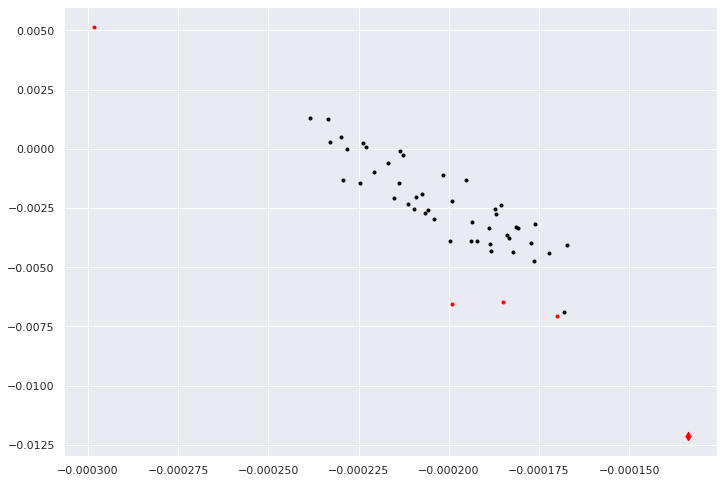

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.5952582358193524
fowlkes_mallows_score: 0.9369687007474506
homogeneity_completeness_v_measure: 0.6392515284712909 0.3937178184645023 0.48730336091078497


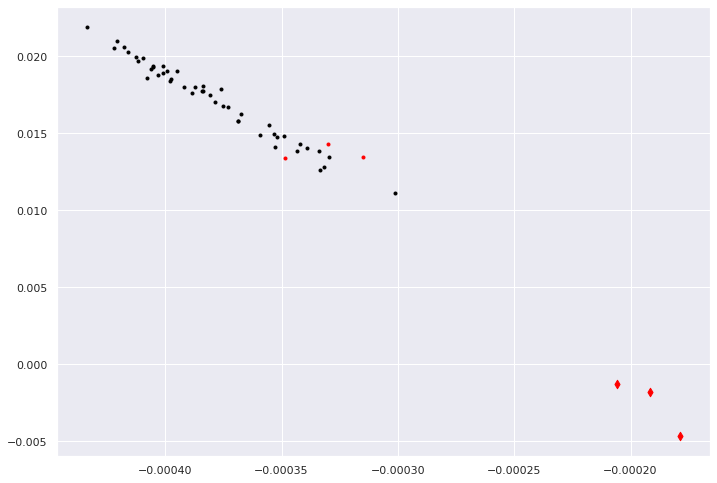

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.3125
fowlkes_mallows_score: 0.9008650489260795
homogeneity_completeness_v_measure: 0.1633315581837165 0.12273216867115462 0.14015084379080586


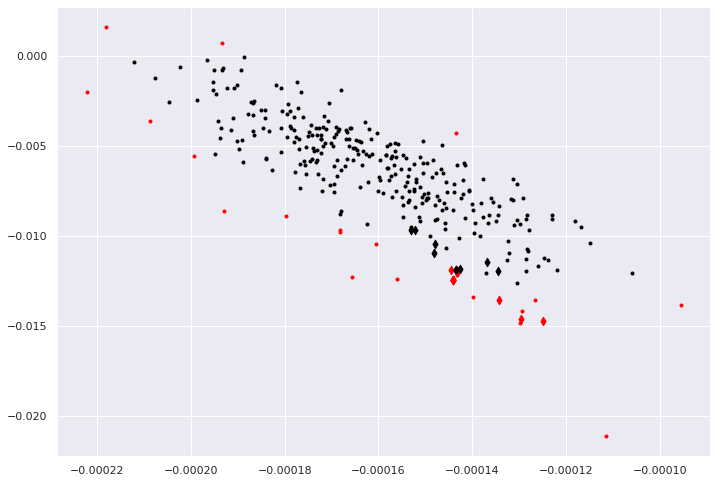

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.5436997918410137
fowlkes_mallows_score: 0.9386503207015755
homogeneity_completeness_v_measure: 0.6167940320942551 0.3414107948907943 0.43953053637556627


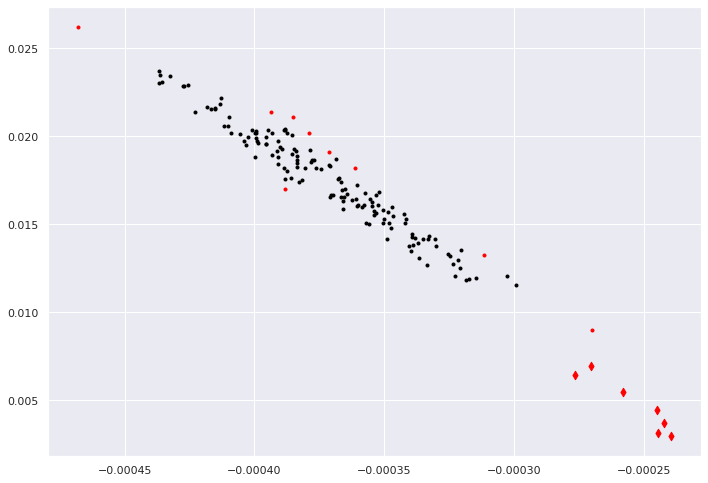

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


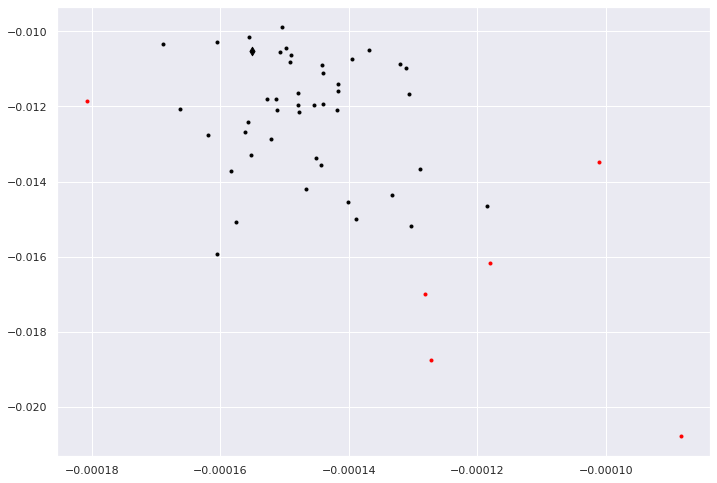

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


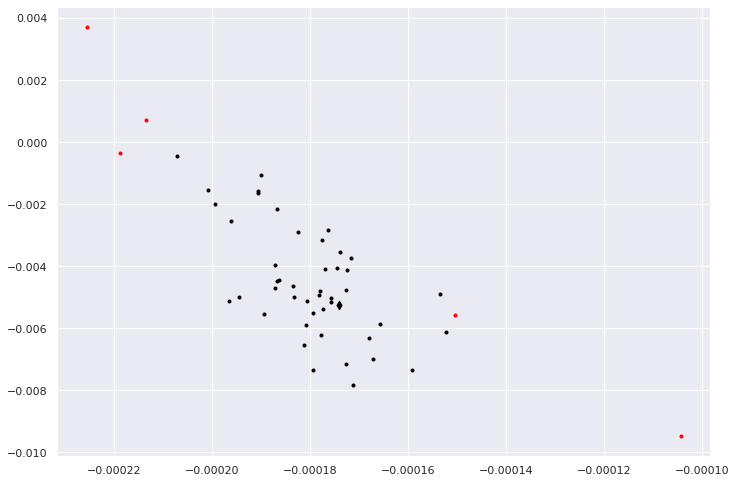

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


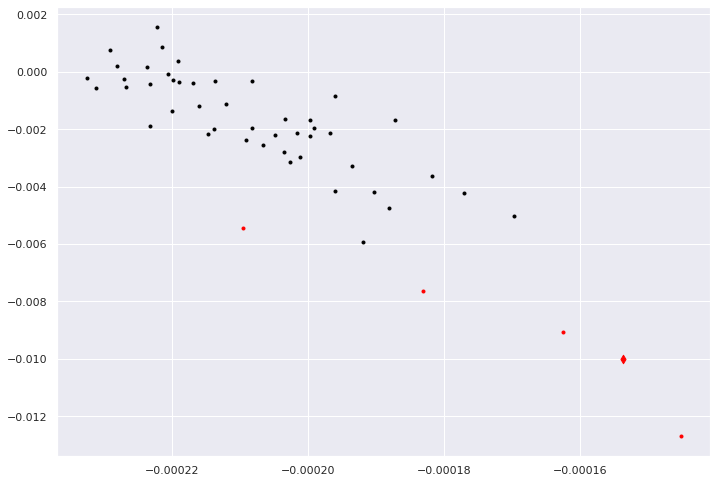

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


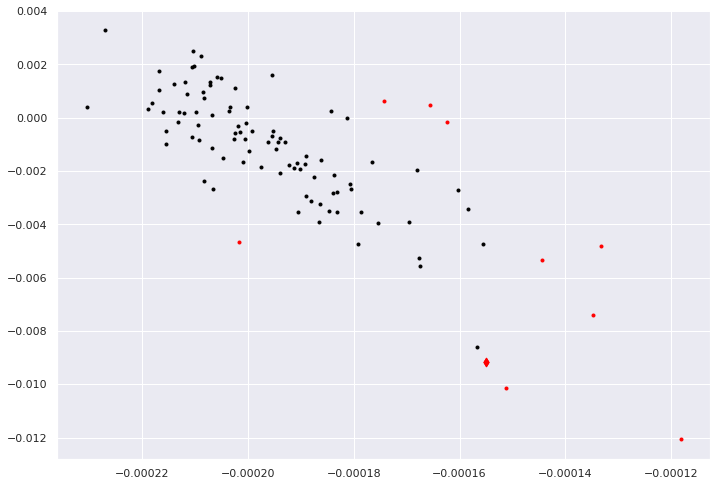

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.43626603012634224
fowlkes_mallows_score: 0.9297267996688643
homogeneity_completeness_v_measure: 0.5630044070805916 0.2534424952159976 0.34953710118009346


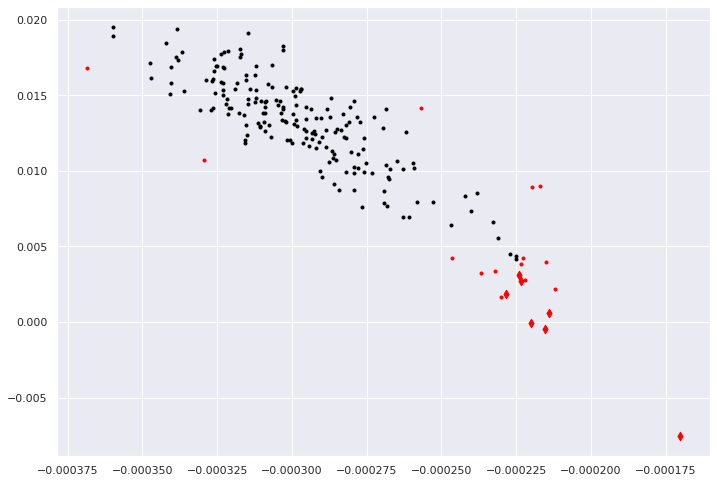

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.20558762631314134
fowlkes_mallows_score: 0.8970870823718041
homogeneity_completeness_v_measure: 0.12821348330016935 0.06388273219273119 0.08527630381624712


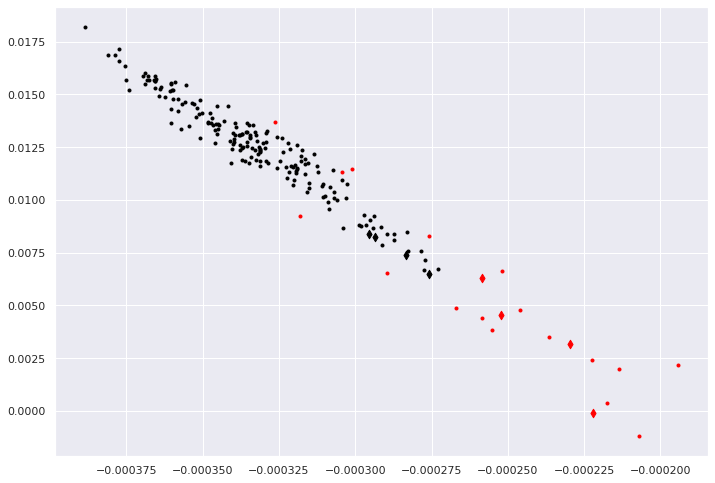

In [25]:
from sklearn.covariance import EllipticEnvelope


# add grid search to nu


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  values.append({'contamination':0.02})
clustering_function(familyes,df_data, df, EllipticEnvelope, params=None)




In [26]:
import pandas as pd

a = pd.DataFrame(all_res_table)
len(a.family_lable.unique())
a

algo   family_lable  \
0             <class 'sklearn.cluster._dbscan.DBSCAN'>      Aeropyrum   
1             <class 'sklearn.cluster._dbscan.DBSCAN'>     Agmenellum   
2             <class 'sklearn.cluster._dbscan.DBSCAN'>  Agrobacterium   
3             <class 'sklearn.cluster._dbscan.DBSCAN'>       Anabaena   
4             <class 'sklearn.cluster._dbscan.DBSCAN'>   Arthrobacter   
..                                                 ...            ...   
187  <class 'sklearn.covariance._elliptic_envelope....   Thermococcus   
188  <class 'sklearn.covariance._elliptic_envelope....   Thermoplasma   
189  <class 'sklearn.covariance._elliptic_envelope....     Thermotoga   
190  <class 'sklearn.covariance._elliptic_envelope....        Thermus   
191  <class 'sklearn.covariance._elliptic_envelope....    Xanthomonas   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
0   -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
1    0.085798  0.800586     0.300678      0.053186   0.090385  0.019608   
2    0.015041  0.539971     0.362146      0.027402   0.050950  0.000000   
3    0.003380  0.544645     0.021736      0.005388   0.008635  0.018519   
4    0.044000  0.639648     0.281081      0.030296   0.054697  0.019481   
..        ...       ...          ...           ...        ...       ...   
187 -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
188  0.282335  0.920078     0.491663      0.147933   0.227434  0.019608   
189  0.254852  0.911570     0.470177      0.132686   0.206966  0.019608   
190  0.436266  0.929727     0.563004      0.253442   0.349537  0.033816   
191  0.205588  0.897087     0.128213      0.063883   0.085276  0.019231   

           fp        fn        tn  family_size  re_size  
0    0.019608  0.098039  0.882353           51        1  
1    0.000000  0.215686  0.764706           51        1  
2    0.019608  0.431373  0.549020           51        1  
3    0.055556  0.407407  0.518519           54        4  
4    0.006494  0.155844  0.818182          154        4  
..        ...       ...       ...          ...      ...  
187  0.019608  0.098039  0.882353           51        1  
188  0.000000  0.078431  0.901961           51        1  
189  0.000000  0.088235  0.892157          102        2  
190  0.000000  0.067633  0.898551          207        7  
191  0.019231  0.081731  0.879808          208        8  

[192 rows x 13 columns]

# to csv

In [27]:
a.sort_values(by =['fmi'] , ascending = False).to_csv('res_of_pca_tfidf.csv')

In [28]:
a.sort_values(by =['fmi'], ascending = False)

algo     family_lable  \
162  <class 'sklearn.covariance._elliptic_envelope....     Enterobacter   
17            <class 'sklearn.cluster._dbscan.DBSCAN'>      Diplococcus   
174  <class 'sklearn.covariance._elliptic_envelope....        Moraxella   
44            <class 'sklearn.cluster._dbscan.DBSCAN'>     Thermoplasma   
185  <class 'sklearn.covariance._elliptic_envelope....     Streptomyces   
..                                                 ...              ...   
13            <class 'sklearn.cluster._dbscan.DBSCAN'>      Clostridium   
8             <class 'sklearn.cluster._dbscan.DBSCAN'>  Bifidobacterium   
32            <class 'sklearn.cluster._dbscan.DBSCAN'>        Neisseria   
25            <class 'sklearn.cluster._dbscan.DBSCAN'>     Helicobacter   
6             <class 'sklearn.cluster._dbscan.DBSCAN'>         Bacillus   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
162  0.878654  0.977902     0.838653      0.741370   0.787017  0.090909   
17   0.463619  0.959168     0.612036      0.264024   0.368907  0.019608   
174  0.744783  0.956850     0.732160      0.554216   0.630880  0.074074   
44   0.354997  0.939391     0.542999      0.190615   0.282175  0.019608   
185  0.543700  0.938650     0.616794      0.341411   0.439531  0.044586   
..        ...       ...          ...           ...        ...       ...   
13   0.003413  0.436010     0.119429      0.008109   0.015187  0.006494   
8   -0.002586  0.431225     0.115078      0.008723   0.016216  0.009709   
32   0.008837  0.371790     0.350444      0.043739   0.077771  0.029851   
25   0.001859  0.349635     0.422146      0.021130   0.040245  0.014599   
6   -0.004492  0.243414     0.266638      0.031991   0.057128  0.035785   

           fp        fn        tn  family_size  re_size  
162  0.000000  0.018182  0.890909           55        5  
17   0.000000  0.039216  0.941176           51        1  
174  0.000000  0.037037  0.888889           54        4  
44   0.000000  0.058824  0.921569           51        1  
185  0.000000  0.057325  0.898089          157        7  
..        ...       ...       ...          ...      ...  
13   0.019481  0.136364  0.837662          154        4  
8    0.019417  0.194175  0.776699          103        3  
32   0.037313  0.126866  0.805970          268       18  
25   0.012165  0.194647  0.778589          411       11  
6    0.069583  0.149105  0.745527          503       53  

[192 rows x 13 columns]

In [29]:
a.algo.unique()

array([<class 'sklearn.cluster._dbscan.DBSCAN'>,
       <class 'sklearn.ensemble._iforest.IsolationForest'>,
       <class 'sklearn.svm._classes.OneClassSVM'>,
       <class 'sklearn.covariance._elliptic_envelope.EllipticEnvelope'>],
      dtype=object)

In [30]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['family_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ family_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.18233093344219387
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.534
Date:                Mon, 06 Mar 2023   Prob (F-statistic):             0.0114
Time:                        13:15:49   Log-Likelihood:                 114.88
No. Observations:                 192   AIC:                            -225.8
Df Residuals:                     190   BIC:                            -219.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Inte

In [31]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['re_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ re_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.17723266954794314
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.162
Date:                Mon, 06 Mar 2023   Prob (F-statistic):             0.0139
Time:                        13:15:49   Log-Likelihood:                 114.70
No. Observations:                 192   AIC:                            -225.4
Df Residuals:                     190   BIC:                            -218.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc